In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
weight_bit_width = 4
act_bit_width = 4
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='int',
                         scaling_impl_type='const',
                         bit_width=act_bit_width,
                         min_val=-8.0,
                         max_val=7.0, 
                         return_quant_tensor=True
                     )
        
        self.conv0 = qnn.QuantConv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = qnn.QuantConv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = qnn.QuantLinear(
                         input_length, 
                         hidden_0, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(
                         hidden_0, 
                         output_length, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )

    def forward(self, x):
        out = self.input(x)
        out = self.pool0(self.drop0(self.act0(self.bn0(self.conv0(out)))))
        out = self.pool1(self.drop1(self.act1(self.bn1(self.conv1(out)))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  return F.conv2d(input, weight, bias, self.stride,
/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1672, Acc: 0.9587 | Val Loss: 0.1142, Acc: 0.9640


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9825 | Val Loss: 0.1232, Acc: 0.9634


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9863 | Val Loss: 0.2164, Acc: 0.9324


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.0486, Acc: 0.9858


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9923 | Val Loss: 0.0842, Acc: 0.9766


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9924 | Val Loss: 0.0523, Acc: 0.9842


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0560, Acc: 0.9838


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.1131, Acc: 0.9679


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0626, Acc: 0.9823


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0702, Acc: 0.9829


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0528, Acc: 0.9866


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0552, Acc: 0.9859


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0554, Acc: 0.9862


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0763, Acc: 0.9823


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0645, Acc: 0.9869


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.0704, Acc: 0.9836


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0901, Acc: 0.9785


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0582, Acc: 0.9881


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0748, Acc: 0.9842


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0826, Acc: 0.9820


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0611, Acc: 0.9857


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0677, Acc: 0.9877


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0623, Acc: 0.9873


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0655, Acc: 0.9868


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0820, Acc: 0.9848


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0730, Acc: 0.9846


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1327, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0821, Acc: 0.9836


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0666, Acc: 0.9876


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0737, Acc: 0.9870


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0663, Acc: 0.9876


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0818, Acc: 0.9864


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0749, Acc: 0.9867


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0719, Acc: 0.9864


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0723, Acc: 0.9878


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0888, Acc: 0.9863


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0648, Acc: 0.9885


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0698, Acc: 0.9882


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0730, Acc: 0.9881


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0662, Acc: 0.9894


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0632, Acc: 0.9902


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0680, Acc: 0.9892


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0901, Acc: 0.9865


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0799, Acc: 0.9888


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0738, Acc: 0.9880


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0673, Acc: 0.9895


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0851, Acc: 0.9863


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0750, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0792, Acc: 0.9883


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0951, Acc: 0.9861


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0857, Acc: 0.9872


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0789, Acc: 0.9882


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0766, Acc: 0.9872


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0909, Acc: 0.9862


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0862, Acc: 0.9878


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0866, Acc: 0.9875


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0809, Acc: 0.9884


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0766, Acc: 0.9883


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0697, Acc: 0.9898


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0844, Acc: 0.9884


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0912, Acc: 0.9874


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0787, Acc: 0.9878


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0862, Acc: 0.9878


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0808, Acc: 0.9889


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0918, Acc: 0.9882


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0847, Acc: 0.9888


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0950, Acc: 0.9870


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0917, Acc: 0.9878


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0982, Acc: 0.9865


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0892, Acc: 0.9874


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0875, Acc: 0.9878


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0906, Acc: 0.9865


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0830, Acc: 0.9879


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0854, Acc: 0.9876


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0951, Acc: 0.9861


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0853, Acc: 0.9883


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0944, Acc: 0.9877


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0964, Acc: 0.9878


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0959, Acc: 0.9879


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1069, Acc: 0.9848


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0876, Acc: 0.9893


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0868, Acc: 0.9892


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0917, Acc: 0.9885


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0987, Acc: 0.9882


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0864, Acc: 0.9881


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0916, Acc: 0.9874


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0862, Acc: 0.9892


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1081, Acc: 0.9877


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0785, Acc: 0.9887


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0943, Acc: 0.9884


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9866


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0975, Acc: 0.9878


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1196, Acc: 0.9863


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0884, Acc: 0.9878


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0853, Acc: 0.9883


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0915, Acc: 0.9878


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0868, Acc: 0.9898


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0944, Acc: 0.9889


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0977, Acc: 0.9882


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9882


Final Test Loss: 0.0789 Accuracy: 0.9887


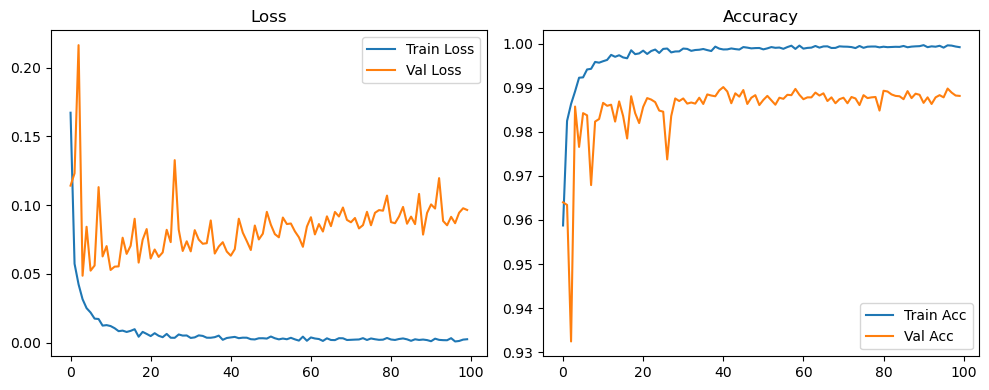

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2129, Acc: 0.9460 | Val Loss: 1.3230, Acc: 0.5970


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9754 | Val Loss: 0.5755, Acc: 0.8205


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9798 | Val Loss: 0.5044, Acc: 0.8318


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.3093, Acc: 0.8987


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9850 | Val Loss: 0.4422, Acc: 0.8608


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9856 | Val Loss: 0.6450, Acc: 0.8289


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.4424, Acc: 0.8694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.1844, Acc: 0.9447


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9889 | Val Loss: 0.1925, Acc: 0.9470


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.2319, Acc: 0.9361


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9901 | Val Loss: 0.3344, Acc: 0.9141


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.1595, Acc: 0.9549


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9902 | Val Loss: 0.2323, Acc: 0.9376


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9917 | Val Loss: 0.1743, Acc: 0.9539


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.2172, Acc: 0.9417


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.2182, Acc: 0.9432


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9931 | Val Loss: 0.1172, Acc: 0.9697


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0930, Acc: 0.9767


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.1778, Acc: 0.9596


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1676, Acc: 0.9605


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1417, Acc: 0.9654


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.1424, Acc: 0.9658


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9945 | Val Loss: 0.1087, Acc: 0.9747


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1578, Acc: 0.9647


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1392, Acc: 0.9678


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.1305, Acc: 0.9694


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1471, Acc: 0.9685


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0777, Acc: 0.9833


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1782, Acc: 0.9627


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9949 | Val Loss: 0.1799, Acc: 0.9641


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.1409, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1529, Acc: 0.9677


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1313, Acc: 0.9724


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0847, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1548, Acc: 0.9662


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1376, Acc: 0.9741


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1207, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.1536, Acc: 0.9692


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1341, Acc: 0.9716


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9954 | Val Loss: 0.1034, Acc: 0.9796


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1293, Acc: 0.9738


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1130, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.1277, Acc: 0.9757


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1491, Acc: 0.9735


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1443, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1269, Acc: 0.9758


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1247, Acc: 0.9764


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1036, Acc: 0.9812


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1591, Acc: 0.9696


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1167, Acc: 0.9772


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1241, Acc: 0.9769


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1167, Acc: 0.9797


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1269, Acc: 0.9757


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9808


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1522, Acc: 0.9732


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1054, Acc: 0.9808


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1615, Acc: 0.9712


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1045, Acc: 0.9822


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1884, Acc: 0.9665


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1344, Acc: 0.9766


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1463, Acc: 0.9752


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1380, Acc: 0.9750


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1163, Acc: 0.9800


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1376, Acc: 0.9758


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1375, Acc: 0.9761


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1323, Acc: 0.9775


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1367, Acc: 0.9762


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1659, Acc: 0.9753


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1330, Acc: 0.9772


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1208, Acc: 0.9771


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1787, Acc: 0.9707


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1713, Acc: 0.9726


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1649, Acc: 0.9741


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1369, Acc: 0.9782


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1225, Acc: 0.9802


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1215, Acc: 0.9802


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1232, Acc: 0.9801


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0952, Acc: 0.9846


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1222, Acc: 0.9795


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0896, Acc: 0.9851


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9976 | Val Loss: 0.1103, Acc: 0.9824


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1356, Acc: 0.9802


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1277, Acc: 0.9798


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1300, Acc: 0.9783


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1349, Acc: 0.9783


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1259, Acc: 0.9800


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0898, Acc: 0.9827


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1247, Acc: 0.9801


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1605, Acc: 0.9754


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1376, Acc: 0.9795


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1203, Acc: 0.9810


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1430, Acc: 0.9782


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1381, Acc: 0.9793


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0984, Acc: 0.9830


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1169, Acc: 0.9783


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1051, Acc: 0.9812


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1188, Acc: 0.9810


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1176, Acc: 0.9822


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1001, Acc: 0.9822


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1083, Acc: 0.9819


Final Test Loss: 0.1102 Accuracy: 0.9797


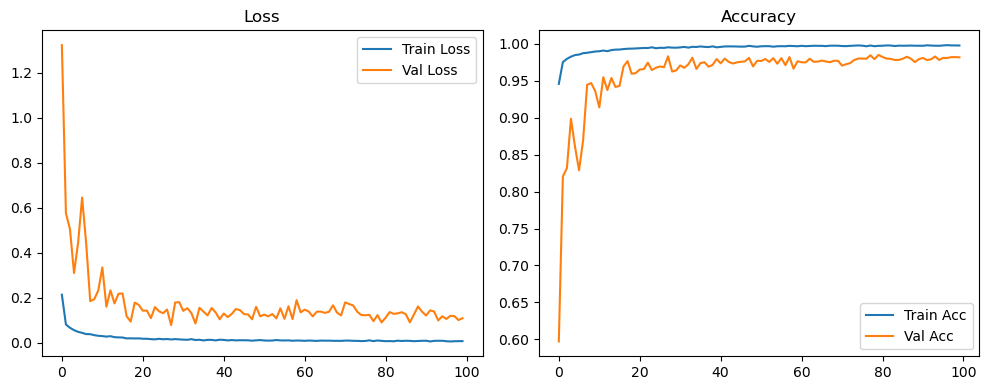

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3852, Acc: 0.8855 | Val Loss: 3.8393, Acc: 0.2172


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1622, Acc: 0.9519 | Val Loss: 1.7722, Acc: 0.4294


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9594 | Val Loss: 2.1171, Acc: 0.3911


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1223, Acc: 0.9632 | Val Loss: 1.7749, Acc: 0.4496


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1139, Acc: 0.9660 | Val Loss: 1.2617, Acc: 0.5606


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1056, Acc: 0.9680 | Val Loss: 1.5379, Acc: 0.5108


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9710 | Val Loss: 1.3513, Acc: 0.5733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0968, Acc: 0.9704 | Val Loss: 0.7991, Acc: 0.6996


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9711 | Val Loss: 1.1841, Acc: 0.6169


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9738 | Val Loss: 1.3520, Acc: 0.5798


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0837, Acc: 0.9742 | Val Loss: 1.3226, Acc: 0.5841


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9757 | Val Loss: 0.8153, Acc: 0.7008


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9752 | Val Loss: 1.7766, Acc: 0.4775


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9756 | Val Loss: 1.3420, Acc: 0.5603


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9773 | Val Loss: 1.1681, Acc: 0.6152


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9780 | Val Loss: 1.2639, Acc: 0.6144


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9775 | Val Loss: 1.3701, Acc: 0.5858


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9787 | Val Loss: 1.1463, Acc: 0.6263


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9789 | Val Loss: 0.9409, Acc: 0.6843


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9805 | Val Loss: 1.5085, Acc: 0.5347


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9791 | Val Loss: 1.1097, Acc: 0.6234


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9792 | Val Loss: 0.9589, Acc: 0.6717


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9807 | Val Loss: 1.1510, Acc: 0.6498


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9809 | Val Loss: 1.0004, Acc: 0.6640


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9806 | Val Loss: 1.3632, Acc: 0.5923


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9799 | Val Loss: 1.3132, Acc: 0.5913


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9807 | Val Loss: 1.2049, Acc: 0.6041


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9816 | Val Loss: 1.1298, Acc: 0.6306


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9820 | Val Loss: 0.6476, Acc: 0.7621


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9815 | Val Loss: 1.2923, Acc: 0.5679


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9821 | Val Loss: 0.6905, Acc: 0.7348


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9827 | Val Loss: 0.9637, Acc: 0.6677


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.9603, Acc: 0.6542


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.7853, Acc: 0.7185


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9829 | Val Loss: 0.5341, Acc: 0.7866


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9838 | Val Loss: 0.7064, Acc: 0.7123


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9829 | Val Loss: 0.7904, Acc: 0.6983


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9833 | Val Loss: 0.4434, Acc: 0.8271


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9828 | Val Loss: 0.5852, Acc: 0.7634


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9842 | Val Loss: 0.6460, Acc: 0.7476


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9858 | Val Loss: 0.5839, Acc: 0.7657


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9834 | Val Loss: 0.6652, Acc: 0.7385


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9846 | Val Loss: 0.9096, Acc: 0.6359


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9843 | Val Loss: 0.7013, Acc: 0.7128


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9844 | Val Loss: 0.6356, Acc: 0.7368


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9845 | Val Loss: 0.6356, Acc: 0.7306


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.7546, Acc: 0.7037


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9840 | Val Loss: 0.7732, Acc: 0.6818


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9841 | Val Loss: 0.6950, Acc: 0.6996


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 0.6969, Acc: 0.7075


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9853 | Val Loss: 0.5125, Acc: 0.7893


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9852 | Val Loss: 0.5379, Acc: 0.7761


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.6973, Acc: 0.6935


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.5965, Acc: 0.7447


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9851 | Val Loss: 0.4618, Acc: 0.8326


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.4654, Acc: 0.8261


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9852 | Val Loss: 0.6740, Acc: 0.6916


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9844 | Val Loss: 0.5043, Acc: 0.8128


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 0.5914, Acc: 0.7482


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9850 | Val Loss: 0.4803, Acc: 0.8295


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.4952, Acc: 0.8189


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9858 | Val Loss: 0.4824, Acc: 0.8177


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9854 | Val Loss: 0.4930, Acc: 0.7950


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.5232, Acc: 0.7851


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9863 | Val Loss: 0.5831, Acc: 0.7562


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.5445, Acc: 0.7662


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9859 | Val Loss: 0.6185, Acc: 0.7356


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.6739, Acc: 0.7240


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9863 | Val Loss: 0.5623, Acc: 0.7712


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9863 | Val Loss: 0.5587, Acc: 0.7808


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9865 | Val Loss: 0.5064, Acc: 0.8217


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9871 | Val Loss: 0.7267, Acc: 0.6732


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.4945, Acc: 0.8253


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9867 | Val Loss: 0.5478, Acc: 0.7979


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9860 | Val Loss: 0.5919, Acc: 0.8122


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9868 | Val Loss: 0.6013, Acc: 0.7865


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.6523, Acc: 0.7321


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9863 | Val Loss: 0.5978, Acc: 0.7648


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9877 | Val Loss: 0.6553, Acc: 0.7508


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.4965, Acc: 0.8675


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9878 | Val Loss: 0.6284, Acc: 0.7836


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 0.6952, Acc: 0.7408


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.5912, Acc: 0.8194


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9878 | Val Loss: 0.6321, Acc: 0.7923


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9884 | Val Loss: 0.6510, Acc: 0.8042


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9872 | Val Loss: 0.6528, Acc: 0.8132


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.5817, Acc: 0.8693


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.6943, Acc: 0.7531


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.7376, Acc: 0.7694


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.5728, Acc: 0.8612


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.6093, Acc: 0.8423


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.6110, Acc: 0.8706


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.7490, Acc: 0.7508


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9884 | Val Loss: 0.7498, Acc: 0.7716


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.7545, Acc: 0.7383


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9876 | Val Loss: 0.7339, Acc: 0.8706


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.7698, Acc: 0.7577


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.7236, Acc: 0.8704


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.7073, Acc: 0.7848


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.7999, Acc: 0.8243


Final Test Loss: 0.7975 Accuracy: 0.8295


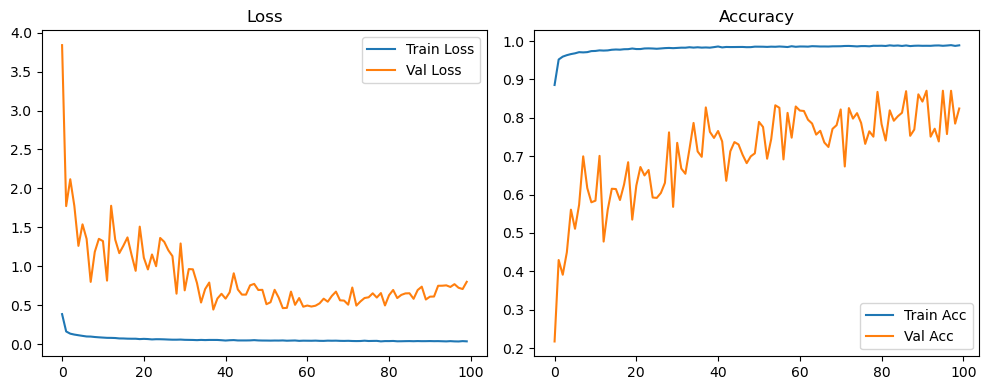

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1668, Acc: 0.9590 | Val Loss: 0.2629, Acc: 0.9168


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9823 | Val Loss: 0.1254, Acc: 0.9631


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.1315, Acc: 0.9590


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.0553, Acc: 0.9831


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.0617, Acc: 0.9812


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0600, Acc: 0.9830


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0510, Acc: 0.9849


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0573, Acc: 0.9838


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0466, Acc: 0.9876


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0664, Acc: 0.9829


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0692, Acc: 0.9829


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0478, Acc: 0.9889


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0739, Acc: 0.9844


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0538, Acc: 0.9882


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0580, Acc: 0.9878


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0927, Acc: 0.9808


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0687, Acc: 0.9850


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0819, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0633, Acc: 0.9858


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0576, Acc: 0.9878


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0600, Acc: 0.9878


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0885, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0847, Acc: 0.9837


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0601, Acc: 0.9870


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0678, Acc: 0.9877


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0838, Acc: 0.9848


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0908, Acc: 0.9842


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0621, Acc: 0.9882


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0708, Acc: 0.9864


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0788, Acc: 0.9852


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0662, Acc: 0.9868


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0975, Acc: 0.9831


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0736, Acc: 0.9868


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0759, Acc: 0.9871


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0767, Acc: 0.9858


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.0695, Acc: 0.9872


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0980, Acc: 0.9832


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0775, Acc: 0.9868


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0721, Acc: 0.9892


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0705, Acc: 0.9890


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1019, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1009, Acc: 0.9841


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0795, Acc: 0.9874


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0813, Acc: 0.9868


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0888, Acc: 0.9866


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0725, Acc: 0.9886


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0759, Acc: 0.9882


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0813, Acc: 0.9872


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0990, Acc: 0.9865


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0703, Acc: 0.9891


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0741, Acc: 0.9898


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0742, Acc: 0.9879


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0661, Acc: 0.9895


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0793, Acc: 0.9868


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0674, Acc: 0.9895


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0696, Acc: 0.9898


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0714, Acc: 0.9896


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0722, Acc: 0.9903


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0857, Acc: 0.9886


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0785, Acc: 0.9878


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0788, Acc: 0.9873


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0762, Acc: 0.9897


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0859, Acc: 0.9880


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0766, Acc: 0.9888


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0838, Acc: 0.9892


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0866, Acc: 0.9888


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0812, Acc: 0.9898


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0897, Acc: 0.9896


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0893, Acc: 0.9890


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0836, Acc: 0.9892


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0921, Acc: 0.9884


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0846, Acc: 0.9892


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0968, Acc: 0.9877


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0840, Acc: 0.9892


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0843, Acc: 0.9892


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0926, Acc: 0.9874


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0890, Acc: 0.9875


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0932, Acc: 0.9877


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0883, Acc: 0.9886


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0808, Acc: 0.9892


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0828, Acc: 0.9893


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0768, Acc: 0.9892


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0788, Acc: 0.9892


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0844, Acc: 0.9886


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0827, Acc: 0.9893


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0768, Acc: 0.9898


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0784, Acc: 0.9896


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0817, Acc: 0.9895


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0849, Acc: 0.9892


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0832, Acc: 0.9893


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0863, Acc: 0.9881


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0819, Acc: 0.9890


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0804, Acc: 0.9894


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0771, Acc: 0.9898


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0810, Acc: 0.9895


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0794, Acc: 0.9900


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0827, Acc: 0.9894


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0791, Acc: 0.9897


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0783, Acc: 0.9898


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0770, Acc: 0.9901


Final Test Loss: 0.0622 Accuracy: 0.9918


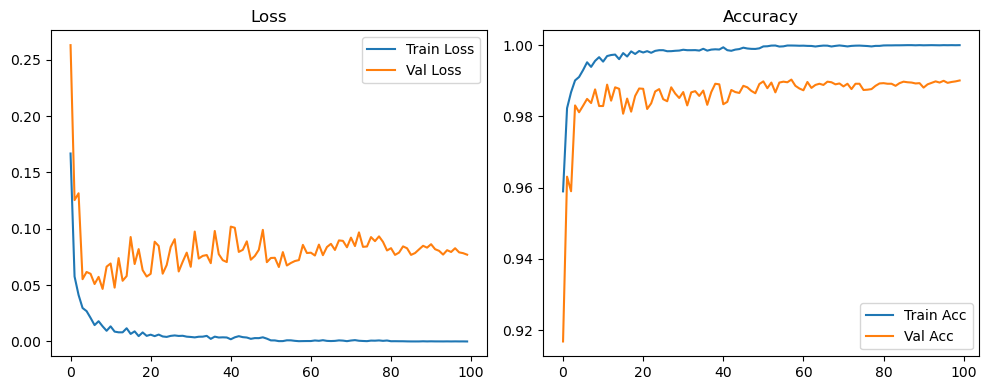

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2123, Acc: 0.9458 | Val Loss: 1.2938, Acc: 0.6320


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9750 | Val Loss: 0.6753, Acc: 0.7944


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9794 | Val Loss: 0.7282, Acc: 0.7767


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9825 | Val Loss: 0.3868, Acc: 0.8723


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.4436, Acc: 0.8624


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9857 | Val Loss: 0.5370, Acc: 0.8365


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.3311, Acc: 0.9028


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9874 | Val Loss: 0.2708, Acc: 0.9167


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.2227, Acc: 0.9372


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.2180, Acc: 0.9363


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.2352, Acc: 0.9382


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.1408, Acc: 0.9589


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.5283, Acc: 0.8778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.2105, Acc: 0.9452


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.1673, Acc: 0.9542


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9931 | Val Loss: 0.1941, Acc: 0.9493


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.1674, Acc: 0.9583


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.3366, Acc: 0.9206


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.1737, Acc: 0.9582


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.2257, Acc: 0.9484


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9937 | Val Loss: 0.2171, Acc: 0.9457


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.1442, Acc: 0.9652


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.2131, Acc: 0.9521


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.2735, Acc: 0.9385


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1972, Acc: 0.9545


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1417, Acc: 0.9700


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1450, Acc: 0.9664


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1584, Acc: 0.9663


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.2309, Acc: 0.9519


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1914, Acc: 0.9611


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1852, Acc: 0.9601


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.1961, Acc: 0.9576


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1977, Acc: 0.9617


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1846, Acc: 0.9629


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1563, Acc: 0.9688


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1315, Acc: 0.9719


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1203, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1775, Acc: 0.9651


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1297, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1773, Acc: 0.9677


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.1681, Acc: 0.9656


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1187, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1689, Acc: 0.9664


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1734, Acc: 0.9675


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1922, Acc: 0.9660


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1042, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.2044, Acc: 0.9628


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1574, Acc: 0.9718


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9962 | Val Loss: 0.1842, Acc: 0.9677


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1312, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1528, Acc: 0.9729


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1272, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1447, Acc: 0.9748


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1149, Acc: 0.9797


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1333, Acc: 0.9771


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1344, Acc: 0.9770


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1189, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.0974, Acc: 0.9827


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1480, Acc: 0.9738


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1622, Acc: 0.9722


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1405, Acc: 0.9771


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1151, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1442, Acc: 0.9739


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1402, Acc: 0.9752


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1543, Acc: 0.9728


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1185, Acc: 0.9787


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1016, Acc: 0.9818


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1120, Acc: 0.9810


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1238, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1205, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1292, Acc: 0.9783


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1877, Acc: 0.9702


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1507, Acc: 0.9754


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1551, Acc: 0.9752


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1444, Acc: 0.9764


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1733, Acc: 0.9726


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1222, Acc: 0.9807


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1614, Acc: 0.9722


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1126, Acc: 0.9812


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1254, Acc: 0.9800


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1294, Acc: 0.9806


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1103, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1104, Acc: 0.9810


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1131, Acc: 0.9822


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1276, Acc: 0.9796


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1200, Acc: 0.9797


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1064, Acc: 0.9819


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1257, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1439, Acc: 0.9772


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1299, Acc: 0.9807


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1438, Acc: 0.9778


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1319, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1210, Acc: 0.9812


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1103, Acc: 0.9824


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1256, Acc: 0.9812


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1289, Acc: 0.9802


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1203, Acc: 0.9808


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1401, Acc: 0.9772


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1220, Acc: 0.9812


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1154, Acc: 0.9813


Final Test Loss: 0.1216 Accuracy: 0.9823


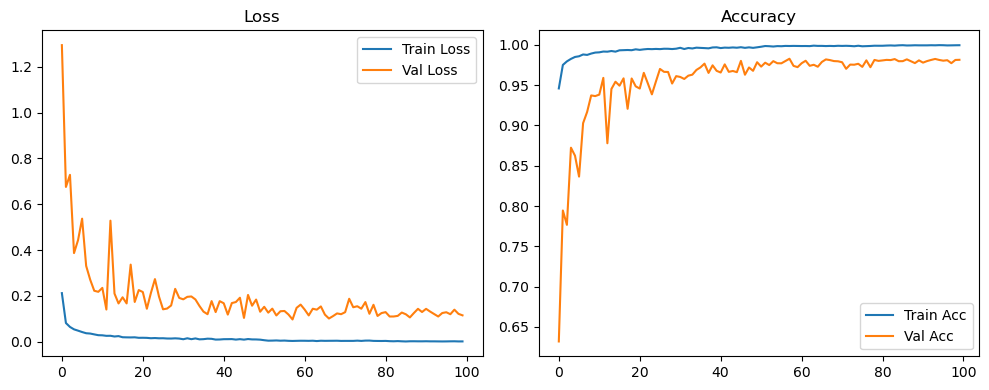

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3845, Acc: 0.8869 | Val Loss: 3.3524, Acc: 0.2462


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1616, Acc: 0.9522 | Val Loss: 2.3560, Acc: 0.3499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1357, Acc: 0.9598 | Val Loss: 2.7532, Acc: 0.3080


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9635 | Val Loss: 2.0520, Acc: 0.3937


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9663 | Val Loss: 1.4683, Acc: 0.5231


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1035, Acc: 0.9678 | Val Loss: 1.7377, Acc: 0.4617


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9709 | Val Loss: 1.2268, Acc: 0.5823


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9705 | Val Loss: 0.9658, Acc: 0.6331


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9727 | Val Loss: 1.2914, Acc: 0.5769


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9738 | Val Loss: 1.1605, Acc: 0.6193


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9736 | Val Loss: 1.2471, Acc: 0.5816


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9745 | Val Loss: 1.0422, Acc: 0.6388


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9754 | Val Loss: 1.9106, Acc: 0.4115


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9761 | Val Loss: 1.4560, Acc: 0.5378


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9773 | Val Loss: 1.6066, Acc: 0.5026


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9785 | Val Loss: 1.2041, Acc: 0.5946


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9777 | Val Loss: 1.2172, Acc: 0.6116


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9788 | Val Loss: 1.5239, Acc: 0.5006


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9784 | Val Loss: 0.7790, Acc: 0.7208


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9789 | Val Loss: 1.3049, Acc: 0.5323


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9794 | Val Loss: 1.2412, Acc: 0.5806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9796 | Val Loss: 0.9204, Acc: 0.6642


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9805 | Val Loss: 1.1943, Acc: 0.5865


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9805 | Val Loss: 0.7610, Acc: 0.7175


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9799 | Val Loss: 0.9314, Acc: 0.6557


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9811 | Val Loss: 1.2337, Acc: 0.5863


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9806 | Val Loss: 1.1554, Acc: 0.5707


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9809 | Val Loss: 0.8216, Acc: 0.6644


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9819 | Val Loss: 0.6456, Acc: 0.7506


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9825 | Val Loss: 1.2318, Acc: 0.5636


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 0.7145, Acc: 0.6780


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9827 | Val Loss: 0.7761, Acc: 0.6997


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9824 | Val Loss: 0.8767, Acc: 0.6469


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9835 | Val Loss: 0.9691, Acc: 0.6462


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9830 | Val Loss: 0.6567, Acc: 0.7227


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9827 | Val Loss: 0.7919, Acc: 0.6588


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9818 | Val Loss: 0.7065, Acc: 0.7070


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9835 | Val Loss: 0.6836, Acc: 0.7084


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9831 | Val Loss: 0.8458, Acc: 0.6332


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9836 | Val Loss: 0.9850, Acc: 0.5706


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9840 | Val Loss: 0.7149, Acc: 0.6993


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.7182, Acc: 0.6947


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9840 | Val Loss: 0.7589, Acc: 0.6667


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.7350, Acc: 0.6936


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9844 | Val Loss: 0.7206, Acc: 0.6888


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9841 | Val Loss: 0.7272, Acc: 0.6706


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9848 | Val Loss: 0.9788, Acc: 0.5784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9838 | Val Loss: 0.6552, Acc: 0.7378


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9849 | Val Loss: 0.6469, Acc: 0.7258


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9849 | Val Loss: 0.5597, Acc: 0.7742


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.5427, Acc: 0.7718


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 0.5884, Acc: 0.7452


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.5081, Acc: 0.7896


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.5222, Acc: 0.7745


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.5183, Acc: 0.7877


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.4482, Acc: 0.8231


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.6764, Acc: 0.6878


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.4808, Acc: 0.8069


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9887 | Val Loss: 0.6219, Acc: 0.7278


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.5633, Acc: 0.7678


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 0.7090, Acc: 0.6510


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.6156, Acc: 0.7298


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.5671, Acc: 0.7512


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9884 | Val Loss: 0.6053, Acc: 0.7339


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9884 | Val Loss: 0.5911, Acc: 0.7289


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 0.6369, Acc: 0.7162


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9884 | Val Loss: 0.6189, Acc: 0.6939


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9892 | Val Loss: 0.5684, Acc: 0.7491


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9881 | Val Loss: 0.5747, Acc: 0.7547


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9890 | Val Loss: 0.5051, Acc: 0.8011


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9885 | Val Loss: 0.5663, Acc: 0.7651


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.4988, Acc: 0.8003


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9890 | Val Loss: 0.6231, Acc: 0.7153


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9884 | Val Loss: 0.6544, Acc: 0.7109


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9876 | Val Loss: 0.5925, Acc: 0.7532


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.5700, Acc: 0.7649


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.6839, Acc: 0.6647


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.6368, Acc: 0.7002


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.6983, Acc: 0.6779


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.6255, Acc: 0.7396


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.6432, Acc: 0.7503


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9902 | Val Loss: 0.6253, Acc: 0.7478


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.6713, Acc: 0.7201


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9905 | Val Loss: 0.6258, Acc: 0.7562


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.7017, Acc: 0.6764


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.6918, Acc: 0.6716


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.5890, Acc: 0.7697


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.6221, Acc: 0.7514


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.6583, Acc: 0.7136


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.6975, Acc: 0.6985


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.7364, Acc: 0.6638


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.6726, Acc: 0.6934


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.6451, Acc: 0.7417


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.6716, Acc: 0.7075


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.6562, Acc: 0.7304


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.6757, Acc: 0.7053


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.6589, Acc: 0.7436


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.6755, Acc: 0.7032


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.6332, Acc: 0.7292


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.6400, Acc: 0.7529


Final Test Loss: 0.6394 Accuracy: 0.7557


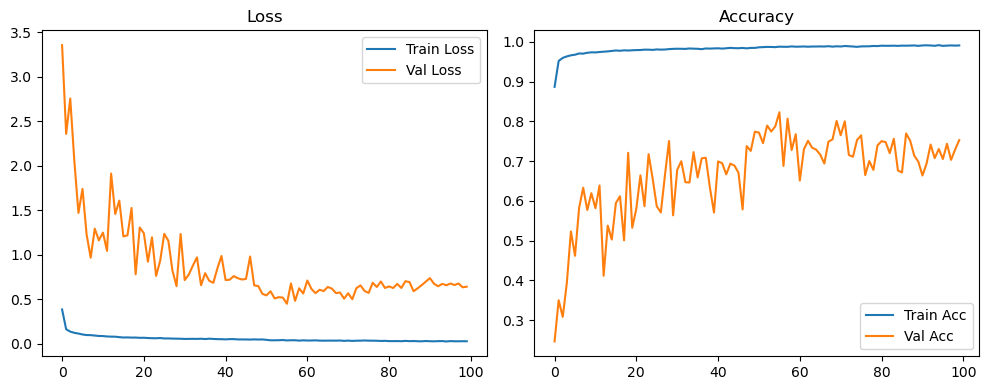

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1678, Acc: 0.9589 | Val Loss: 0.1644, Acc: 0.9480


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9825 | Val Loss: 0.1176, Acc: 0.9627


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9868 | Val Loss: 0.0722, Acc: 0.9777


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0529, Acc: 0.9841


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.1101, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.0524, Acc: 0.9830


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9937 | Val Loss: 0.1149, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0502, Acc: 0.9862


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0536, Acc: 0.9862


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0553, Acc: 0.9858


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0625, Acc: 0.9844


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0741, Acc: 0.9832


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0556, Acc: 0.9871


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.0532, Acc: 0.9872


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0611, Acc: 0.9848


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0834, Acc: 0.9829


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0677, Acc: 0.9855


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0739, Acc: 0.9832


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0641, Acc: 0.9858


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0652, Acc: 0.9862


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0586, Acc: 0.9886


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0649, Acc: 0.9867


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0717, Acc: 0.9858


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0811, Acc: 0.9854


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0634, Acc: 0.9882


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0642, Acc: 0.9865


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0635, Acc: 0.9884


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0654, Acc: 0.9870


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0667, Acc: 0.9872


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0682, Acc: 0.9872


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0820, Acc: 0.9851


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1035, Acc: 0.9814


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0678, Acc: 0.9881


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0762, Acc: 0.9872


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0707, Acc: 0.9890


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0658, Acc: 0.9885


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0761, Acc: 0.9868


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0715, Acc: 0.9871


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0727, Acc: 0.9862


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0657, Acc: 0.9869


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0603, Acc: 0.9895


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0763, Acc: 0.9875


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0802, Acc: 0.9848


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0811, Acc: 0.9870


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0688, Acc: 0.9882


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0834, Acc: 0.9878


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0773, Acc: 0.9873


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0765, Acc: 0.9867


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0936, Acc: 0.9865


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0779, Acc: 0.9874


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0708, Acc: 0.9882


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0698, Acc: 0.9894


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0727, Acc: 0.9886


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0732, Acc: 0.9884


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0771, Acc: 0.9888


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0748, Acc: 0.9878


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0750, Acc: 0.9883


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0779, Acc: 0.9882


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0800, Acc: 0.9877


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0718, Acc: 0.9899


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0795, Acc: 0.9892


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0770, Acc: 0.9889


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0729, Acc: 0.9891


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0796, Acc: 0.9881


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0845, Acc: 0.9883


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0765, Acc: 0.9882


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0779, Acc: 0.9887


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0717, Acc: 0.9898


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0829, Acc: 0.9890


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0864, Acc: 0.9888


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0775, Acc: 0.9888


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0816, Acc: 0.9877


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0786, Acc: 0.9883


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0782, Acc: 0.9888


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0870, Acc: 0.9882


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0809, Acc: 0.9879


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0777, Acc: 0.9886


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0826, Acc: 0.9893


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0784, Acc: 0.9891


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0842, Acc: 0.9882


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0838, Acc: 0.9886


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0793, Acc: 0.9888


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0790, Acc: 0.9892


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0826, Acc: 0.9891


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0786, Acc: 0.9892


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0781, Acc: 0.9895


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0790, Acc: 0.9891


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0761, Acc: 0.9898


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0760, Acc: 0.9891


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0769, Acc: 0.9892


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0777, Acc: 0.9898


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0749, Acc: 0.9897


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0799, Acc: 0.9896


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0799, Acc: 0.9892


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0772, Acc: 0.9900


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0786, Acc: 0.9897


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0805, Acc: 0.9894


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0769, Acc: 0.9897


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0754, Acc: 0.9901


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0772, Acc: 0.9891


Final Test Loss: 0.0651 Accuracy: 0.9908


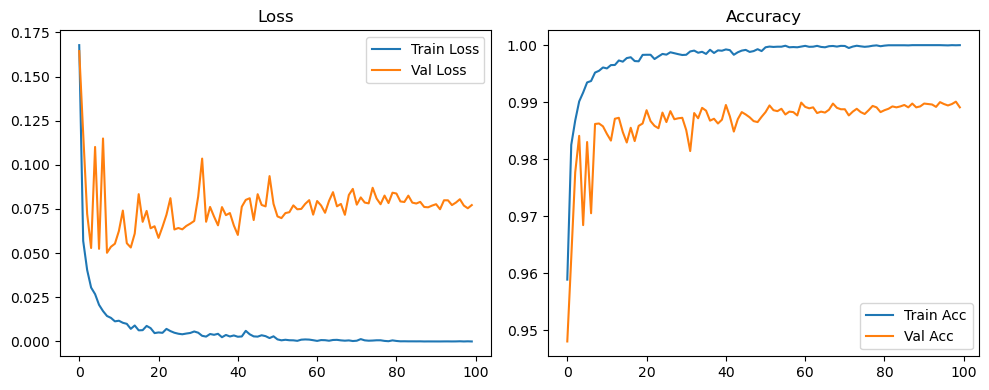

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2118, Acc: 0.9456 | Val Loss: 1.3479, Acc: 0.6323


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9742 | Val Loss: 0.5809, Acc: 0.8176


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9796 | Val Loss: 0.6330, Acc: 0.7898


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9833 | Val Loss: 0.4230, Acc: 0.8688


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9860 | Val Loss: 0.2987, Acc: 0.9022


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9858 | Val Loss: 0.6964, Acc: 0.8113


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.3645, Acc: 0.8957


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9873 | Val Loss: 0.2893, Acc: 0.9088


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.2429, Acc: 0.9335


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.2842, Acc: 0.9213


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.2782, Acc: 0.9237


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9916 | Val Loss: 0.1107, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.3279, Acc: 0.9183


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.3023, Acc: 0.9180


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.1800, Acc: 0.9555


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.2948, Acc: 0.9272


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.1586, Acc: 0.9627


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9933 | Val Loss: 0.1725, Acc: 0.9569


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9927 | Val Loss: 0.1915, Acc: 0.9549


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1671, Acc: 0.9591


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1355, Acc: 0.9676


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1460, Acc: 0.9684


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.1659, Acc: 0.9616


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9944 | Val Loss: 0.1379, Acc: 0.9670


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1776, Acc: 0.9597


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1110, Acc: 0.9747


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1304, Acc: 0.9717


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.1374, Acc: 0.9686


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1227, Acc: 0.9731


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.2229, Acc: 0.9532


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.2175, Acc: 0.9578


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.1713, Acc: 0.9683


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9951 | Val Loss: 0.1450, Acc: 0.9719


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.2064, Acc: 0.9634


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.2146, Acc: 0.9569


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1718, Acc: 0.9667


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1162, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1674, Acc: 0.9667


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1542, Acc: 0.9702


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1308, Acc: 0.9737


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1511, Acc: 0.9690


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1060, Acc: 0.9741


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.1930, Acc: 0.9643


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1798, Acc: 0.9683


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1915, Acc: 0.9647


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1911, Acc: 0.9667


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.2336, Acc: 0.9574


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1352, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.1465, Acc: 0.9739


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1800, Acc: 0.9673


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1603, Acc: 0.9716


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1626, Acc: 0.9714


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1834, Acc: 0.9693


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1458, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1861, Acc: 0.9698


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1534, Acc: 0.9739


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1591, Acc: 0.9725


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1647, Acc: 0.9736


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1627, Acc: 0.9726


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1693, Acc: 0.9722


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1508, Acc: 0.9752


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1698, Acc: 0.9736


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1480, Acc: 0.9754


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1591, Acc: 0.9756


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1434, Acc: 0.9764


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1363, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1483, Acc: 0.9764


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1625, Acc: 0.9746


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.2082, Acc: 0.9686


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1975, Acc: 0.9699


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1486, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1577, Acc: 0.9748


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1662, Acc: 0.9748


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1567, Acc: 0.9757


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1589, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1400, Acc: 0.9793


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1785, Acc: 0.9737


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1229, Acc: 0.9820


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1290, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1436, Acc: 0.9768


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1566, Acc: 0.9763


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1548, Acc: 0.9762


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1469, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1402, Acc: 0.9787


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1410, Acc: 0.9793


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1535, Acc: 0.9776


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1345, Acc: 0.9791


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1393, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1593, Acc: 0.9776


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.1538, Acc: 0.9783


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1604, Acc: 0.9772


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1417, Acc: 0.9789


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1522, Acc: 0.9779


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1232, Acc: 0.9807


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1507, Acc: 0.9781


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1593, Acc: 0.9767


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1383, Acc: 0.9794


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1523, Acc: 0.9774


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1376, Acc: 0.9801


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1321, Acc: 0.9798


Final Test Loss: 0.1531 Accuracy: 0.9774


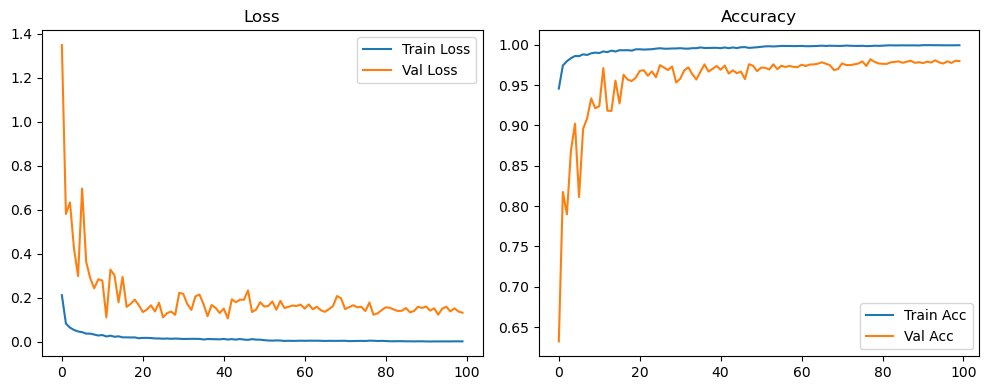

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3837, Acc: 0.8864 | Val Loss: 3.4570, Acc: 0.2574


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1624, Acc: 0.9519 | Val Loss: 2.2260, Acc: 0.3416


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1357, Acc: 0.9599 | Val Loss: 1.8243, Acc: 0.4226


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1199, Acc: 0.9642 | Val Loss: 1.6740, Acc: 0.4830


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1159, Acc: 0.9651 | Val Loss: 1.8757, Acc: 0.4374


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1040, Acc: 0.9685 | Val Loss: 1.2389, Acc: 0.5773


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9706 | Val Loss: 0.9086, Acc: 0.6798


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9705 | Val Loss: 0.8653, Acc: 0.6783


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9714 | Val Loss: 1.2967, Acc: 0.5683


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9730 | Val Loss: 1.3884, Acc: 0.5783


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9738 | Val Loss: 1.3303, Acc: 0.5710


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9754 | Val Loss: 0.7046, Acc: 0.7333


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9751 | Val Loss: 1.4035, Acc: 0.5345


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9756 | Val Loss: 1.3745, Acc: 0.5766


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9773 | Val Loss: 1.4003, Acc: 0.5748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9783 | Val Loss: 1.2555, Acc: 0.5939


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9772 | Val Loss: 1.0373, Acc: 0.6813


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9786 | Val Loss: 1.2190, Acc: 0.5985


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9781 | Val Loss: 0.8275, Acc: 0.7084


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9783 | Val Loss: 1.0143, Acc: 0.6526


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0680, Acc: 0.9781 | Val Loss: 1.0554, Acc: 0.6484


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9792 | Val Loss: 0.8006, Acc: 0.7266


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9806 | Val Loss: 1.2736, Acc: 0.5868


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.9600, Acc: 0.6848


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9803 | Val Loss: 1.5122, Acc: 0.5557


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9810 | Val Loss: 1.2274, Acc: 0.5987


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9807 | Val Loss: 1.0613, Acc: 0.6412


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9812 | Val Loss: 1.3283, Acc: 0.5923


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9820 | Val Loss: 0.8678, Acc: 0.6855


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9817 | Val Loss: 1.1773, Acc: 0.5844


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9813 | Val Loss: 0.7963, Acc: 0.6943


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9827 | Val Loss: 1.0619, Acc: 0.6195


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 1.0115, Acc: 0.6446


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9836 | Val Loss: 0.7744, Acc: 0.7107


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9823 | Val Loss: 0.7043, Acc: 0.7282


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9825 | Val Loss: 0.7337, Acc: 0.7150


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9823 | Val Loss: 0.8145, Acc: 0.7193


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9826 | Val Loss: 0.5936, Acc: 0.7679


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9831 | Val Loss: 0.6208, Acc: 0.7586


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.6218, Acc: 0.7646


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9844 | Val Loss: 0.8454, Acc: 0.6711


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.6232, Acc: 0.7561


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9832 | Val Loss: 0.9455, Acc: 0.6276


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9833 | Val Loss: 0.6812, Acc: 0.7220


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9853 | Val Loss: 0.5744, Acc: 0.7553


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9847 | Val Loss: 0.7766, Acc: 0.6993


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9844 | Val Loss: 0.7600, Acc: 0.6798


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9840 | Val Loss: 0.8214, Acc: 0.6741


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9847 | Val Loss: 0.7635, Acc: 0.6629


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9845 | Val Loss: 0.6971, Acc: 0.6973


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 0.5518, Acc: 0.7710


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.6695, Acc: 0.7096


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9872 | Val Loss: 0.5210, Acc: 0.7817


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9867 | Val Loss: 0.4104, Acc: 0.8452


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.6422, Acc: 0.7382


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.4625, Acc: 0.8191


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.7404, Acc: 0.6861


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9868 | Val Loss: 0.4922, Acc: 0.7991


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9871 | Val Loss: 0.7388, Acc: 0.6731


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.5388, Acc: 0.7792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9882 | Val Loss: 0.7159, Acc: 0.6873


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9877 | Val Loss: 0.5690, Acc: 0.7663


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.5838, Acc: 0.7562


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9876 | Val Loss: 0.5001, Acc: 0.7887


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9882 | Val Loss: 0.5788, Acc: 0.7533


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.5361, Acc: 0.7668


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9878 | Val Loss: 0.5590, Acc: 0.7563


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.5981, Acc: 0.7472


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.5854, Acc: 0.7478


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9881 | Val Loss: 0.5214, Acc: 0.7907


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.4832, Acc: 0.8028


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.6436, Acc: 0.7321


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.6414, Acc: 0.7103


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9888 | Val Loss: 0.5725, Acc: 0.7524


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.5078, Acc: 0.7977


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 0.4412, Acc: 0.8299


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.5688, Acc: 0.7414


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9885 | Val Loss: 0.5780, Acc: 0.7495


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.4903, Acc: 0.7941


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.5076, Acc: 0.7931


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.5371, Acc: 0.7816


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.5056, Acc: 0.7908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.5633, Acc: 0.7498


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9897 | Val Loss: 0.5411, Acc: 0.7800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.5472, Acc: 0.7762


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.5124, Acc: 0.7915


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 0.4669, Acc: 0.8252


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.4833, Acc: 0.8068


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.5091, Acc: 0.7842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9903 | Val Loss: 0.4956, Acc: 0.7977


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.5584, Acc: 0.7602


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.5198, Acc: 0.7884


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.5185, Acc: 0.7924


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.5098, Acc: 0.8019


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.5184, Acc: 0.7917


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.5475, Acc: 0.7667


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9903 | Val Loss: 0.4795, Acc: 0.8249


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9904 | Val Loss: 0.4838, Acc: 0.8117


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.5339, Acc: 0.7841


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.4963, Acc: 0.8038


Final Test Loss: 0.4927 Accuracy: 0.8047


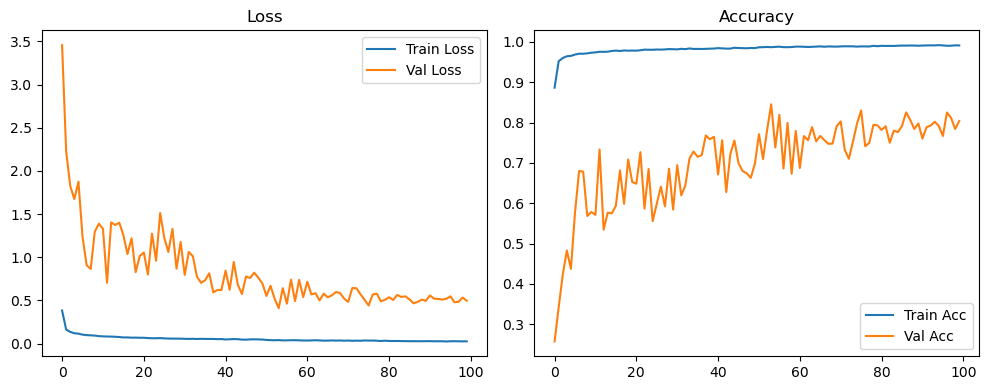

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1673, Acc: 0.9590 | Val Loss: 0.1674, Acc: 0.9504


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.1529, Acc: 0.9508


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1436, Acc: 0.9565


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.0686, Acc: 0.9792


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0560, Acc: 0.9838


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0549, Acc: 0.9834


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1102, Acc: 0.9691


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.0893, Acc: 0.9756


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0562, Acc: 0.9865


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0526, Acc: 0.9868


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0539, Acc: 0.9861


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0681, Acc: 0.9818


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0595, Acc: 0.9845


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0514, Acc: 0.9876


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0581, Acc: 0.9859


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0577, Acc: 0.9864


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0710, Acc: 0.9854


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1002, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0620, Acc: 0.9869


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9977 | Val Loss: 0.0638, Acc: 0.9868


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0521, Acc: 0.9878


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0599, Acc: 0.9881


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0780, Acc: 0.9855


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0847, Acc: 0.9838


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0661, Acc: 0.9866


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0598, Acc: 0.9887


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0823, Acc: 0.9858


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0808, Acc: 0.9838


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0678, Acc: 0.9880


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1046, Acc: 0.9802


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0752, Acc: 0.9881


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0786, Acc: 0.9858


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0721, Acc: 0.9844


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0675, Acc: 0.9881


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0792, Acc: 0.9863


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0640, Acc: 0.9889


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0754, Acc: 0.9868


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0712, Acc: 0.9881


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0760, Acc: 0.9881


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0693, Acc: 0.9881


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0700, Acc: 0.9876


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0714, Acc: 0.9893


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0798, Acc: 0.9874


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0921, Acc: 0.9868


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0882, Acc: 0.9866


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0807, Acc: 0.9867


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0744, Acc: 0.9878


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0944, Acc: 0.9862


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0852, Acc: 0.9874


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0807, Acc: 0.9862


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0692, Acc: 0.9886


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9892


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0658, Acc: 0.9896


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0754, Acc: 0.9887


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0686, Acc: 0.9893


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0662, Acc: 0.9892


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0672, Acc: 0.9895


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0686, Acc: 0.9896


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0666, Acc: 0.9902


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0654, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0680, Acc: 0.9895


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0648, Acc: 0.9900


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0667, Acc: 0.9896


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0671, Acc: 0.9898


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9896


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9900


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0676, Acc: 0.9897


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0728, Acc: 0.9892


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0705, Acc: 0.9899


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0702, Acc: 0.9897


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9902


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0692, Acc: 0.9895


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9904


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0637, Acc: 0.9902


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9898


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9908


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0683, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0669, Acc: 0.9894


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9905


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0687, Acc: 0.9892


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9890


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0699, Acc: 0.9896


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0669, Acc: 0.9895


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9893


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0692, Acc: 0.9898


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0687, Acc: 0.9900


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0664, Acc: 0.9893


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0675, Acc: 0.9897


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0695, Acc: 0.9896


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9902


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9901


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9906


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9902


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0698, Acc: 0.9894


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0688, Acc: 0.9901


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9904


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9908


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0658, Acc: 0.9905


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9901


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9906


Final Test Loss: 0.0606 Accuracy: 0.9918


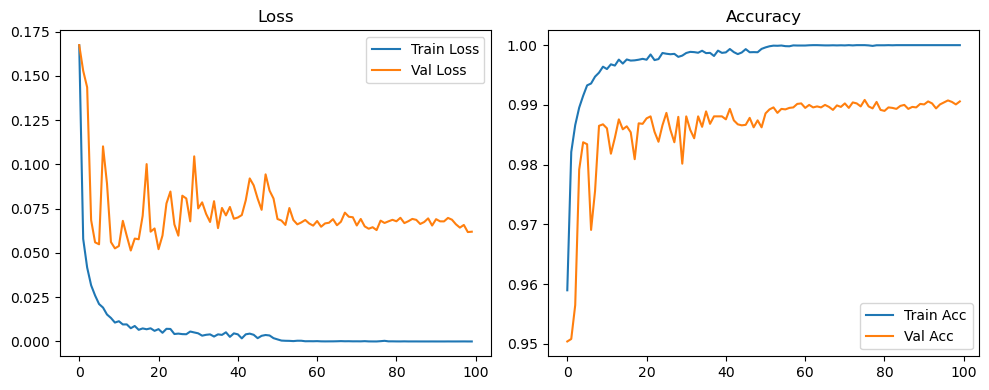

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2123, Acc: 0.9465 | Val Loss: 1.2526, Acc: 0.6223


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9747 | Val Loss: 0.5745, Acc: 0.8205


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9796 | Val Loss: 0.3821, Acc: 0.8693


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9824 | Val Loss: 0.5319, Acc: 0.8315


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9854 | Val Loss: 0.3550, Acc: 0.8894


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9861 | Val Loss: 0.4926, Acc: 0.8527


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.3357, Acc: 0.9012


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.2150, Acc: 0.9368


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.1731, Acc: 0.9507


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.2120, Acc: 0.9378


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.1658, Acc: 0.9546


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1437, Acc: 0.9598


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1202, Acc: 0.9668


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.1326, Acc: 0.9645


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.1826, Acc: 0.9482


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.1860, Acc: 0.9528


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.1192, Acc: 0.9701


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1392, Acc: 0.9635


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1117, Acc: 0.9712


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1348, Acc: 0.9635


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1095, Acc: 0.9716


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1298, Acc: 0.9681


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1055, Acc: 0.9762


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1470, Acc: 0.9667


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.1523, Acc: 0.9656


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.1598, Acc: 0.9634


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9947 | Val Loss: 0.0986, Acc: 0.9772


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.1189, Acc: 0.9739


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1010, Acc: 0.9791


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1039, Acc: 0.9788


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0906, Acc: 0.9802


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1395, Acc: 0.9711


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1775, Acc: 0.9623


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1116, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1241, Acc: 0.9745


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1485, Acc: 0.9708


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1396, Acc: 0.9684


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1237, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1739, Acc: 0.9643


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1660, Acc: 0.9662


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1154, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1195, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.1676, Acc: 0.9673


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9963 | Val Loss: 0.1402, Acc: 0.9717


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1474, Acc: 0.9703


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1344, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1413, Acc: 0.9722


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1168, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0857, Acc: 0.9814


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1327, Acc: 0.9718


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1484, Acc: 0.9709


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1216, Acc: 0.9748


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1402, Acc: 0.9721


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1100, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1388, Acc: 0.9741


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1038, Acc: 0.9795


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1343, Acc: 0.9735


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1444, Acc: 0.9732


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1336, Acc: 0.9752


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1359, Acc: 0.9760


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1306, Acc: 0.9758


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1114, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1166, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1218, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1337, Acc: 0.9767


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1034, Acc: 0.9809


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1315, Acc: 0.9776


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1277, Acc: 0.9774


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1301, Acc: 0.9769


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1385, Acc: 0.9752


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1424, Acc: 0.9760


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1475, Acc: 0.9752


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1365, Acc: 0.9764


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1225, Acc: 0.9785


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1270, Acc: 0.9780


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1124, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1391, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1181, Acc: 0.9793


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1139, Acc: 0.9795


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1105, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1201, Acc: 0.9796


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1071, Acc: 0.9811


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1082, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1082, Acc: 0.9824


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1286, Acc: 0.9787


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1211, Acc: 0.9793


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1075, Acc: 0.9817


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1144, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1261, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1218, Acc: 0.9805


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1291, Acc: 0.9786


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1176, Acc: 0.9805


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1237, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1216, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1234, Acc: 0.9801


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1476, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1310, Acc: 0.9785


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1295, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1133, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1053, Acc: 0.9832


Final Test Loss: 0.1157 Accuracy: 0.9809


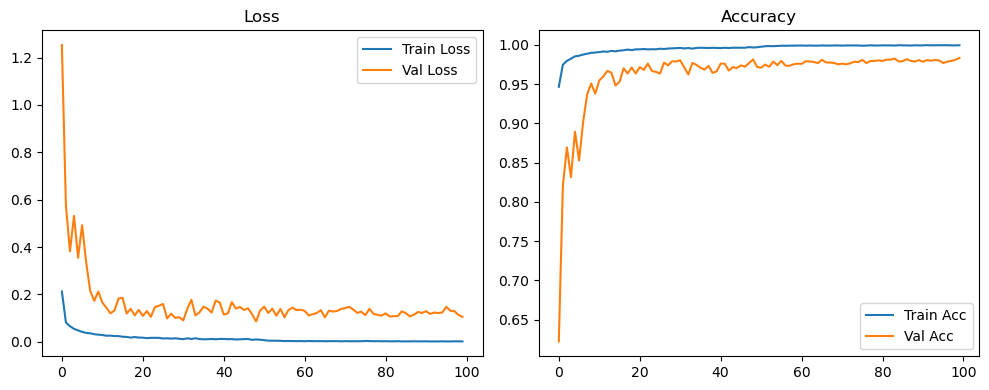

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3831, Acc: 0.8866 | Val Loss: 3.5352, Acc: 0.2436


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1624, Acc: 0.9522 | Val Loss: 2.4105, Acc: 0.3512


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9596 | Val Loss: 2.4442, Acc: 0.3513


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1208, Acc: 0.9646 | Val Loss: 1.8312, Acc: 0.4494


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9655 | Val Loss: 1.1736, Acc: 0.5961


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9687 | Val Loss: 1.9399, Acc: 0.4556


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9704 | Val Loss: 1.6112, Acc: 0.5082


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0959, Acc: 0.9707 | Val Loss: 0.7839, Acc: 0.6977


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0917, Acc: 0.9718 | Val Loss: 0.8967, Acc: 0.6679


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9735 | Val Loss: 1.2717, Acc: 0.6163


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9734 | Val Loss: 1.0411, Acc: 0.6292


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9756 | Val Loss: 0.7648, Acc: 0.7099


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9756 | Val Loss: 1.7454, Acc: 0.4821


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9760 | Val Loss: 1.3846, Acc: 0.5832


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9770 | Val Loss: 0.8972, Acc: 0.6840


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9776 | Val Loss: 1.0109, Acc: 0.6498


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9765 | Val Loss: 1.2025, Acc: 0.6177


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9799 | Val Loss: 1.4640, Acc: 0.5602


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9776 | Val Loss: 0.8840, Acc: 0.6833


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9790 | Val Loss: 1.0746, Acc: 0.6302


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9779 | Val Loss: 1.0475, Acc: 0.6235


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9791 | Val Loss: 0.7373, Acc: 0.7152


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9803 | Val Loss: 1.0633, Acc: 0.6425


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9801 | Val Loss: 0.7294, Acc: 0.7275


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9812 | Val Loss: 0.9524, Acc: 0.6462


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9804 | Val Loss: 1.1290, Acc: 0.6280


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9805 | Val Loss: 0.8123, Acc: 0.6735


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9808 | Val Loss: 0.7297, Acc: 0.7155


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9812 | Val Loss: 0.7947, Acc: 0.6805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9818 | Val Loss: 0.9423, Acc: 0.6494


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9818 | Val Loss: 0.5730, Acc: 0.7638


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9823 | Val Loss: 0.7927, Acc: 0.6891


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9819 | Val Loss: 0.5853, Acc: 0.7678


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9820 | Val Loss: 0.6895, Acc: 0.7334


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9821 | Val Loss: 0.5086, Acc: 0.7876


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9830 | Val Loss: 0.6187, Acc: 0.7454


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.5313, Acc: 0.7769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9830 | Val Loss: 0.5104, Acc: 0.7951


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9832 | Val Loss: 0.6044, Acc: 0.7455


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.5351, Acc: 0.7750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9843 | Val Loss: 0.5990, Acc: 0.7550


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9836 | Val Loss: 0.4106, Acc: 0.8377


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9836 | Val Loss: 0.5317, Acc: 0.7852


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9835 | Val Loss: 0.5519, Acc: 0.7665


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9840 | Val Loss: 0.4321, Acc: 0.8362


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9841 | Val Loss: 0.6727, Acc: 0.7036


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9852 | Val Loss: 0.6856, Acc: 0.7053


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9832 | Val Loss: 0.5713, Acc: 0.7601


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9847 | Val Loss: 0.5084, Acc: 0.7830


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.5575, Acc: 0.7537


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.3980, Acc: 0.8396


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.5569, Acc: 0.7513


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9883 | Val Loss: 0.4666, Acc: 0.8008


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9874 | Val Loss: 0.4527, Acc: 0.8064


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9892 | Val Loss: 0.4392, Acc: 0.8150


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 0.4637, Acc: 0.8035


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9883 | Val Loss: 0.4155, Acc: 0.8281


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9879 | Val Loss: 0.4094, Acc: 0.8265


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9889 | Val Loss: 0.4677, Acc: 0.7958


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9889 | Val Loss: 0.4510, Acc: 0.8099


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.4773, Acc: 0.7960


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.4214, Acc: 0.8315


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.4099, Acc: 0.8363


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.3795, Acc: 0.8532


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.4387, Acc: 0.8166


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9893 | Val Loss: 0.4776, Acc: 0.7888


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.4804, Acc: 0.7903


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9901 | Val Loss: 0.4541, Acc: 0.8148


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.4576, Acc: 0.8085


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.4751, Acc: 0.7947


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.4856, Acc: 0.8003


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.5111, Acc: 0.7796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.4788, Acc: 0.7950


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.4597, Acc: 0.8017


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.4167, Acc: 0.8397


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.4078, Acc: 0.8383


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9902 | Val Loss: 0.4547, Acc: 0.8082


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.5222, Acc: 0.7676


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.4406, Acc: 0.8116


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.4183, Acc: 0.8337


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9900 | Val Loss: 0.4308, Acc: 0.8282


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.4655, Acc: 0.8030


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.4423, Acc: 0.8142


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9899 | Val Loss: 0.3864, Acc: 0.8574


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.4870, Acc: 0.7993


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.5237, Acc: 0.7672


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.4225, Acc: 0.8338


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9903 | Val Loss: 0.4557, Acc: 0.8185


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.4878, Acc: 0.8011


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.4363, Acc: 0.8287


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.4910, Acc: 0.8021


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9900 | Val Loss: 0.4276, Acc: 0.8386


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9905 | Val Loss: 0.4442, Acc: 0.8273


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.4381, Acc: 0.8369


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.4886, Acc: 0.7950


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.5597, Acc: 0.7446


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9906 | Val Loss: 0.5073, Acc: 0.7917


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9902 | Val Loss: 0.4847, Acc: 0.7956


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.4993, Acc: 0.7893


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.4366, Acc: 0.8325


Final Test Loss: 0.4317 Accuracy: 0.8360


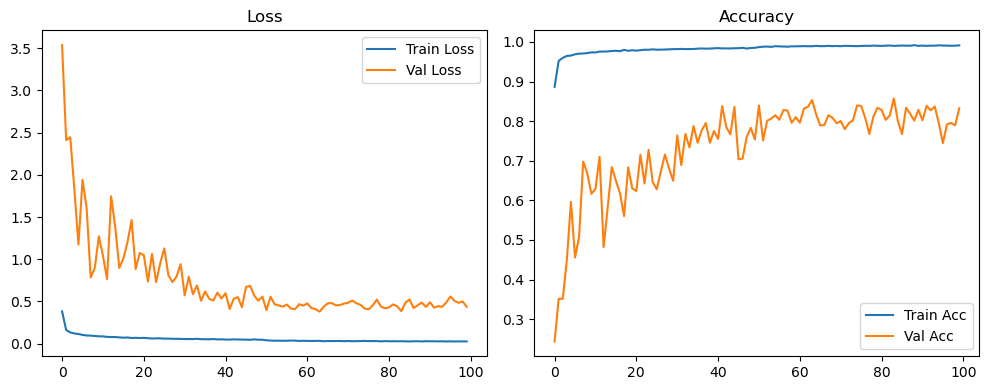

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2025, Acc: 0.9617 | Val Loss: 0.2757, Acc: 0.9177


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9836 | Val Loss: 0.2667, Acc: 0.9112


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9881 | Val Loss: 0.0936, Acc: 0.9699


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.0609, Acc: 0.9801


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0508, Acc: 0.9840


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0517, Acc: 0.9848


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0597, Acc: 0.9831


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0570, Acc: 0.9831


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0487, Acc: 0.9857


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0624, Acc: 0.9822


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0610, Acc: 0.9828


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0787, Acc: 0.9777


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0619, Acc: 0.9846


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0536, Acc: 0.9870


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0594, Acc: 0.9855


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9976 | Val Loss: 0.0577, Acc: 0.9861


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0618, Acc: 0.9853


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0682, Acc: 0.9831


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0689, Acc: 0.9830


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0650, Acc: 0.9832


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0502, Acc: 0.9874


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0625, Acc: 0.9852


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0611, Acc: 0.9870


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0675, Acc: 0.9841


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0616, Acc: 0.9854


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0874, Acc: 0.9808


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0676, Acc: 0.9865


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0579, Acc: 0.9876


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0490, Acc: 0.9879


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0649, Acc: 0.9848


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0528, Acc: 0.9883


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0741, Acc: 0.9849


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0547, Acc: 0.9873


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0579, Acc: 0.9882


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0620, Acc: 0.9882


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0721, Acc: 0.9854


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0681, Acc: 0.9862


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0572, Acc: 0.9886


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0734, Acc: 0.9867


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0597, Acc: 0.9865


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0616, Acc: 0.9890


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0671, Acc: 0.9876


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0639, Acc: 0.9878


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0585, Acc: 0.9892


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0576, Acc: 0.9894


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0765, Acc: 0.9843


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0653, Acc: 0.9882


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0621, Acc: 0.9883


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0573, Acc: 0.9889


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0629, Acc: 0.9885


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0559, Acc: 0.9890


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0647, Acc: 0.9877


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0577, Acc: 0.9900


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0623, Acc: 0.9872


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0663, Acc: 0.9880


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0694, Acc: 0.9874


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0760, Acc: 0.9868


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0682, Acc: 0.9883


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0729, Acc: 0.9871


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0714, Acc: 0.9877


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0726, Acc: 0.9885


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0679, Acc: 0.9879


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0581, Acc: 0.9902


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0762, Acc: 0.9879


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0704, Acc: 0.9882


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0745, Acc: 0.9875


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0642, Acc: 0.9887


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0802, Acc: 0.9870


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0784, Acc: 0.9866


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0679, Acc: 0.9878


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0731, Acc: 0.9875


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0708, Acc: 0.9889


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0719, Acc: 0.9881


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0703, Acc: 0.9872


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0704, Acc: 0.9878


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0709, Acc: 0.9874


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0686, Acc: 0.9887


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0728, Acc: 0.9870


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0664, Acc: 0.9888


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0790, Acc: 0.9869


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0724, Acc: 0.9880


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0850, Acc: 0.9863


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0745, Acc: 0.9861


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0671, Acc: 0.9893


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0636, Acc: 0.9901


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0706, Acc: 0.9872


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0759, Acc: 0.9881


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0730, Acc: 0.9888


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0735, Acc: 0.9883


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0732, Acc: 0.9881


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0666, Acc: 0.9891


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0649, Acc: 0.9900


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0698, Acc: 0.9889


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0673, Acc: 0.9879


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0758, Acc: 0.9871


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0679, Acc: 0.9880


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9879


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0637, Acc: 0.9895


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0697, Acc: 0.9886


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0701, Acc: 0.9890


Final Test Loss: 0.0725 Accuracy: 0.9894


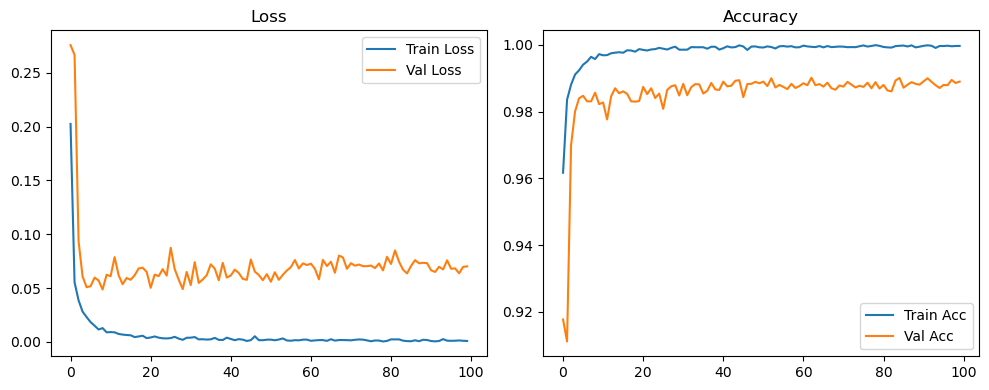

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2600, Acc: 0.9454 | Val Loss: 1.3718, Acc: 0.5663


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0842, Acc: 0.9750 | Val Loss: 0.4983, Acc: 0.8327


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9797 | Val Loss: 0.5838, Acc: 0.8126


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9831 | Val Loss: 0.5712, Acc: 0.8063


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9843 | Val Loss: 0.5991, Acc: 0.8037


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9864 | Val Loss: 0.7967, Acc: 0.7600


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.3379, Acc: 0.8957


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.2576, Acc: 0.9162


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.3921, Acc: 0.8805


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9901 | Val Loss: 0.3649, Acc: 0.9033


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9902 | Val Loss: 0.5117, Acc: 0.8730


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.3508, Acc: 0.8962


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.7560, Acc: 0.8027


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.3290, Acc: 0.9097


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.5514, Acc: 0.8677


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.4847, Acc: 0.8824


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.2881, Acc: 0.9229


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.3121, Acc: 0.9126


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.3678, Acc: 0.9043


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.6179, Acc: 0.8520


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.3889, Acc: 0.9042


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.2534, Acc: 0.9334


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.2923, Acc: 0.9258


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.2768, Acc: 0.9294


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.3841, Acc: 0.9054


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.3775, Acc: 0.9129


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.2270, Acc: 0.9471


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.2496, Acc: 0.9403


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.2020, Acc: 0.9506


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.2554, Acc: 0.9423


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.2426, Acc: 0.9421


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.3652, Acc: 0.9165


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.2480, Acc: 0.9434


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.2680, Acc: 0.9374


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.2610, Acc: 0.9423


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.2220, Acc: 0.9486


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1714, Acc: 0.9617


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1996, Acc: 0.9573


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.2158, Acc: 0.9531


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.2011, Acc: 0.9542


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.2736, Acc: 0.9403


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1882, Acc: 0.9572


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.3168, Acc: 0.9309


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.2593, Acc: 0.9427


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.2814, Acc: 0.9402


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1801, Acc: 0.9588


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.2423, Acc: 0.9496


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.2109, Acc: 0.9552


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.2298, Acc: 0.9522


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.1357, Acc: 0.9718


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.2298, Acc: 0.9530


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1930, Acc: 0.9573


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.2521, Acc: 0.9471


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.2150, Acc: 0.9548


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.2112, Acc: 0.9574


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.2053, Acc: 0.9577


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.2271, Acc: 0.9527


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1770, Acc: 0.9628


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1387, Acc: 0.9709


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.2451, Acc: 0.9508


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1512, Acc: 0.9678


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1507, Acc: 0.9692


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.2318, Acc: 0.9525


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.2342, Acc: 0.9545


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1651, Acc: 0.9677


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1804, Acc: 0.9652


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1075, Acc: 0.9776


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1802, Acc: 0.9646


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1579, Acc: 0.9679


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.2069, Acc: 0.9589


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1489, Acc: 0.9703


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.2038, Acc: 0.9608


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.2107, Acc: 0.9591


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1647, Acc: 0.9655


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9978 | Val Loss: 0.1674, Acc: 0.9700


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1070, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1329, Acc: 0.9738


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1726, Acc: 0.9672


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9983 | Val Loss: 0.1214, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1409, Acc: 0.9748


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1346, Acc: 0.9745


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1726, Acc: 0.9687


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1390, Acc: 0.9739


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1830, Acc: 0.9651


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.1517, Acc: 0.9716


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1871, Acc: 0.9683


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0979, Acc: 0.9823


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1463, Acc: 0.9730


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.1539, Acc: 0.9706


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9977 | Val Loss: 0.1049, Acc: 0.9798


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1415, Acc: 0.9741


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1520, Acc: 0.9733


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1291, Acc: 0.9748


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1205, Acc: 0.9785


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1127, Acc: 0.9792


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1408, Acc: 0.9748


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1229, Acc: 0.9785


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1556, Acc: 0.9722


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0992, Acc: 0.9812


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1088, Acc: 0.9816


Final Test Loss: 0.1310 Accuracy: 0.9783


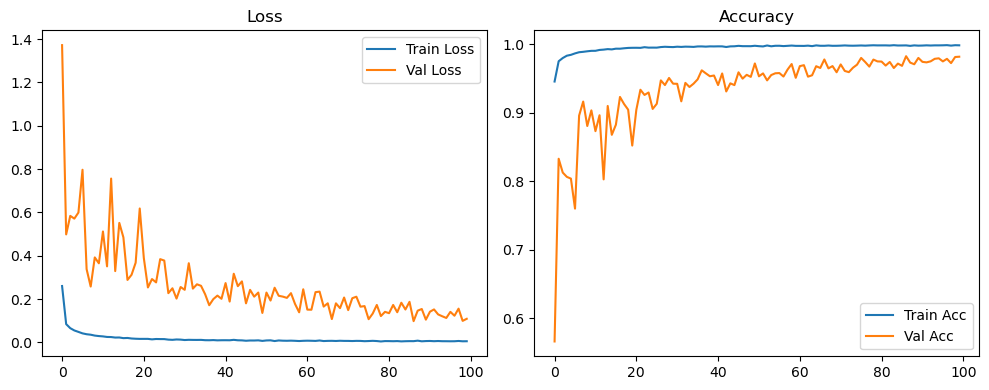

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4721, Acc: 0.8692 | Val Loss: 4.1338, Acc: 0.1788


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1730, Acc: 0.9490 | Val Loss: 3.6708, Acc: 0.2203


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1384, Acc: 0.9579 | Val Loss: 3.2387, Acc: 0.2585


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1224, Acc: 0.9634 | Val Loss: 3.0368, Acc: 0.2863


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1137, Acc: 0.9665 | Val Loss: 2.7356, Acc: 0.3226


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1055, Acc: 0.9686 | Val Loss: 3.4880, Acc: 0.2748


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0993, Acc: 0.9698 | Val Loss: 2.8007, Acc: 0.3372


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0969, Acc: 0.9703 | Val Loss: 3.0459, Acc: 0.3003


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0929, Acc: 0.9724 | Val Loss: 3.1211, Acc: 0.2867


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9740 | Val Loss: 3.5857, Acc: 0.2815


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9729 | Val Loss: 2.9784, Acc: 0.3360


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9746 | Val Loss: 1.7567, Acc: 0.4843


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9749 | Val Loss: 3.4294, Acc: 0.3139


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9755 | Val Loss: 3.1871, Acc: 0.3438


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0766, Acc: 0.9759 | Val Loss: 2.5361, Acc: 0.3947


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9767 | Val Loss: 2.5814, Acc: 0.3741


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0740, Acc: 0.9767 | Val Loss: 2.6401, Acc: 0.3767


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9780 | Val Loss: 2.6968, Acc: 0.3465


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9785 | Val Loss: 2.0964, Acc: 0.4512


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9799 | Val Loss: 2.4682, Acc: 0.3883


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9782 | Val Loss: 2.3435, Acc: 0.4268


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9792 | Val Loss: 1.7709, Acc: 0.4998


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9803 | Val Loss: 1.9506, Acc: 0.4705


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9793 | Val Loss: 1.9839, Acc: 0.4571


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0659, Acc: 0.9794 | Val Loss: 1.9276, Acc: 0.4622


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 2.1297, Acc: 0.4666


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9808 | Val Loss: 1.5580, Acc: 0.5291


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9807 | Val Loss: 1.3898, Acc: 0.5673


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9823 | Val Loss: 1.0384, Acc: 0.6717


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9812 | Val Loss: 1.3999, Acc: 0.5655


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9809 | Val Loss: 1.4174, Acc: 0.5285


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 1.2384, Acc: 0.6297


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 1.5764, Acc: 0.5418


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9820 | Val Loss: 1.1937, Acc: 0.6122


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9827 | Val Loss: 1.3267, Acc: 0.5593


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 1.4900, Acc: 0.5108


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9816 | Val Loss: 1.3657, Acc: 0.5743


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9822 | Val Loss: 1.1234, Acc: 0.6128


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9826 | Val Loss: 1.2050, Acc: 0.6109


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 1.1451, Acc: 0.6123


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9841 | Val Loss: 1.2548, Acc: 0.5753


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9843 | Val Loss: 0.9067, Acc: 0.6701


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9840 | Val Loss: 1.4319, Acc: 0.5459


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9831 | Val Loss: 1.1734, Acc: 0.6163


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9832 | Val Loss: 1.2177, Acc: 0.6055


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 1.2288, Acc: 0.5783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9840 | Val Loss: 1.4664, Acc: 0.5424


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9826 | Val Loss: 1.0600, Acc: 0.6393


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 1.5724, Acc: 0.4895


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9841 | Val Loss: 1.6342, Acc: 0.4690


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9834 | Val Loss: 0.8218, Acc: 0.6932


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9847 | Val Loss: 0.9812, Acc: 0.6369


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 1.1655, Acc: 0.5703


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 1.0057, Acc: 0.6131


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9840 | Val Loss: 0.9784, Acc: 0.6583


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9847 | Val Loss: 0.9577, Acc: 0.6474


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9846 | Val Loss: 1.1058, Acc: 0.5507


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9852 | Val Loss: 1.0289, Acc: 0.6128


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.8960, Acc: 0.6492


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9851 | Val Loss: 0.8645, Acc: 0.6425


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 1.0611, Acc: 0.5871


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9860 | Val Loss: 0.9136, Acc: 0.6384


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.6471, Acc: 0.7455


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9856 | Val Loss: 0.7753, Acc: 0.6817


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 0.8657, Acc: 0.6889


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.8308, Acc: 0.7083


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.6843, Acc: 0.7038


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 1.2179, Acc: 0.6008


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9858 | Val Loss: 0.7828, Acc: 0.6900


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9864 | Val Loss: 0.7210, Acc: 0.7432


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9857 | Val Loss: 0.9027, Acc: 0.6386


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9854 | Val Loss: 1.0897, Acc: 0.6112


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9862 | Val Loss: 1.1226, Acc: 0.5873


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9860 | Val Loss: 1.0082, Acc: 0.6059


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9853 | Val Loss: 0.8216, Acc: 0.7013


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9856 | Val Loss: 0.6914, Acc: 0.7295


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.7614, Acc: 0.6755


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9865 | Val Loss: 0.7613, Acc: 0.7107


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.7382, Acc: 0.6842


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.5486, Acc: 0.7704


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 0.6790, Acc: 0.7329


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.9920, Acc: 0.6002


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.7668, Acc: 0.7117


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9867 | Val Loss: 0.8082, Acc: 0.6947


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9871 | Val Loss: 0.7111, Acc: 0.7099


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9868 | Val Loss: 0.6801, Acc: 0.6977


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.6762, Acc: 0.7331


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9870 | Val Loss: 0.8464, Acc: 0.6448


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9879 | Val Loss: 0.7943, Acc: 0.6775


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9860 | Val Loss: 0.6955, Acc: 0.7311


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.6057, Acc: 0.7333


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.7665, Acc: 0.6888


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.7090, Acc: 0.7162


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.6124, Acc: 0.7458


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 0.6499, Acc: 0.7086


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9873 | Val Loss: 0.5984, Acc: 0.7475


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9874 | Val Loss: 0.6388, Acc: 0.7507


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9882 | Val Loss: 0.6467, Acc: 0.7091


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.4926, Acc: 0.7879


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9872 | Val Loss: 0.6333, Acc: 0.7162


Final Test Loss: 0.6219 Accuracy: 0.7184


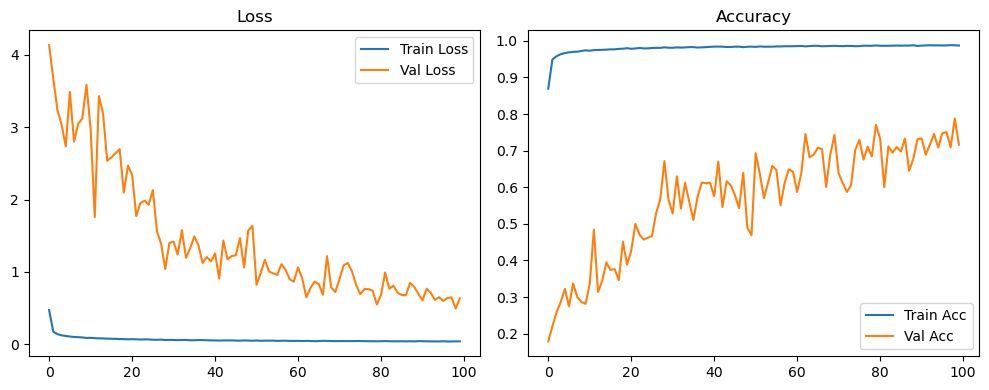

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2034, Acc: 0.9612 | Val Loss: 0.2704, Acc: 0.9198


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9841 | Val Loss: 0.2647, Acc: 0.9121


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.1060, Acc: 0.9691


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.0588, Acc: 0.9823


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9930 | Val Loss: 0.0600, Acc: 0.9817


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0595, Acc: 0.9811


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.2222, Acc: 0.9376


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0710, Acc: 0.9799


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0611, Acc: 0.9804


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0780, Acc: 0.9769


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0669, Acc: 0.9838


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0898, Acc: 0.9749


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1040, Acc: 0.9737


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0542, Acc: 0.9850


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0552, Acc: 0.9864


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0419, Acc: 0.9883


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0690, Acc: 0.9832


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0560, Acc: 0.9869


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0594, Acc: 0.9848


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0544, Acc: 0.9878


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0519, Acc: 0.9886


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0599, Acc: 0.9857


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0678, Acc: 0.9852


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0692, Acc: 0.9858


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0675, Acc: 0.9840


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0659, Acc: 0.9854


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0615, Acc: 0.9868


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0630, Acc: 0.9871


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0782, Acc: 0.9828


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0724, Acc: 0.9840


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9984 | Val Loss: 0.0518, Acc: 0.9893


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0612, Acc: 0.9877


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0844, Acc: 0.9841


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0606, Acc: 0.9877


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0607, Acc: 0.9874


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0772, Acc: 0.9867


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0688, Acc: 0.9863


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0612, Acc: 0.9878


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0615, Acc: 0.9886


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0681, Acc: 0.9861


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0727, Acc: 0.9864


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0620, Acc: 0.9884


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0758, Acc: 0.9858


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0752, Acc: 0.9872


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0564, Acc: 0.9897


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0581, Acc: 0.9892


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0641, Acc: 0.9876


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0649, Acc: 0.9874


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0626, Acc: 0.9878


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0659, Acc: 0.9888


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0535, Acc: 0.9899


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0555, Acc: 0.9892


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0530, Acc: 0.9903


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0576, Acc: 0.9892


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0563, Acc: 0.9898


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9900


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0597, Acc: 0.9902


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9902


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0677, Acc: 0.9875


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0572, Acc: 0.9906


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0575, Acc: 0.9891


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0565, Acc: 0.9898


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9906


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9903


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9897


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0753, Acc: 0.9875


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0619, Acc: 0.9885


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0653, Acc: 0.9887


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0558, Acc: 0.9904


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0557, Acc: 0.9902


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0569, Acc: 0.9894


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9901


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9888


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9900


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0691, Acc: 0.9884


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0595, Acc: 0.9901


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0588, Acc: 0.9908


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0623, Acc: 0.9899


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0662, Acc: 0.9898


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0621, Acc: 0.9898


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9904


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9902


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9904


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9902


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9902


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9906


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9902


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9900


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9904


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9902


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9895


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9905


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9901


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9901


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9901


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9906


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9909


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9909


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9908


Final Test Loss: 0.0597 Accuracy: 0.9888


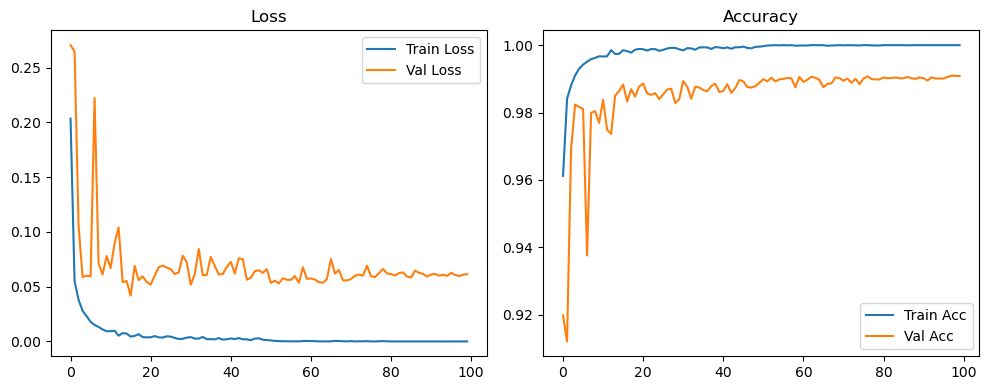

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2594, Acc: 0.9446 | Val Loss: 1.3982, Acc: 0.5978


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9747 | Val Loss: 0.6262, Acc: 0.7991


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9801 | Val Loss: 0.3315, Acc: 0.8898


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9839 | Val Loss: 0.5700, Acc: 0.8117


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9852 | Val Loss: 0.6418, Acc: 0.8148


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.6883, Acc: 0.7978


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.7733, Acc: 0.7807


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 0.3902, Acc: 0.8789


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.5169, Acc: 0.8652


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.3999, Acc: 0.8885


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9900 | Val Loss: 0.3190, Acc: 0.9102


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.4328, Acc: 0.8730


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.3600, Acc: 0.8952


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9922 | Val Loss: 0.2765, Acc: 0.9192


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.3505, Acc: 0.8962


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.2349, Acc: 0.9313


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.2261, Acc: 0.9364


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9937 | Val Loss: 0.2174, Acc: 0.9405


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.2189, Acc: 0.9392


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.2033, Acc: 0.9453


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.2182, Acc: 0.9423


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.1902, Acc: 0.9487


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.1581, Acc: 0.9579


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.3161, Acc: 0.9220


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.3055, Acc: 0.9245


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.2247, Acc: 0.9461


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.2102, Acc: 0.9493


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.1823, Acc: 0.9546


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.2061, Acc: 0.9491


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1962, Acc: 0.9517


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1950, Acc: 0.9534


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.2654, Acc: 0.9393


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1757, Acc: 0.9604


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9959 | Val Loss: 0.2100, Acc: 0.9514


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.2620, Acc: 0.9360


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.2247, Acc: 0.9482


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1764, Acc: 0.9570


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9963 | Val Loss: 0.1947, Acc: 0.9542


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1735, Acc: 0.9593


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9965 | Val Loss: 0.1731, Acc: 0.9607


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9965 | Val Loss: 0.1914, Acc: 0.9567


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1651, Acc: 0.9617


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1887, Acc: 0.9587


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.2079, Acc: 0.9527


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9963 | Val Loss: 0.2551, Acc: 0.9413


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1972, Acc: 0.9543


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.2001, Acc: 0.9526


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1420, Acc: 0.9671


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1880, Acc: 0.9594


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1490, Acc: 0.9674


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1657, Acc: 0.9626


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.2091, Acc: 0.9543


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.2201, Acc: 0.9524


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1649, Acc: 0.9641


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.2315, Acc: 0.9517


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1323, Acc: 0.9700


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1598, Acc: 0.9653


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1755, Acc: 0.9639


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1875, Acc: 0.9608


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.2284, Acc: 0.9532


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1776, Acc: 0.9634


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1767, Acc: 0.9633


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2197, Acc: 0.9548


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1736, Acc: 0.9641


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1853, Acc: 0.9634


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1910, Acc: 0.9596


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1441, Acc: 0.9698


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2324, Acc: 0.9523


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.2119, Acc: 0.9565


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2036, Acc: 0.9608


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2261, Acc: 0.9575


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.2554, Acc: 0.9519


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9984 | Val Loss: 0.1847, Acc: 0.9636


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1572, Acc: 0.9672


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1858, Acc: 0.9638


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1623, Acc: 0.9684


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.2180, Acc: 0.9598


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1500, Acc: 0.9702


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1440, Acc: 0.9718


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1715, Acc: 0.9665


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1794, Acc: 0.9650


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1490, Acc: 0.9707


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1740, Acc: 0.9655


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1516, Acc: 0.9703


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1732, Acc: 0.9668


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1660, Acc: 0.9673


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1428, Acc: 0.9708


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1512, Acc: 0.9702


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1675, Acc: 0.9673


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1734, Acc: 0.9659


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1801, Acc: 0.9649


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1972, Acc: 0.9635


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1813, Acc: 0.9659


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1843, Acc: 0.9653


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1816, Acc: 0.9657


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2123, Acc: 0.9608


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1942, Acc: 0.9643


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.2244, Acc: 0.9589


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1677, Acc: 0.9684


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1521, Acc: 0.9718


Final Test Loss: 0.1882 Accuracy: 0.9667


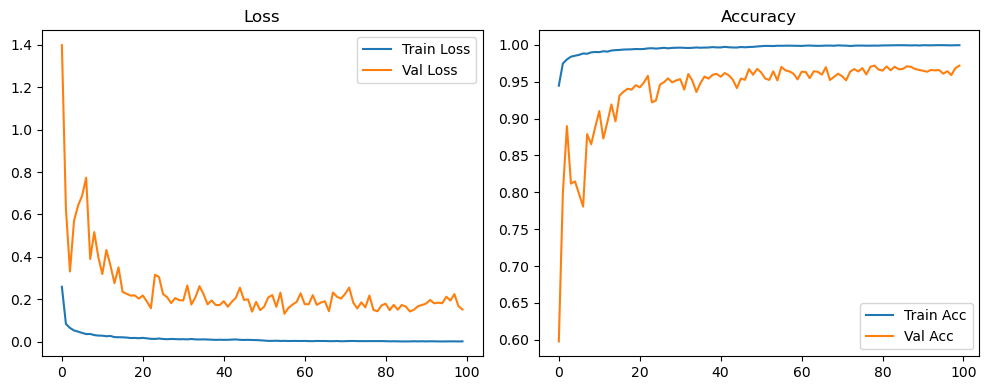

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4728, Acc: 0.8689 | Val Loss: 4.1059, Acc: 0.1674


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1729, Acc: 0.9492 | Val Loss: 3.2483, Acc: 0.2314


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1389, Acc: 0.9583 | Val Loss: 3.2662, Acc: 0.2432


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1224, Acc: 0.9641 | Val Loss: 2.1918, Acc: 0.3671


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1135, Acc: 0.9664 | Val Loss: 2.7988, Acc: 0.3142


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1055, Acc: 0.9690 | Val Loss: 3.4603, Acc: 0.2646


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 3.1432, Acc: 0.2873


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0969, Acc: 0.9707 | Val Loss: 2.2074, Acc: 0.3723


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9711 | Val Loss: 2.7898, Acc: 0.3133


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9740 | Val Loss: 3.1694, Acc: 0.2883


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0856, Acc: 0.9744 | Val Loss: 2.3778, Acc: 0.3957


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9748 | Val Loss: 1.5362, Acc: 0.5302


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9755 | Val Loss: 2.9634, Acc: 0.3561


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9761 | Val Loss: 2.3277, Acc: 0.4268


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0758, Acc: 0.9761 | Val Loss: 1.8430, Acc: 0.5168


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9768 | Val Loss: 2.3143, Acc: 0.4132


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9773 | Val Loss: 2.3527, Acc: 0.4164


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9783 | Val Loss: 2.7499, Acc: 0.3432


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9790 | Val Loss: 2.1962, Acc: 0.4462


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0678, Acc: 0.9796 | Val Loss: 2.5418, Acc: 0.3723


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9784 | Val Loss: 1.8357, Acc: 0.4862


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9799 | Val Loss: 1.2734, Acc: 0.5847


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9801 | Val Loss: 2.1033, Acc: 0.4238


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9793 | Val Loss: 1.7782, Acc: 0.4799


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9797 | Val Loss: 1.8756, Acc: 0.4582


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9802 | Val Loss: 2.3180, Acc: 0.3887


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9808 | Val Loss: 2.3187, Acc: 0.3895


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9798 | Val Loss: 1.6813, Acc: 0.4923


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9828 | Val Loss: 1.0283, Acc: 0.6581


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0606, Acc: 0.9819 | Val Loss: 1.9908, Acc: 0.4421


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9809 | Val Loss: 1.5474, Acc: 0.4962


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9816 | Val Loss: 2.2914, Acc: 0.3962


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9826 | Val Loss: 1.9924, Acc: 0.4296


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9830 | Val Loss: 1.5378, Acc: 0.5276


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9825 | Val Loss: 1.2886, Acc: 0.5488


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9825 | Val Loss: 1.4773, Acc: 0.4946


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9819 | Val Loss: 1.6394, Acc: 0.4853


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9821 | Val Loss: 1.8304, Acc: 0.4258


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9814 | Val Loss: 1.5407, Acc: 0.4713


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9828 | Val Loss: 1.3315, Acc: 0.5517


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9830 | Val Loss: 1.2212, Acc: 0.5546


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9833 | Val Loss: 1.2447, Acc: 0.5681


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9841 | Val Loss: 1.6388, Acc: 0.4956


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9833 | Val Loss: 1.3544, Acc: 0.5445


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9837 | Val Loss: 1.1575, Acc: 0.5543


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 1.1783, Acc: 0.5838


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 1.5886, Acc: 0.4677


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9835 | Val Loss: 1.5251, Acc: 0.4986


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9842 | Val Loss: 1.8230, Acc: 0.4345


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9845 | Val Loss: 1.2636, Acc: 0.5797


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9850 | Val Loss: 1.1887, Acc: 0.6008


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 1.3567, Acc: 0.5585


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9871 | Val Loss: 1.3240, Acc: 0.5588


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 1.1300, Acc: 0.5895


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9871 | Val Loss: 1.1899, Acc: 0.5866


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9871 | Val Loss: 1.0124, Acc: 0.6108


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 1.2655, Acc: 0.5537


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.9739, Acc: 0.6306


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 1.1193, Acc: 0.5701


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 1.1127, Acc: 0.5802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9872 | Val Loss: 1.1189, Acc: 0.5602


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9882 | Val Loss: 0.9861, Acc: 0.6254


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.9850, Acc: 0.6356


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.7978, Acc: 0.6857


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9883 | Val Loss: 0.9896, Acc: 0.6299


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 1.1341, Acc: 0.6194


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9878 | Val Loss: 0.9326, Acc: 0.6052


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 1.1082, Acc: 0.5987


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 1.1573, Acc: 0.5703


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9883 | Val Loss: 0.9527, Acc: 0.6647


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9883 | Val Loss: 0.9113, Acc: 0.6590


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 1.2736, Acc: 0.5269


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9878 | Val Loss: 1.0073, Acc: 0.6035


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9872 | Val Loss: 1.3693, Acc: 0.4860


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9874 | Val Loss: 1.0605, Acc: 0.6132


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.8560, Acc: 0.6570


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9881 | Val Loss: 1.0552, Acc: 0.5715


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 1.1030, Acc: 0.5813


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 1.0240, Acc: 0.5912


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9883 | Val Loss: 0.8455, Acc: 0.6705


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.8616, Acc: 0.6584


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.8534, Acc: 0.6545


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.9382, Acc: 0.6392


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 1.0989, Acc: 0.5620


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.9587, Acc: 0.6162


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 1.0526, Acc: 0.5574


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.8444, Acc: 0.6471


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9886 | Val Loss: 0.9017, Acc: 0.6370


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.9992, Acc: 0.5962


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.8495, Acc: 0.6494


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.9123, Acc: 0.6257


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9895 | Val Loss: 0.9075, Acc: 0.6229


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.9258, Acc: 0.6348


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.9006, Acc: 0.6073


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.8626, Acc: 0.6176


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.8901, Acc: 0.6388


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.8875, Acc: 0.6358


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.9463, Acc: 0.6261


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.8530, Acc: 0.6348


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.9036, Acc: 0.6313


Final Test Loss: 0.8810 Accuracy: 0.6314


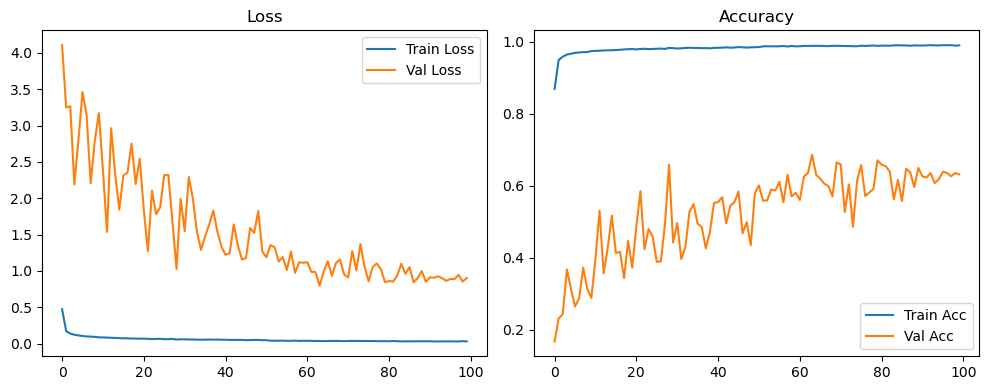

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3165, Acc: 0.9622 | Val Loss: 0.2268, Acc: 0.9471


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9849 | Val Loss: 0.1308, Acc: 0.9647


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9886 | Val Loss: 0.1224, Acc: 0.9667


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9915 | Val Loss: 0.1354, Acc: 0.9628


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9930 | Val Loss: 0.0641, Acc: 0.9814


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0916, Acc: 0.9704


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.0966, Acc: 0.9711


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1053, Acc: 0.9691


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1773, Acc: 0.9443


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.0565, Acc: 0.9817


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0671, Acc: 0.9817


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0576, Acc: 0.9848


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0471, Acc: 0.9880


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0650, Acc: 0.9808


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.0691, Acc: 0.9812


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.0722, Acc: 0.9806


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0705, Acc: 0.9822


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0601, Acc: 0.9851


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0577, Acc: 0.9858


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0589, Acc: 0.9865


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0530, Acc: 0.9860


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0676, Acc: 0.9833


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0921, Acc: 0.9782


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0818, Acc: 0.9809


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0567, Acc: 0.9863


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0582, Acc: 0.9872


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0819, Acc: 0.9810


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9781


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0668, Acc: 0.9840


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0777, Acc: 0.9828


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0511, Acc: 0.9884


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0668, Acc: 0.9844


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1329, Acc: 0.9720


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0562, Acc: 0.9878


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0518, Acc: 0.9882


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0507, Acc: 0.9882


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0572, Acc: 0.9872


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0609, Acc: 0.9875


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0527, Acc: 0.9887


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9877


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0779, Acc: 0.9838


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0610, Acc: 0.9872


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0839, Acc: 0.9825


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0755, Acc: 0.9858


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0615, Acc: 0.9882


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0674, Acc: 0.9861


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0614, Acc: 0.9870


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0619, Acc: 0.9875


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0836, Acc: 0.9823


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1276, Acc: 0.9722


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0617, Acc: 0.9880


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0672, Acc: 0.9852


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0626, Acc: 0.9878


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0609, Acc: 0.9881


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0624, Acc: 0.9862


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0628, Acc: 0.9882


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0651, Acc: 0.9878


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0801, Acc: 0.9852


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0691, Acc: 0.9858


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0718, Acc: 0.9856


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0631, Acc: 0.9879


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1543, Acc: 0.9712


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0620, Acc: 0.9885


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0765, Acc: 0.9860


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0610, Acc: 0.9875


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0613, Acc: 0.9870


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0576, Acc: 0.9891


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0583, Acc: 0.9871


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9894


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0647, Acc: 0.9873


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0781, Acc: 0.9858


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0603, Acc: 0.9870


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0918, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0608, Acc: 0.9888


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0649, Acc: 0.9888


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0608, Acc: 0.9888


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1105, Acc: 0.9813


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0695, Acc: 0.9878


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0649, Acc: 0.9868


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0606, Acc: 0.9885


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9890


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0767, Acc: 0.9862


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0606, Acc: 0.9888


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0651, Acc: 0.9880


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0756, Acc: 0.9861


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0623, Acc: 0.9881


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0707, Acc: 0.9872


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0575, Acc: 0.9899


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0691, Acc: 0.9868


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0667, Acc: 0.9853


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0642, Acc: 0.9877


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0560, Acc: 0.9896


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0596, Acc: 0.9882


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0766, Acc: 0.9850


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0648, Acc: 0.9871


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0636, Acc: 0.9883


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0666, Acc: 0.9881


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0691, Acc: 0.9878


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0641, Acc: 0.9882


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0627, Acc: 0.9888


Final Test Loss: 0.0599 Accuracy: 0.9876


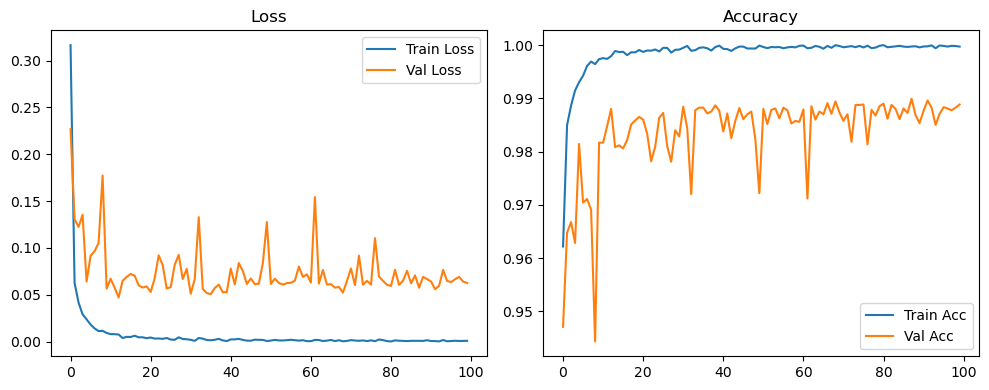

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3952, Acc: 0.9397 | Val Loss: 1.6116, Acc: 0.3638


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0988, Acc: 0.9743 | Val Loss: 1.4686, Acc: 0.5012


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9782 | Val Loss: 1.3378, Acc: 0.5513


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9814 | Val Loss: 1.7268, Acc: 0.4699


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9836 | Val Loss: 2.0863, Acc: 0.4090


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9853 | Val Loss: 1.6580, Acc: 0.5021


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9872 | Val Loss: 1.4982, Acc: 0.5992


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 1.3114, Acc: 0.6538


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9890 | Val Loss: 0.8435, Acc: 0.7436


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 1.0621, Acc: 0.7047


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9898 | Val Loss: 1.0602, Acc: 0.7338


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9904 | Val Loss: 1.1665, Acc: 0.7346


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 1.6397, Acc: 0.6350


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 1.1845, Acc: 0.7408


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 1.0619, Acc: 0.7225


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.9902, Acc: 0.7853


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.7676, Acc: 0.8019


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.8360, Acc: 0.7888


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9937 | Val Loss: 0.8982, Acc: 0.7562


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.6588, Acc: 0.8154


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.9349, Acc: 0.7644


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.5591, Acc: 0.8423


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.3954, Acc: 0.8873


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.7578, Acc: 0.8174


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.5955, Acc: 0.8505


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.5884, Acc: 0.8587


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.8123, Acc: 0.8177


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.4689, Acc: 0.8744


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.5369, Acc: 0.8668


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.7165, Acc: 0.8277


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.4388, Acc: 0.8840


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9955 | Val Loss: 0.6640, Acc: 0.8286


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.6249, Acc: 0.8386


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.5015, Acc: 0.8761


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9958 | Val Loss: 0.2888, Acc: 0.9235


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.2462, Acc: 0.9374


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.3189, Acc: 0.9230


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.5143, Acc: 0.8808


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.2675, Acc: 0.9343


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.3891, Acc: 0.9035


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.6194, Acc: 0.8519


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.4770, Acc: 0.8879


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.4670, Acc: 0.8852


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.6198, Acc: 0.8604


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.4511, Acc: 0.8987


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.5819, Acc: 0.8730


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.5053, Acc: 0.8880


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.3851, Acc: 0.9099


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.4100, Acc: 0.9073


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.4310, Acc: 0.9026


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9967 | Val Loss: 0.4855, Acc: 0.8950


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.3084, Acc: 0.9300


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.6357, Acc: 0.8641


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.5098, Acc: 0.8949


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.4353, Acc: 0.9107


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.3269, Acc: 0.9261


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9968 | Val Loss: 0.3932, Acc: 0.9155


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.2852, Acc: 0.9357


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.3432, Acc: 0.9237


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.3605, Acc: 0.9208


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.3126, Acc: 0.9317


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.3320, Acc: 0.9275


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.2754, Acc: 0.9381


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.5040, Acc: 0.8975


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.3954, Acc: 0.9184


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.2631, Acc: 0.9391


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.2540, Acc: 0.9435


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9973 | Val Loss: 0.2542, Acc: 0.9438


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.2772, Acc: 0.9354


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.3427, Acc: 0.9267


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.3293, Acc: 0.9331


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.4696, Acc: 0.9062


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.4341, Acc: 0.9137


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.4220, Acc: 0.9145


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9979 | Val Loss: 0.3438, Acc: 0.9309


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.3673, Acc: 0.9278


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.2653, Acc: 0.9430


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2654, Acc: 0.9481


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9978 | Val Loss: 0.3204, Acc: 0.9358


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.3557, Acc: 0.9293


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9974 | Val Loss: 0.3486, Acc: 0.9306


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.2732, Acc: 0.9432


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.2801, Acc: 0.9412


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.2152, Acc: 0.9547


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.2990, Acc: 0.9394


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2203, Acc: 0.9519


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2079, Acc: 0.9577


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.2822, Acc: 0.9412


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.2862, Acc: 0.9417


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9981 | Val Loss: 0.2912, Acc: 0.9417


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.2780, Acc: 0.9432


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2555, Acc: 0.9496


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.2837, Acc: 0.9465


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.2624, Acc: 0.9497


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.2932, Acc: 0.9447


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.5069, Acc: 0.9013


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.4603, Acc: 0.9086


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.4414, Acc: 0.9176


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.2776, Acc: 0.9421


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.2310, Acc: 0.9527


Final Test Loss: 0.2390 Accuracy: 0.9522


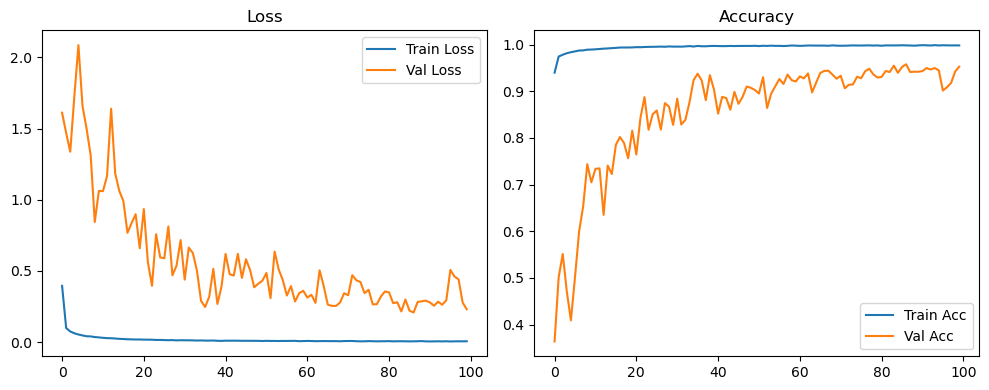

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6904, Acc: 0.8265 | Val Loss: 3.6437, Acc: 0.1490


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2276, Acc: 0.9370 | Val Loss: 3.0902, Acc: 0.2195


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1687, Acc: 0.9511 | Val Loss: 3.2392, Acc: 0.2222


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1430, Acc: 0.9574 | Val Loss: 2.7465, Acc: 0.2823


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1278, Acc: 0.9627 | Val Loss: 3.0185, Acc: 0.2597


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1159, Acc: 0.9645 | Val Loss: 3.3259, Acc: 0.2492


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1074, Acc: 0.9673 | Val Loss: 3.2961, Acc: 0.2639


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1031, Acc: 0.9695 | Val Loss: 2.9417, Acc: 0.2603


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1005, Acc: 0.9701 | Val Loss: 2.7776, Acc: 0.2972


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0956, Acc: 0.9714 | Val Loss: 3.2575, Acc: 0.2768


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0961, Acc: 0.9711 | Val Loss: 2.5286, Acc: 0.3829


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0878, Acc: 0.9734 | Val Loss: 2.3069, Acc: 0.3463


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0858, Acc: 0.9741 | Val Loss: 3.2628, Acc: 0.2966


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0851, Acc: 0.9740 | Val Loss: 2.7793, Acc: 0.3280


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0827, Acc: 0.9750 | Val Loss: 2.3252, Acc: 0.3803


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0810, Acc: 0.9751 | Val Loss: 2.9397, Acc: 0.3131


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0786, Acc: 0.9767 | Val Loss: 2.4983, Acc: 0.3780


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0756, Acc: 0.9762 | Val Loss: 2.5628, Acc: 0.3512


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0753, Acc: 0.9771 | Val Loss: 2.6670, Acc: 0.3397


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0721, Acc: 0.9783 | Val Loss: 2.4505, Acc: 0.3715


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0742, Acc: 0.9776 | Val Loss: 2.5553, Acc: 0.3630


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9788 | Val Loss: 1.8140, Acc: 0.5031


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9794 | Val Loss: 1.8461, Acc: 0.5009


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9783 | Val Loss: 2.3917, Acc: 0.4203


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0699, Acc: 0.9785 | Val Loss: 2.4310, Acc: 0.3860


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9787 | Val Loss: 2.7462, Acc: 0.3639


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0653, Acc: 0.9800 | Val Loss: 1.9685, Acc: 0.4771


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9801 | Val Loss: 1.5835, Acc: 0.5433


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9802 | Val Loss: 1.4037, Acc: 0.5873


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9800 | Val Loss: 2.5068, Acc: 0.3964


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0623, Acc: 0.9801 | Val Loss: 2.0381, Acc: 0.4688


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0615, Acc: 0.9809 | Val Loss: 1.9804, Acc: 0.4795


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9810 | Val Loss: 2.0402, Acc: 0.4726


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9817 | Val Loss: 1.6930, Acc: 0.5616


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9809 | Val Loss: 1.6447, Acc: 0.5622


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9805 | Val Loss: 2.0349, Acc: 0.4493


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 1.5876, Acc: 0.5410


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9814 | Val Loss: 1.9928, Acc: 0.4532


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9812 | Val Loss: 1.8609, Acc: 0.5052


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9819 | Val Loss: 1.5918, Acc: 0.5404


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9819 | Val Loss: 2.2831, Acc: 0.4224


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9830 | Val Loss: 1.4646, Acc: 0.5655


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9821 | Val Loss: 1.7495, Acc: 0.5239


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9825 | Val Loss: 1.4143, Acc: 0.6055


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9836 | Val Loss: 1.7537, Acc: 0.5288


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9826 | Val Loss: 2.0174, Acc: 0.4710


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9829 | Val Loss: 1.6672, Acc: 0.5386


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9829 | Val Loss: 1.4905, Acc: 0.5778


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9825 | Val Loss: 2.0914, Acc: 0.4753


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9838 | Val Loss: 1.9242, Acc: 0.4958


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9826 | Val Loss: 1.9239, Acc: 0.5042


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9840 | Val Loss: 1.5332, Acc: 0.5727


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9839 | Val Loss: 1.4801, Acc: 0.5558


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9838 | Val Loss: 1.8418, Acc: 0.4921


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 1.5677, Acc: 0.5576


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 1.4725, Acc: 0.5595


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9836 | Val Loss: 1.7172, Acc: 0.5242


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9831 | Val Loss: 1.4816, Acc: 0.5731


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9839 | Val Loss: 1.6320, Acc: 0.5285


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9829 | Val Loss: 1.2996, Acc: 0.6041


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9842 | Val Loss: 1.2834, Acc: 0.6063


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 1.6099, Acc: 0.5511


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9843 | Val Loss: 1.3507, Acc: 0.6172


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9843 | Val Loss: 0.9984, Acc: 0.7026


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9856 | Val Loss: 1.6153, Acc: 0.5635


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9856 | Val Loss: 1.2503, Acc: 0.6462


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9839 | Val Loss: 1.1509, Acc: 0.6314


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9847 | Val Loss: 1.2364, Acc: 0.6424


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 1.3363, Acc: 0.5863


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9854 | Val Loss: 1.3483, Acc: 0.6323


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9847 | Val Loss: 1.3157, Acc: 0.6037


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9845 | Val Loss: 1.6064, Acc: 0.5510


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9852 | Val Loss: 1.5420, Acc: 0.5543


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9852 | Val Loss: 1.5839, Acc: 0.5186


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 1.1894, Acc: 0.6364


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9857 | Val Loss: 1.2447, Acc: 0.6339


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9855 | Val Loss: 1.5708, Acc: 0.5553


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 1.4710, Acc: 0.5756


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 1.4892, Acc: 0.5777


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 1.2396, Acc: 0.6081


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 1.2408, Acc: 0.6502


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9855 | Val Loss: 1.3520, Acc: 0.6108


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9851 | Val Loss: 1.3064, Acc: 0.6303


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9860 | Val Loss: 1.3367, Acc: 0.6279


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9866 | Val Loss: 1.3052, Acc: 0.5974


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9857 | Val Loss: 1.1609, Acc: 0.6279


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 1.2633, Acc: 0.6162


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9852 | Val Loss: 1.3524, Acc: 0.5904


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9862 | Val Loss: 1.2179, Acc: 0.6332


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 1.1797, Acc: 0.6333


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9854 | Val Loss: 1.1133, Acc: 0.6589


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9866 | Val Loss: 0.8724, Acc: 0.6997


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 1.0717, Acc: 0.6677


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9857 | Val Loss: 1.0300, Acc: 0.6724


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9865 | Val Loss: 0.9124, Acc: 0.6905


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9863 | Val Loss: 0.8094, Acc: 0.7206


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9866 | Val Loss: 0.8148, Acc: 0.7202


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.8792, Acc: 0.7130


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 0.7765, Acc: 0.7225


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.9601, Acc: 0.6783


Final Test Loss: 0.9312 Accuracy: 0.6812


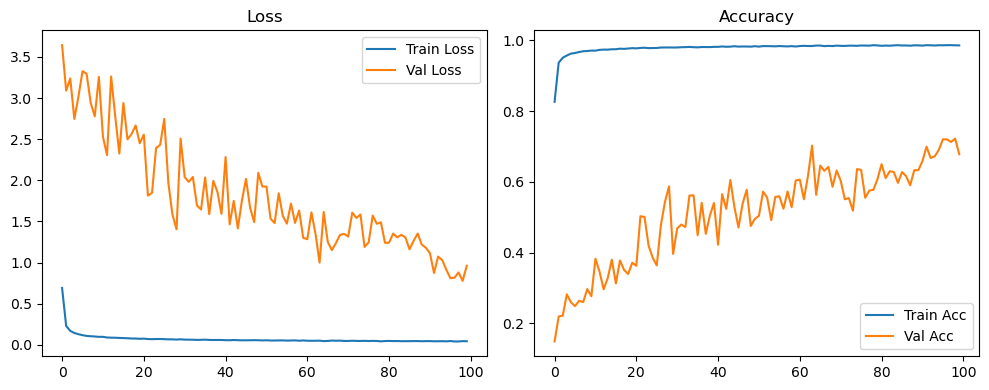

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4854, Acc: 0.9582 | Val Loss: 0.1645, Acc: 0.9748


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0874, Acc: 0.9838 | Val Loss: 0.1760, Acc: 0.9592


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9889 | Val Loss: 0.5089, Acc: 0.8287


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9912 | Val Loss: 0.0761, Acc: 0.9794


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9934 | Val Loss: 0.0738, Acc: 0.9782


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9947 | Val Loss: 0.1184, Acc: 0.9617


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9962 | Val Loss: 0.0980, Acc: 0.9705


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9969 | Val Loss: 0.0682, Acc: 0.9791


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9973 | Val Loss: 0.1093, Acc: 0.9650


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9983 | Val Loss: 0.4746, Acc: 0.8492


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9977 | Val Loss: 0.0895, Acc: 0.9715


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.0592, Acc: 0.9820


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1154, Acc: 0.9690


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0486, Acc: 0.9868


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0867, Acc: 0.9751


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1765, Acc: 0.9460


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.0437, Acc: 0.9873


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9997 | Val Loss: 0.0480, Acc: 0.9872


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0570, Acc: 0.9849


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0529, Acc: 0.9862


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.0428, Acc: 0.9875


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.1051, Acc: 0.9736


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0541, Acc: 0.9839


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0777, Acc: 0.9768


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0588, Acc: 0.9835


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0580, Acc: 0.9852


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0738, Acc: 0.9805


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0500, Acc: 0.9869


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0553, Acc: 0.9862


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0635, Acc: 0.9832


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0499, Acc: 0.9870


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0458, Acc: 0.9888


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0650, Acc: 0.9833


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1584, Acc: 0.9595


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.0479, Acc: 0.9878


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0497, Acc: 0.9877


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0565, Acc: 0.9852


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0560, Acc: 0.9861


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9673


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0778, Acc: 0.9793


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0689, Acc: 0.9824


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0658, Acc: 0.9848


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0507, Acc: 0.9883


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0644, Acc: 0.9855


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0479, Acc: 0.9890


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0499, Acc: 0.9877


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9887


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9890


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0708, Acc: 0.9840


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0661, Acc: 0.9858


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0533, Acc: 0.9882


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1017, Acc: 0.9757


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0597, Acc: 0.9859


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0521, Acc: 0.9872


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0545, Acc: 0.9882


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0709, Acc: 0.9841


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0601, Acc: 0.9866


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0552, Acc: 0.9880


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0485, Acc: 0.9892


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9898


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0568, Acc: 0.9868


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0541, Acc: 0.9882


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0529, Acc: 0.9880


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0511, Acc: 0.9879


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0590, Acc: 0.9862


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0507, Acc: 0.9883


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0502, Acc: 0.9890


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0518, Acc: 0.9891


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0536, Acc: 0.9872


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0589, Acc: 0.9856


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0537, Acc: 0.9878


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0525, Acc: 0.9883


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0630, Acc: 0.9855


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0598, Acc: 0.9858


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0592, Acc: 0.9885


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0781, Acc: 0.9821


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0604, Acc: 0.9882


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0669, Acc: 0.9852


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0580, Acc: 0.9885


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0652, Acc: 0.9867


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0568, Acc: 0.9882


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0544, Acc: 0.9885


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0948, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0636, Acc: 0.9874


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0579, Acc: 0.9878


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0631, Acc: 0.9842


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0506, Acc: 0.9884


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0544, Acc: 0.9883


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0643, Acc: 0.9872


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0602, Acc: 0.9878


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0687, Acc: 0.9877


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0870, Acc: 0.9813


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0546, Acc: 0.9893


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9892


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9891


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0575, Acc: 0.9880


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0602, Acc: 0.9872


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0957, Acc: 0.9820


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0648, Acc: 0.9849


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0562, Acc: 0.9888


Final Test Loss: 0.0576 Accuracy: 0.9871


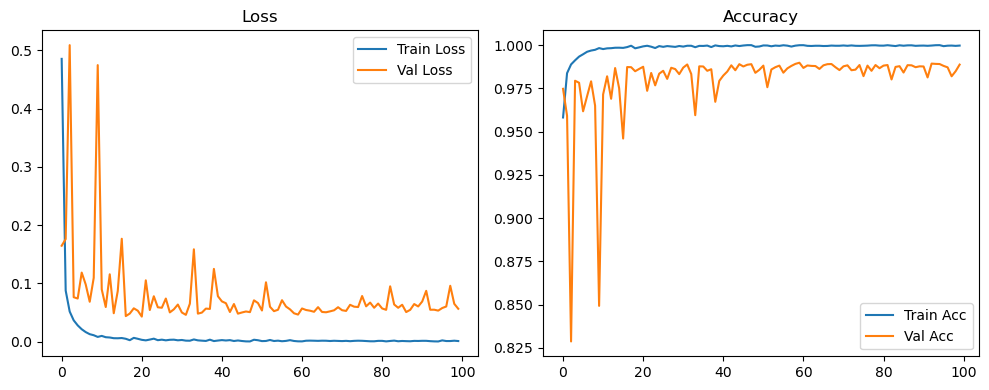

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5885, Acc: 0.9296 | Val Loss: 1.7832, Acc: 0.2977


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1352, Acc: 0.9728 | Val Loss: 1.5849, Acc: 0.4112


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0912, Acc: 0.9767 | Val Loss: 1.8942, Acc: 0.4132


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0720, Acc: 0.9799 | Val Loss: 1.7645, Acc: 0.4149


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0611, Acc: 0.9827 | Val Loss: 1.5222, Acc: 0.5092


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9836 | Val Loss: 1.5995, Acc: 0.5613


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9861 | Val Loss: 1.6032, Acc: 0.5482


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9860 | Val Loss: 1.5606, Acc: 0.5941


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9879 | Val Loss: 1.2253, Acc: 0.6304


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.9981, Acc: 0.7277


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 1.2770, Acc: 0.6399


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 1.8029, Acc: 0.5423


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 1.5310, Acc: 0.6077


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 1.2371, Acc: 0.6984


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 1.5407, Acc: 0.6372


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 1.0943, Acc: 0.7200


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 1.3309, Acc: 0.6473


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.7926, Acc: 0.7679


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 1.3905, Acc: 0.6371


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 1.3036, Acc: 0.6771


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 1.1669, Acc: 0.7163


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 1.2759, Acc: 0.6548


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 1.1587, Acc: 0.6907


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 1.0072, Acc: 0.7668


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 1.0759, Acc: 0.7867


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 1.0521, Acc: 0.7556


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9942 | Val Loss: 0.9613, Acc: 0.7612


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 1.1303, Acc: 0.7362


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.6979, Acc: 0.8322


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 1.3276, Acc: 0.6908


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.9332, Acc: 0.7631


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 1.1938, Acc: 0.7053


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 1.1161, Acc: 0.7441


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 1.4338, Acc: 0.6858


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.5845, Acc: 0.8622


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.6950, Acc: 0.8388


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.8185, Acc: 0.8197


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 1.0841, Acc: 0.7515


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.7877, Acc: 0.8166


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.5864, Acc: 0.8624


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.9582, Acc: 0.7812


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.6652, Acc: 0.8351


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.9134, Acc: 0.7959


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.8381, Acc: 0.7983


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.6142, Acc: 0.8449


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.6270, Acc: 0.8578


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.8675, Acc: 0.8125


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.5263, Acc: 0.8811


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.5840, Acc: 0.8634


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.5726, Acc: 0.8676


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.5099, Acc: 0.8796


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.6585, Acc: 0.8517


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.5563, Acc: 0.8629


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.4173, Acc: 0.9009


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.8013, Acc: 0.8293


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.6150, Acc: 0.8577


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.7966, Acc: 0.8153


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.6069, Acc: 0.8507


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.6163, Acc: 0.8525


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.6380, Acc: 0.8502


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.6160, Acc: 0.8605


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.5076, Acc: 0.8846


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.3934, Acc: 0.9087


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.4790, Acc: 0.8858


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.3754, Acc: 0.9153


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.5590, Acc: 0.8840


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.5434, Acc: 0.8781


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.4630, Acc: 0.8968


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.6036, Acc: 0.8627


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.5845, Acc: 0.8740


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.6056, Acc: 0.8837


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.6233, Acc: 0.8759


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.5636, Acc: 0.8875


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.4986, Acc: 0.8871


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.5888, Acc: 0.8777


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.5906, Acc: 0.8642


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.6543, Acc: 0.8693


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.4534, Acc: 0.9062


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.5364, Acc: 0.8793


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.3967, Acc: 0.9090


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.5852, Acc: 0.8833


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.3477, Acc: 0.9224


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.5787, Acc: 0.8784


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.6413, Acc: 0.8699


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.5764, Acc: 0.8800


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.6593, Acc: 0.8672


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.6043, Acc: 0.8903


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.7389, Acc: 0.8643


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.7135, Acc: 0.8612


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.6293, Acc: 0.8669


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.5768, Acc: 0.8826


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.4904, Acc: 0.9013


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.4212, Acc: 0.9127


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.7379, Acc: 0.8668


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.7288, Acc: 0.8593


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.7268, Acc: 0.8711


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.9600, Acc: 0.8390


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.5813, Acc: 0.8917


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.5328, Acc: 0.8948


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.4363, Acc: 0.9124


Final Test Loss: 0.4424 Accuracy: 0.9135


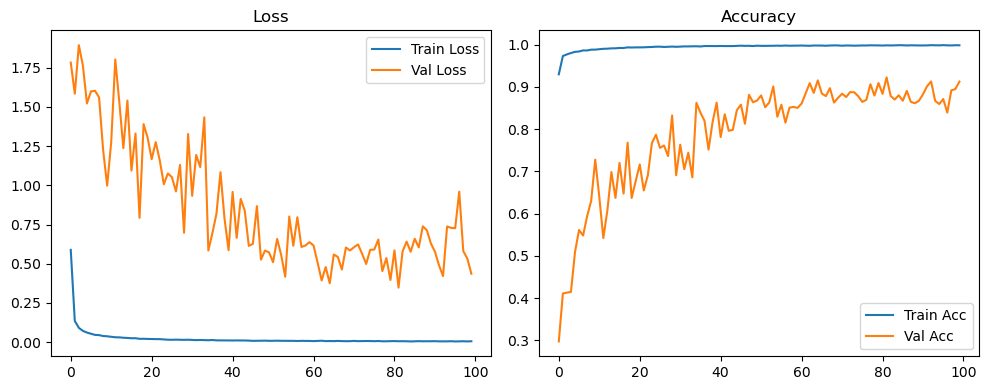

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9465, Acc: 0.7783 | Val Loss: 3.5263, Acc: 0.1135


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3352, Acc: 0.9162 | Val Loss: 3.3535, Acc: 0.2109


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2277, Acc: 0.9381 | Val Loss: 3.6173, Acc: 0.2121


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1812, Acc: 0.9487 | Val Loss: 3.3741, Acc: 0.2122


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1575, Acc: 0.9554 | Val Loss: 3.3606, Acc: 0.2143


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1398, Acc: 0.9586 | Val Loss: 3.7144, Acc: 0.2185


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1254, Acc: 0.9624 | Val Loss: 3.3945, Acc: 0.2318


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1197, Acc: 0.9646 | Val Loss: 3.2259, Acc: 0.2285


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1120, Acc: 0.9675 | Val Loss: 2.8402, Acc: 0.2501


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1049, Acc: 0.9689 | Val Loss: 2.9603, Acc: 0.2523


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1058, Acc: 0.9690 | Val Loss: 2.6485, Acc: 0.3152


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0984, Acc: 0.9716 | Val Loss: 2.7560, Acc: 0.2841


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0947, Acc: 0.9718 | Val Loss: 3.2918, Acc: 0.2765


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0930, Acc: 0.9726 | Val Loss: 2.8269, Acc: 0.3169


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0894, Acc: 0.9725 | Val Loss: 2.5224, Acc: 0.3493


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0860, Acc: 0.9742 | Val Loss: 2.8476, Acc: 0.3060


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0855, Acc: 0.9744 | Val Loss: 2.4960, Acc: 0.3437


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9747 | Val Loss: 2.2116, Acc: 0.4022


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0801, Acc: 0.9762 | Val Loss: 2.6292, Acc: 0.3514


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0780, Acc: 0.9770 | Val Loss: 2.6082, Acc: 0.3633


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0792, Acc: 0.9765 | Val Loss: 2.9339, Acc: 0.3007


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0747, Acc: 0.9776 | Val Loss: 2.0003, Acc: 0.4669


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0726, Acc: 0.9778 | Val Loss: 2.7732, Acc: 0.3344


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0743, Acc: 0.9771 | Val Loss: 2.2826, Acc: 0.4114


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9777 | Val Loss: 2.4456, Acc: 0.4061


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0701, Acc: 0.9786 | Val Loss: 2.5395, Acc: 0.3646


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0701, Acc: 0.9789 | Val Loss: 2.0487, Acc: 0.4694


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0700, Acc: 0.9790 | Val Loss: 2.1062, Acc: 0.4387


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0660, Acc: 0.9796 | Val Loss: 1.7074, Acc: 0.5220


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0697, Acc: 0.9786 | Val Loss: 2.4621, Acc: 0.3998


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0671, Acc: 0.9784 | Val Loss: 2.0060, Acc: 0.4753


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0666, Acc: 0.9796 | Val Loss: 2.3201, Acc: 0.4148


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0633, Acc: 0.9806 | Val Loss: 1.7272, Acc: 0.5375


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0630, Acc: 0.9806 | Val Loss: 2.1292, Acc: 0.4557


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0627, Acc: 0.9814 | Val Loss: 1.8653, Acc: 0.5068


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0644, Acc: 0.9802 | Val Loss: 2.5577, Acc: 0.3853


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9796 | Val Loss: 1.9141, Acc: 0.4765


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0611, Acc: 0.9808 | Val Loss: 2.3039, Acc: 0.4102


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 2.2542, Acc: 0.4406


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0613, Acc: 0.9809 | Val Loss: 2.1502, Acc: 0.4608


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9821 | Val Loss: 1.8821, Acc: 0.5017


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9816 | Val Loss: 1.9738, Acc: 0.4756


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0608, Acc: 0.9813 | Val Loss: 1.8610, Acc: 0.4892


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0601, Acc: 0.9814 | Val Loss: 1.7640, Acc: 0.5107


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0570, Acc: 0.9829 | Val Loss: 1.6851, Acc: 0.5283


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9822 | Val Loss: 1.6911, Acc: 0.5279


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9827 | Val Loss: 1.8163, Acc: 0.4948


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9824 | Val Loss: 1.6795, Acc: 0.5388


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9820 | Val Loss: 1.9693, Acc: 0.4829


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9826 | Val Loss: 1.6735, Acc: 0.5332


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0570, Acc: 0.9822 | Val Loss: 1.6008, Acc: 0.5574


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9830 | Val Loss: 1.6231, Acc: 0.5475


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 1.6539, Acc: 0.5444


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0543, Acc: 0.9829 | Val Loss: 1.9146, Acc: 0.4743


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9834 | Val Loss: 1.6304, Acc: 0.5588


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9838 | Val Loss: 1.6092, Acc: 0.5445


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9832 | Val Loss: 2.0281, Acc: 0.4715


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0545, Acc: 0.9820 | Val Loss: 1.7222, Acc: 0.5437


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9830 | Val Loss: 1.9811, Acc: 0.4985


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9836 | Val Loss: 1.8484, Acc: 0.5332


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9838 | Val Loss: 1.9696, Acc: 0.4848


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9833 | Val Loss: 1.3749, Acc: 0.5913


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9841 | Val Loss: 1.4299, Acc: 0.6023


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9837 | Val Loss: 1.5127, Acc: 0.5983


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9853 | Val Loss: 1.5837, Acc: 0.5665


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 1.4699, Acc: 0.6010


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0517, Acc: 0.9833 | Val Loss: 1.3149, Acc: 0.5943


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9841 | Val Loss: 1.8623, Acc: 0.5227


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0521, Acc: 0.9838 | Val Loss: 1.6132, Acc: 0.5517


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0499, Acc: 0.9842 | Val Loss: 1.6310, Acc: 0.5628


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9846 | Val Loss: 1.3549, Acc: 0.6025


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9853 | Val Loss: 1.6262, Acc: 0.5527


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 1.4426, Acc: 0.5663


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9840 | Val Loss: 1.5475, Acc: 0.5372


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9843 | Val Loss: 1.2555, Acc: 0.6168


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9840 | Val Loss: 1.1101, Acc: 0.6662


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 1.5083, Acc: 0.5644


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 1.3193, Acc: 0.6310


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9856 | Val Loss: 1.2919, Acc: 0.5988


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9854 | Val Loss: 1.2643, Acc: 0.5971


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9849 | Val Loss: 1.3438, Acc: 0.6054


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9855 | Val Loss: 1.2490, Acc: 0.6231


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9842 | Val Loss: 1.4276, Acc: 0.5944


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9852 | Val Loss: 1.4912, Acc: 0.5646


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 1.5020, Acc: 0.5502


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9840 | Val Loss: 1.3768, Acc: 0.5775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9846 | Val Loss: 1.2039, Acc: 0.6136


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9847 | Val Loss: 1.4164, Acc: 0.5730


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 1.3876, Acc: 0.5935


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9857 | Val Loss: 1.2112, Acc: 0.6187


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9851 | Val Loss: 1.4993, Acc: 0.5476


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9851 | Val Loss: 1.3651, Acc: 0.5709


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 1.2100, Acc: 0.6233


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 1.2915, Acc: 0.5819


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9859 | Val Loss: 1.4801, Acc: 0.5430


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9857 | Val Loss: 1.1628, Acc: 0.6302


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 1.4044, Acc: 0.5873


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 1.4205, Acc: 0.5693


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9855 | Val Loss: 1.0100, Acc: 0.6594


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9854 | Val Loss: 1.1355, Acc: 0.6298


Final Test Loss: 1.1068 Accuracy: 0.6323


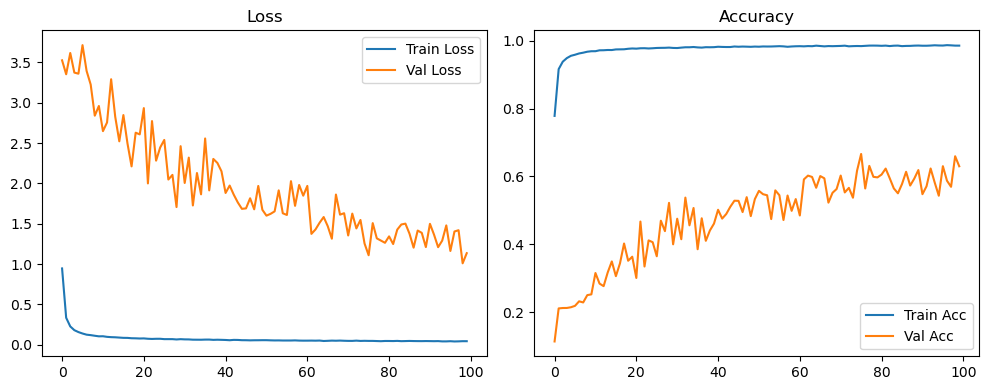

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2081, Acc: 0.9549 | Val Loss: 0.1226, Acc: 0.9652


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9837 | Val Loss: 0.1316, Acc: 0.9578


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9888 | Val Loss: 0.1897, Acc: 0.9436


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0754, Acc: 0.9763


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9934 | Val Loss: 0.1192, Acc: 0.9648


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0819, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0630, Acc: 0.9807


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1280, Acc: 0.9617


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1219, Acc: 0.9648


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0752, Acc: 0.9807


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.3049, Acc: 0.9189


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0717, Acc: 0.9812


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0827, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0691, Acc: 0.9835


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0654, Acc: 0.9834


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0839, Acc: 0.9791


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0868, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0536, Acc: 0.9857


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1083, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0969, Acc: 0.9759


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0529, Acc: 0.9875


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0554, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0980, Acc: 0.9786


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0852, Acc: 0.9820


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0563, Acc: 0.9875


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0593, Acc: 0.9880


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0623, Acc: 0.9869


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0636, Acc: 0.9872


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0723, Acc: 0.9850


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9986 | Val Loss: 0.0916, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0521, Acc: 0.9893


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0546, Acc: 0.9885


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0590, Acc: 0.9880


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0764, Acc: 0.9866


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0630, Acc: 0.9877


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0575, Acc: 0.9886


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0674, Acc: 0.9873


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0780, Acc: 0.9852


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0667, Acc: 0.9872


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0621, Acc: 0.9870


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0702, Acc: 0.9868


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0787, Acc: 0.9862


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0606, Acc: 0.9889


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0729, Acc: 0.9865


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0668, Acc: 0.9868


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0737, Acc: 0.9878


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0837, Acc: 0.9866


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0822, Acc: 0.9850


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0659, Acc: 0.9878


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0764, Acc: 0.9875


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.0975, Acc: 0.9852


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0678, Acc: 0.9893


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0662, Acc: 0.9889


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0796, Acc: 0.9862


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0679, Acc: 0.9883


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0796, Acc: 0.9859


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0759, Acc: 0.9871


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0656, Acc: 0.9894


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0824, Acc: 0.9864


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0742, Acc: 0.9888


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0667, Acc: 0.9892


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0706, Acc: 0.9875


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0716, Acc: 0.9882


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0987, Acc: 0.9844


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0758, Acc: 0.9880


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0860, Acc: 0.9869


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0785, Acc: 0.9868


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0796, Acc: 0.9881


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0839, Acc: 0.9877


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0748, Acc: 0.9876


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0706, Acc: 0.9887


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9891


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0801, Acc: 0.9875


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0839, Acc: 0.9855


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0777, Acc: 0.9877


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0884, Acc: 0.9865


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0740, Acc: 0.9887


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0862, Acc: 0.9863


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0890, Acc: 0.9870


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0842, Acc: 0.9872


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0963, Acc: 0.9875


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0732, Acc: 0.9887


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0863, Acc: 0.9878


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0795, Acc: 0.9876


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0954, Acc: 0.9857


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0896, Acc: 0.9868


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0838, Acc: 0.9868


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0810, Acc: 0.9887


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0850, Acc: 0.9881


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0967, Acc: 0.9854


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1022, Acc: 0.9871


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0909, Acc: 0.9869


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0908, Acc: 0.9861


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0873, Acc: 0.9866


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0864, Acc: 0.9878


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0759, Acc: 0.9887


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0741, Acc: 0.9898


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9898


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0680, Acc: 0.9896


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1107, Acc: 0.9857


Final Test Loss: 0.0913 Accuracy: 0.9868


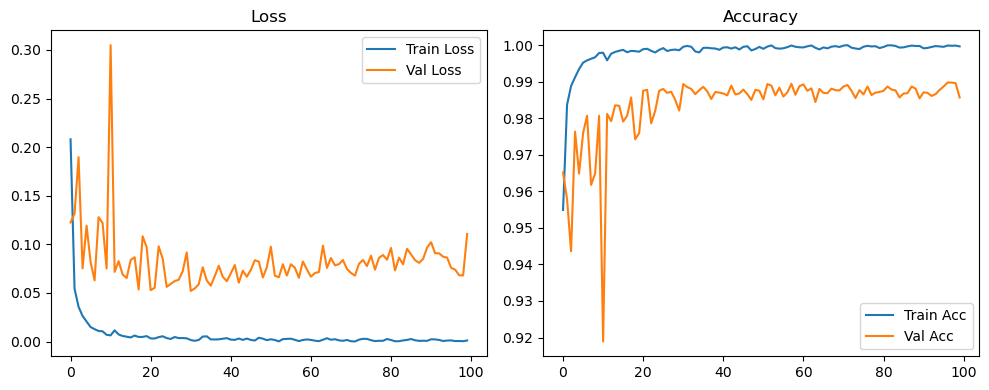

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2629, Acc: 0.9376 | Val Loss: 1.6604, Acc: 0.4949


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0835, Acc: 0.9742 | Val Loss: 0.9978, Acc: 0.6923


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9816 | Val Loss: 0.6335, Acc: 0.7953


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9842 | Val Loss: 0.5454, Acc: 0.8182


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9857 | Val Loss: 0.6612, Acc: 0.7847


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.4185, Acc: 0.8596


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.3051, Acc: 0.8972


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9889 | Val Loss: 0.3221, Acc: 0.8983


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.1798, Acc: 0.9423


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.2034, Acc: 0.9384


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.1781, Acc: 0.9486


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9912 | Val Loss: 0.2021, Acc: 0.9398


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.3772, Acc: 0.8944


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.2123, Acc: 0.9370


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.2362, Acc: 0.9320


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.3109, Acc: 0.9141


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.2473, Acc: 0.9377


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.1793, Acc: 0.9484


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.2979, Acc: 0.9226


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1888, Acc: 0.9508


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.1170, Acc: 0.9704


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1507, Acc: 0.9594


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.1245, Acc: 0.9675


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.1900, Acc: 0.9527


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1920, Acc: 0.9518


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1588, Acc: 0.9627


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.2116, Acc: 0.9483


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9953 | Val Loss: 0.1661, Acc: 0.9582


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.1012, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.2060, Acc: 0.9514


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.1802, Acc: 0.9554


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1351, Acc: 0.9681


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1417, Acc: 0.9672


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1139, Acc: 0.9732


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.1144, Acc: 0.9734


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1354, Acc: 0.9675


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0999, Acc: 0.9764


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1139, Acc: 0.9723


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1384, Acc: 0.9663


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1611, Acc: 0.9652


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1159, Acc: 0.9733


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1169, Acc: 0.9724


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1388, Acc: 0.9686


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1138, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1103, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9972 | Val Loss: 0.1243, Acc: 0.9711


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1482, Acc: 0.9673


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0947, Acc: 0.9783


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1355, Acc: 0.9702


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1237, Acc: 0.9738


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1561, Acc: 0.9663


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1327, Acc: 0.9721


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1984, Acc: 0.9553


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1335, Acc: 0.9712


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.2173, Acc: 0.9539


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9974 | Val Loss: 0.1470, Acc: 0.9692


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1856, Acc: 0.9610


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1671, Acc: 0.9656


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1309, Acc: 0.9727


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1261, Acc: 0.9756


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9973 | Val Loss: 0.1406, Acc: 0.9724


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1205, Acc: 0.9766


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0930, Acc: 0.9807


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1278, Acc: 0.9745


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1024, Acc: 0.9789


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1150, Acc: 0.9762


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1182, Acc: 0.9754


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1367, Acc: 0.9725


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1097, Acc: 0.9781


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1150, Acc: 0.9758


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1288, Acc: 0.9748


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1226, Acc: 0.9764


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0970, Acc: 0.9811


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0982, Acc: 0.9814


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1329, Acc: 0.9750


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1197, Acc: 0.9784


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1192, Acc: 0.9784


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1097, Acc: 0.9777


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1287, Acc: 0.9755


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1123, Acc: 0.9789


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1013, Acc: 0.9805


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1006, Acc: 0.9808


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1451, Acc: 0.9748


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1080, Acc: 0.9801


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1135, Acc: 0.9794


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1224, Acc: 0.9784


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1605, Acc: 0.9731


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1258, Acc: 0.9774


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1411, Acc: 0.9752


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1134, Acc: 0.9748


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1293, Acc: 0.9772


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1294, Acc: 0.9779


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1139, Acc: 0.9796


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1238, Acc: 0.9772


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1143, Acc: 0.9779


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1843, Acc: 0.9633


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1589, Acc: 0.9712


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1322, Acc: 0.9753


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0962, Acc: 0.9824


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1299, Acc: 0.9782


Final Test Loss: 0.1379 Accuracy: 0.9764


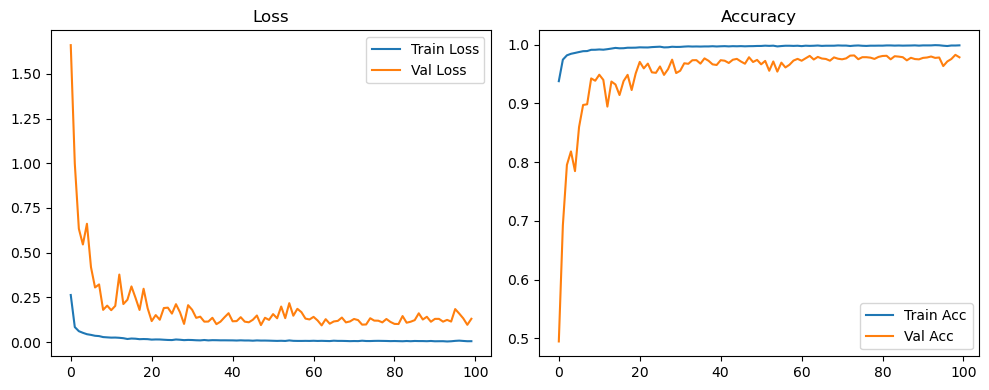

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4632, Acc: 0.8675 | Val Loss: 2.1280, Acc: 0.3529


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9506 | Val Loss: 1.4925, Acc: 0.4943


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1299, Acc: 0.9617 | Val Loss: 1.3063, Acc: 0.5989


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9661 | Val Loss: 1.6140, Acc: 0.4672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9692 | Val Loss: 1.4207, Acc: 0.5787


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0989, Acc: 0.9710 | Val Loss: 1.2547, Acc: 0.5985


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0906, Acc: 0.9726 | Val Loss: 1.1158, Acc: 0.6343


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9729 | Val Loss: 1.4071, Acc: 0.5890


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9749 | Val Loss: 0.9870, Acc: 0.6695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9755 | Val Loss: 1.3085, Acc: 0.6135


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9753 | Val Loss: 0.9749, Acc: 0.6673


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9766 | Val Loss: 0.6887, Acc: 0.7459


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9768 | Val Loss: 1.1350, Acc: 0.6471


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9783 | Val Loss: 0.8387, Acc: 0.7331


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9788 | Val Loss: 0.9099, Acc: 0.7172


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9793 | Val Loss: 0.9808, Acc: 0.7082


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9794 | Val Loss: 1.2995, Acc: 0.6258


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9799 | Val Loss: 0.9862, Acc: 0.6758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9796 | Val Loss: 0.8367, Acc: 0.7314


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9800 | Val Loss: 1.0892, Acc: 0.6796


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9808 | Val Loss: 0.9531, Acc: 0.7063


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9805 | Val Loss: 0.5826, Acc: 0.8012


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9807 | Val Loss: 0.4570, Acc: 0.8370


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9811 | Val Loss: 0.5846, Acc: 0.7952


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9824 | Val Loss: 0.5953, Acc: 0.7951


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9822 | Val Loss: 0.8914, Acc: 0.7325


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9821 | Val Loss: 0.4433, Acc: 0.8451


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9821 | Val Loss: 0.7996, Acc: 0.7502


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9830 | Val Loss: 0.8735, Acc: 0.7213


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9825 | Val Loss: 0.7096, Acc: 0.7658


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9836 | Val Loss: 0.4780, Acc: 0.8333


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9840 | Val Loss: 0.7546, Acc: 0.7537


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9829 | Val Loss: 0.5393, Acc: 0.8117


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9837 | Val Loss: 0.6376, Acc: 0.7907


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9837 | Val Loss: 0.5492, Acc: 0.8122


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9841 | Val Loss: 0.6585, Acc: 0.7713


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9846 | Val Loss: 0.3906, Acc: 0.8620


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9843 | Val Loss: 0.5913, Acc: 0.7891


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9853 | Val Loss: 0.5094, Acc: 0.8248


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 0.5786, Acc: 0.7883


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9846 | Val Loss: 0.4830, Acc: 0.8231


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9850 | Val Loss: 0.4605, Acc: 0.8358


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9848 | Val Loss: 0.7014, Acc: 0.7594


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.5737, Acc: 0.7955


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9851 | Val Loss: 0.4141, Acc: 0.8495


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9857 | Val Loss: 0.4406, Acc: 0.8385


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9870 | Val Loss: 0.4769, Acc: 0.8245


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9855 | Val Loss: 0.3810, Acc: 0.8570


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9853 | Val Loss: 0.4923, Acc: 0.8156


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.3764, Acc: 0.8599


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9854 | Val Loss: 0.5452, Acc: 0.8024


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.5252, Acc: 0.8167


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.3965, Acc: 0.8502


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.3627, Acc: 0.8593


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9868 | Val Loss: 0.5253, Acc: 0.8223


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9863 | Val Loss: 0.3695, Acc: 0.8682


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9867 | Val Loss: 0.4214, Acc: 0.8461


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9860 | Val Loss: 0.5262, Acc: 0.8086


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9865 | Val Loss: 0.6567, Acc: 0.7797


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.4576, Acc: 0.8412


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9861 | Val Loss: 0.4912, Acc: 0.8133


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.6761, Acc: 0.7508


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.6888, Acc: 0.7590


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9870 | Val Loss: 0.4906, Acc: 0.8280


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9858 | Val Loss: 0.4018, Acc: 0.8515


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9872 | Val Loss: 0.3564, Acc: 0.8725


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9864 | Val Loss: 0.4234, Acc: 0.8419


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 0.4547, Acc: 0.8347


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.3381, Acc: 0.8807


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9877 | Val Loss: 0.3318, Acc: 0.8782


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9873 | Val Loss: 0.3700, Acc: 0.8680


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9885 | Val Loss: 0.5946, Acc: 0.7965


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9874 | Val Loss: 0.5421, Acc: 0.8041


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.6245, Acc: 0.7758


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9866 | Val Loss: 0.3455, Acc: 0.8714


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.4118, Acc: 0.8513


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9883 | Val Loss: 0.3444, Acc: 0.8696


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9878 | Val Loss: 0.4540, Acc: 0.8325


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.5138, Acc: 0.8001


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9881 | Val Loss: 0.4746, Acc: 0.8187


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9878 | Val Loss: 0.4410, Acc: 0.8404


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.3473, Acc: 0.8724


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 0.4918, Acc: 0.8172


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9886 | Val Loss: 0.2660, Acc: 0.9003


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9882 | Val Loss: 0.3658, Acc: 0.8581


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9880 | Val Loss: 0.3494, Acc: 0.8698


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9881 | Val Loss: 0.2727, Acc: 0.9006


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.4810, Acc: 0.8104


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.3975, Acc: 0.8524


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9883 | Val Loss: 0.2797, Acc: 0.8985


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.2564, Acc: 0.9056


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.4036, Acc: 0.8470


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.4347, Acc: 0.8338


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.3704, Acc: 0.8576


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9892 | Val Loss: 0.3429, Acc: 0.8690


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9887 | Val Loss: 0.3122, Acc: 0.8815


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 0.4021, Acc: 0.8510


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.3653, Acc: 0.8621


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9888 | Val Loss: 0.3801, Acc: 0.8567


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.3602, Acc: 0.8672


Final Test Loss: 0.3553 Accuracy: 0.8753


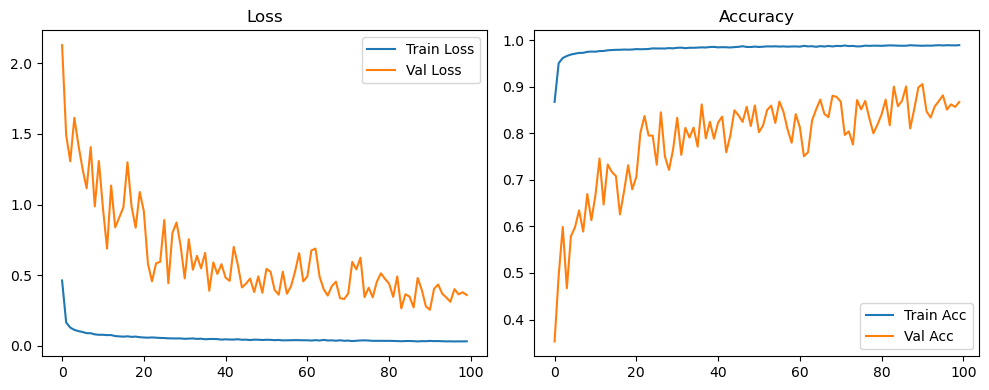

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2073, Acc: 0.9558 | Val Loss: 0.1450, Acc: 0.9570


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9832 | Val Loss: 0.0805, Acc: 0.9759


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9889 | Val Loss: 0.1439, Acc: 0.9562


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.0638, Acc: 0.9800


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0517, Acc: 0.9841


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0530, Acc: 0.9841


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.0793, Acc: 0.9748


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0709, Acc: 0.9784


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0709, Acc: 0.9808


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0836, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0760, Acc: 0.9804


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0804, Acc: 0.9794


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0516, Acc: 0.9868


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0697, Acc: 0.9833


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0506, Acc: 0.9885


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1484, Acc: 0.9662


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0702, Acc: 0.9832


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0584, Acc: 0.9858


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0690, Acc: 0.9843


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0599, Acc: 0.9868


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0629, Acc: 0.9841


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0942, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0615, Acc: 0.9879


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0676, Acc: 0.9860


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0669, Acc: 0.9864


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0648, Acc: 0.9859


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0589, Acc: 0.9876


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0627, Acc: 0.9860


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0804, Acc: 0.9834


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1840, Acc: 0.9639


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0912, Acc: 0.9813


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0795, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0606, Acc: 0.9882


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0941, Acc: 0.9823


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1113, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0581, Acc: 0.9882


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0611, Acc: 0.9882


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0580, Acc: 0.9890


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0864, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0732, Acc: 0.9861


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0609, Acc: 0.9880


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0630, Acc: 0.9897


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0819, Acc: 0.9859


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0632, Acc: 0.9891


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0915, Acc: 0.9847


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0786, Acc: 0.9863


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0963, Acc: 0.9844


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0857, Acc: 0.9862


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0778, Acc: 0.9860


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0819, Acc: 0.9863


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0707, Acc: 0.9865


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0676, Acc: 0.9887


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9880


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0694, Acc: 0.9879


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0667, Acc: 0.9888


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9884


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0751, Acc: 0.9878


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0708, Acc: 0.9888


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0690, Acc: 0.9888


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0672, Acc: 0.9885


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0642, Acc: 0.9894


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9907


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9904


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0634, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9898


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9898


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0648, Acc: 0.9903


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0859, Acc: 0.9862


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0807, Acc: 0.9868


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0761, Acc: 0.9885


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0688, Acc: 0.9892


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0690, Acc: 0.9889


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0809, Acc: 0.9873


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0756, Acc: 0.9880


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0937, Acc: 0.9858


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0708, Acc: 0.9893


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9898


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0690, Acc: 0.9890


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0895, Acc: 0.9877


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0685, Acc: 0.9898


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0723, Acc: 0.9893


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9900


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0709, Acc: 0.9887


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0683, Acc: 0.9900


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0698, Acc: 0.9900


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0682, Acc: 0.9898


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9901


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0681, Acc: 0.9897


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0694, Acc: 0.9901


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0686, Acc: 0.9892


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0692, Acc: 0.9894


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9904


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0649, Acc: 0.9898


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9904


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9899


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9902


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9901


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0698, Acc: 0.9897


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0716, Acc: 0.9890


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0667, Acc: 0.9899


Final Test Loss: 0.0603 Accuracy: 0.9897


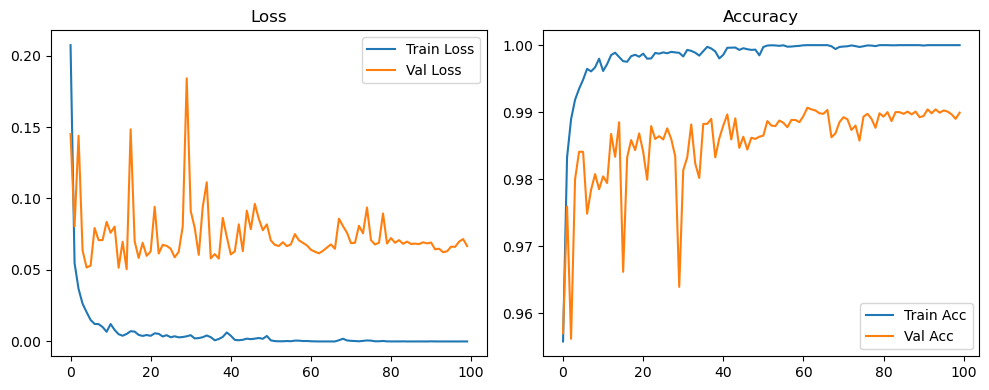

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2621, Acc: 0.9376 | Val Loss: 1.2902, Acc: 0.5938


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0829, Acc: 0.9749 | Val Loss: 0.7951, Acc: 0.7321


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9810 | Val Loss: 0.7513, Acc: 0.7671


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9838 | Val Loss: 0.5917, Acc: 0.8043


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9859 | Val Loss: 0.8129, Acc: 0.7372


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.5191, Acc: 0.8407


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 0.3511, Acc: 0.8888


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.2850, Acc: 0.9070


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1855, Acc: 0.9418


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.1796, Acc: 0.9488


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.2682, Acc: 0.9207


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.1976, Acc: 0.9411


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.3490, Acc: 0.9022


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1554, Acc: 0.9543


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1660, Acc: 0.9543


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1674, Acc: 0.9531


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.2065, Acc: 0.9466


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.2423, Acc: 0.9354


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9935 | Val Loss: 0.1262, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.2635, Acc: 0.9331


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1725, Acc: 0.9533


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.1332, Acc: 0.9667


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1108, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1745, Acc: 0.9567


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1352, Acc: 0.9668


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.2084, Acc: 0.9513


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1364, Acc: 0.9669


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1470, Acc: 0.9637


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.1037, Acc: 0.9749


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1673, Acc: 0.9609


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1248, Acc: 0.9704


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1363, Acc: 0.9682


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1598, Acc: 0.9621


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1152, Acc: 0.9746


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1698, Acc: 0.9597


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.0913, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1686, Acc: 0.9622


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.1815, Acc: 0.9593


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1905, Acc: 0.9584


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1289, Acc: 0.9712


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1486, Acc: 0.9669


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1292, Acc: 0.9700


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1447, Acc: 0.9689


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1503, Acc: 0.9670


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1538, Acc: 0.9654


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1559, Acc: 0.9653


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1856, Acc: 0.9602


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1156, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1125, Acc: 0.9754


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1146, Acc: 0.9756


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1120, Acc: 0.9755


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1633, Acc: 0.9652


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1629, Acc: 0.9674


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1214, Acc: 0.9741


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1181, Acc: 0.9752


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1128, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1220, Acc: 0.9760


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1739, Acc: 0.9663


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1308, Acc: 0.9750


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1297, Acc: 0.9757


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1319, Acc: 0.9742


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1072, Acc: 0.9792


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1219, Acc: 0.9772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9986 | Val Loss: 0.1206, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1262, Acc: 0.9751


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1022, Acc: 0.9796


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0878, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1569, Acc: 0.9707


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1189, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1314, Acc: 0.9751


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1263, Acc: 0.9766


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1454, Acc: 0.9742


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1367, Acc: 0.9755


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1252, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1649, Acc: 0.9688


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1776, Acc: 0.9688


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1106, Acc: 0.9797


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1306, Acc: 0.9749


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1183, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1039, Acc: 0.9810


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0947, Acc: 0.9822


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1179, Acc: 0.9795


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0964, Acc: 0.9832


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1038, Acc: 0.9810


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1078, Acc: 0.9802


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1100, Acc: 0.9799


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1051, Acc: 0.9810


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1068, Acc: 0.9811


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1125, Acc: 0.9808


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1060, Acc: 0.9805


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1184, Acc: 0.9778


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.1163, Acc: 0.9782


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1286, Acc: 0.9763


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1122, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1194, Acc: 0.9795


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1049, Acc: 0.9812


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1325, Acc: 0.9769


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1178, Acc: 0.9802


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1036, Acc: 0.9827


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1187, Acc: 0.9792


Final Test Loss: 0.1247 Accuracy: 0.9765


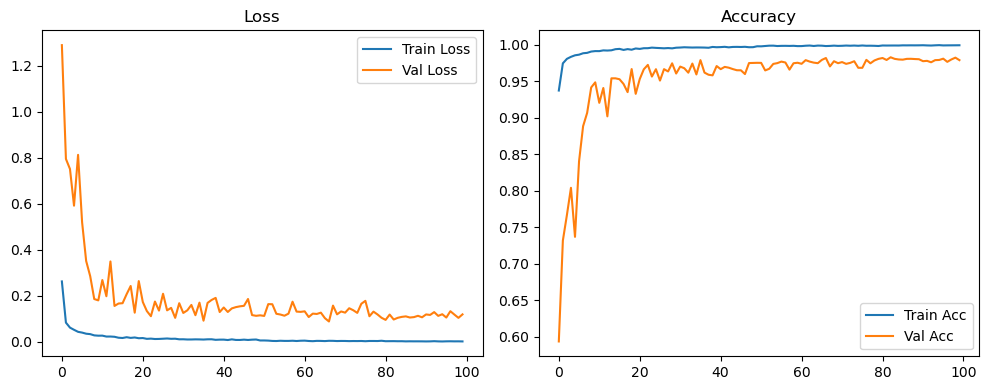

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4636, Acc: 0.8672 | Val Loss: 2.0081, Acc: 0.3580


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9517 | Val Loss: 1.2854, Acc: 0.5559


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9621 | Val Loss: 1.4567, Acc: 0.5553


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1141, Acc: 0.9667 | Val Loss: 1.6488, Acc: 0.4511


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1046, Acc: 0.9694 | Val Loss: 1.7907, Acc: 0.4818


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0982, Acc: 0.9701 | Val Loss: 1.0989, Acc: 0.6606


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9719 | Val Loss: 1.1217, Acc: 0.6236


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9723 | Val Loss: 1.2154, Acc: 0.6368


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9747 | Val Loss: 0.9684, Acc: 0.6937


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9750 | Val Loss: 0.9484, Acc: 0.6867


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9748 | Val Loss: 0.9409, Acc: 0.6933


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9756 | Val Loss: 0.6799, Acc: 0.7586


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9772 | Val Loss: 1.1497, Acc: 0.6587


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9785 | Val Loss: 1.0492, Acc: 0.6889


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9791 | Val Loss: 0.9951, Acc: 0.6927


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9794 | Val Loss: 0.9781, Acc: 0.6903


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9790 | Val Loss: 1.1434, Acc: 0.6381


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9793 | Val Loss: 0.9434, Acc: 0.6924


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9796 | Val Loss: 1.0133, Acc: 0.6829


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9795 | Val Loss: 1.0935, Acc: 0.6687


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9812 | Val Loss: 0.6020, Acc: 0.8109


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9819 | Val Loss: 0.6120, Acc: 0.7920


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9819 | Val Loss: 0.6314, Acc: 0.7772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9812 | Val Loss: 0.6693, Acc: 0.7749


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9820 | Val Loss: 0.6955, Acc: 0.7676


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9812 | Val Loss: 0.7324, Acc: 0.7719


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9818 | Val Loss: 0.6753, Acc: 0.7816


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9823 | Val Loss: 0.9215, Acc: 0.7117


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9820 | Val Loss: 0.8872, Acc: 0.7132


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9825 | Val Loss: 0.8679, Acc: 0.7077


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9832 | Val Loss: 0.6337, Acc: 0.7803


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9838 | Val Loss: 0.6316, Acc: 0.7904


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9840 | Val Loss: 0.4929, Acc: 0.8329


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9831 | Val Loss: 0.6856, Acc: 0.7723


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9835 | Val Loss: 0.4434, Acc: 0.8423


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9838 | Val Loss: 0.5988, Acc: 0.7920


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9834 | Val Loss: 0.3330, Acc: 0.8839


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.6872, Acc: 0.7571


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9847 | Val Loss: 0.4309, Acc: 0.8528


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9839 | Val Loss: 0.4121, Acc: 0.8555


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9841 | Val Loss: 0.4828, Acc: 0.8242


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9852 | Val Loss: 0.4066, Acc: 0.8591


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 0.5381, Acc: 0.8078


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.5355, Acc: 0.8172


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9841 | Val Loss: 0.4696, Acc: 0.8322


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9851 | Val Loss: 0.5097, Acc: 0.8178


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.5304, Acc: 0.8153


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9851 | Val Loss: 0.5203, Acc: 0.8157


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.4127, Acc: 0.8508


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9856 | Val Loss: 0.4538, Acc: 0.8248


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9868 | Val Loss: 0.5138, Acc: 0.8141


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.4801, Acc: 0.8290


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.3739, Acc: 0.8632


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.3531, Acc: 0.8714


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9890 | Val Loss: 0.3503, Acc: 0.8738


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9884 | Val Loss: 0.3466, Acc: 0.8741


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.5146, Acc: 0.8193


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.4531, Acc: 0.8357


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.4533, Acc: 0.8342


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9885 | Val Loss: 0.3919, Acc: 0.8572


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9885 | Val Loss: 0.4017, Acc: 0.8533


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.4849, Acc: 0.8218


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.3696, Acc: 0.8648


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.3868, Acc: 0.8638


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9878 | Val Loss: 0.2816, Acc: 0.8962


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9888 | Val Loss: 0.4273, Acc: 0.8470


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 0.4298, Acc: 0.8457


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9894 | Val Loss: 0.4596, Acc: 0.8311


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9885 | Val Loss: 0.3217, Acc: 0.8786


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.3008, Acc: 0.8883


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9885 | Val Loss: 0.3311, Acc: 0.8820


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.3919, Acc: 0.8634


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9888 | Val Loss: 0.3688, Acc: 0.8658


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9892 | Val Loss: 0.3625, Acc: 0.8678


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.3380, Acc: 0.8758


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9893 | Val Loss: 0.4021, Acc: 0.8522


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9892 | Val Loss: 0.3253, Acc: 0.8796


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9895 | Val Loss: 0.3190, Acc: 0.8846


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.3891, Acc: 0.8582


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9892 | Val Loss: 0.3458, Acc: 0.8677


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.3914, Acc: 0.8555


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.3233, Acc: 0.8811


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.3413, Acc: 0.8752


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9911 | Val Loss: 0.2822, Acc: 0.8947


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 0.3188, Acc: 0.8812


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9911 | Val Loss: 0.3138, Acc: 0.8838


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9913 | Val Loss: 0.2856, Acc: 0.8938


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9918 | Val Loss: 0.3235, Acc: 0.8768


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9910 | Val Loss: 0.3307, Acc: 0.8768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.2908, Acc: 0.8878


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.2981, Acc: 0.8894


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.3305, Acc: 0.8754


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.3464, Acc: 0.8680


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.3152, Acc: 0.8788


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9920 | Val Loss: 0.2711, Acc: 0.8981


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9907 | Val Loss: 0.3006, Acc: 0.8849


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.2940, Acc: 0.8914


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.3557, Acc: 0.8690


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9911 | Val Loss: 0.2738, Acc: 0.8998


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.2681, Acc: 0.9026


Final Test Loss: 0.2518 Accuracy: 0.9085


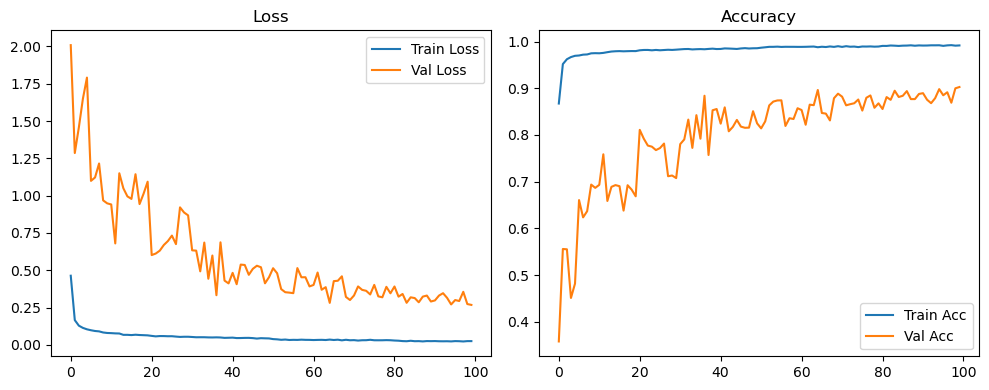

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2084, Acc: 0.9551 | Val Loss: 0.1796, Acc: 0.9455


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9834 | Val Loss: 0.1115, Acc: 0.9658


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9890 | Val Loss: 0.3218, Acc: 0.8972


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.0671, Acc: 0.9795


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0754, Acc: 0.9777


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0927, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0483, Acc: 0.9848


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0585, Acc: 0.9829


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1716, Acc: 0.9560


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0744, Acc: 0.9805


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0662, Acc: 0.9824


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0645, Acc: 0.9823


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0868, Acc: 0.9793


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0809, Acc: 0.9806


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1134, Acc: 0.9749


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0669, Acc: 0.9826


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9974 | Val Loss: 0.1271, Acc: 0.9693


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0589, Acc: 0.9865


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0772, Acc: 0.9820


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0616, Acc: 0.9874


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0725, Acc: 0.9836


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.2419, Acc: 0.9444


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0655, Acc: 0.9854


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0677, Acc: 0.9841


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0830, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0940, Acc: 0.9791


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0729, Acc: 0.9856


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0688, Acc: 0.9858


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0627, Acc: 0.9865


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0676, Acc: 0.9856


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0793, Acc: 0.9827


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0611, Acc: 0.9891


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0668, Acc: 0.9872


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0760, Acc: 0.9838


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0758, Acc: 0.9855


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0869, Acc: 0.9842


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0731, Acc: 0.9862


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0679, Acc: 0.9870


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0717, Acc: 0.9878


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0971, Acc: 0.9809


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0791, Acc: 0.9875


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0708, Acc: 0.9884


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0614, Acc: 0.9894


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0645, Acc: 0.9888


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0616, Acc: 0.9893


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0850, Acc: 0.9853


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1079, Acc: 0.9828


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0763, Acc: 0.9868


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0753, Acc: 0.9877


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0982, Acc: 0.9841


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0689, Acc: 0.9893


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0673, Acc: 0.9896


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0682, Acc: 0.9898


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9898


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9900


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9903


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0661, Acc: 0.9897


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0645, Acc: 0.9893


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0683, Acc: 0.9884


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0734, Acc: 0.9888


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0727, Acc: 0.9884


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9892


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0681, Acc: 0.9890


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9892


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0697, Acc: 0.9896


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9896


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9892


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9898


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0654, Acc: 0.9898


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0658, Acc: 0.9889


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0893, Acc: 0.9865


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0744, Acc: 0.9885


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0788, Acc: 0.9882


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0740, Acc: 0.9888


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0709, Acc: 0.9896


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0688, Acc: 0.9902


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0692, Acc: 0.9897


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0708, Acc: 0.9883


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1076, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0763, Acc: 0.9878


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0712, Acc: 0.9892


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0702, Acc: 0.9894


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0704, Acc: 0.9894


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0720, Acc: 0.9890


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0717, Acc: 0.9895


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0706, Acc: 0.9893


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0719, Acc: 0.9891


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0697, Acc: 0.9895


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0713, Acc: 0.9898


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0724, Acc: 0.9893


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0714, Acc: 0.9902


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0705, Acc: 0.9902


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0693, Acc: 0.9902


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0707, Acc: 0.9893


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0671, Acc: 0.9899


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9898


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0685, Acc: 0.9906


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9900


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0704, Acc: 0.9896


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0674, Acc: 0.9898


Final Test Loss: 0.0630 Accuracy: 0.9898


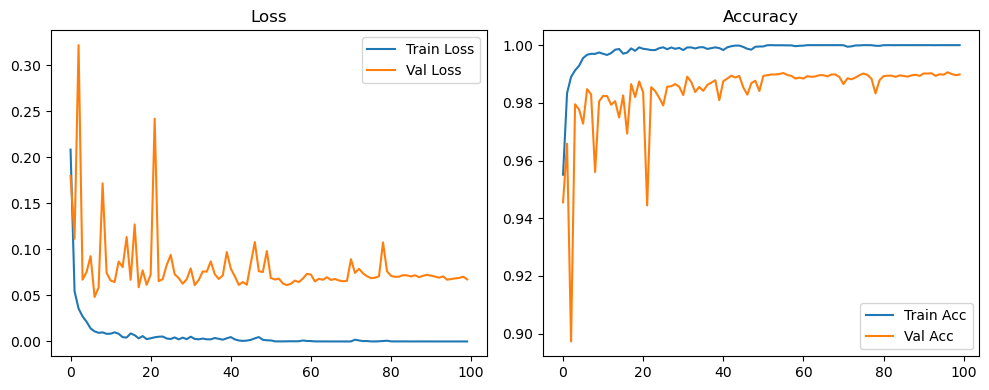

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2629, Acc: 0.9373 | Val Loss: 1.9078, Acc: 0.4681


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9746 | Val Loss: 0.8185, Acc: 0.7462


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9813 | Val Loss: 0.8154, Acc: 0.7528


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9839 | Val Loss: 0.6037, Acc: 0.7927


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9868 | Val Loss: 0.5183, Acc: 0.8255


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.5539, Acc: 0.8234


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.3236, Acc: 0.8938


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.3923, Acc: 0.8728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.1501, Acc: 0.9517


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.2189, Acc: 0.9347


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9915 | Val Loss: 0.3306, Acc: 0.9029


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.2949, Acc: 0.9134


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9916 | Val Loss: 0.4341, Acc: 0.8757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1867, Acc: 0.9485


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.2493, Acc: 0.9335


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.1811, Acc: 0.9485


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.2506, Acc: 0.9319


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.1588, Acc: 0.9576


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.1631, Acc: 0.9539


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.2654, Acc: 0.9323


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1898, Acc: 0.9501


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9950 | Val Loss: 0.1945, Acc: 0.9503


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1585, Acc: 0.9598


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9953 | Val Loss: 0.2132, Acc: 0.9450


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1976, Acc: 0.9517


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1720, Acc: 0.9573


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1951, Acc: 0.9555


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1530, Acc: 0.9643


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1351, Acc: 0.9683


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.2130, Acc: 0.9531


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9961 | Val Loss: 0.1364, Acc: 0.9683


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1653, Acc: 0.9621


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.0977, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1003, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1422, Acc: 0.9679


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1507, Acc: 0.9641


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1232, Acc: 0.9717


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1001, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1292, Acc: 0.9700


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1276, Acc: 0.9723


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0972, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.0932, Acc: 0.9786


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.1285, Acc: 0.9720


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1137, Acc: 0.9727


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1283, Acc: 0.9733


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1495, Acc: 0.9662


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1600, Acc: 0.9653


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0910, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1398, Acc: 0.9696


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1747, Acc: 0.9641


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1182, Acc: 0.9749


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1435, Acc: 0.9711


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1177, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1043, Acc: 0.9780


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1387, Acc: 0.9741


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1274, Acc: 0.9745


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1609, Acc: 0.9684


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1352, Acc: 0.9736


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1212, Acc: 0.9780


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1411, Acc: 0.9719


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1624, Acc: 0.9681


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1196, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0920, Acc: 0.9821


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1582, Acc: 0.9673


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1334, Acc: 0.9744


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1160, Acc: 0.9775


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1087, Acc: 0.9787


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1645, Acc: 0.9698


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1219, Acc: 0.9762


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1109, Acc: 0.9780


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1321, Acc: 0.9750


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1049, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1390, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1822, Acc: 0.9657


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1314, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1460, Acc: 0.9738


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1184, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1250, Acc: 0.9777


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1261, Acc: 0.9770


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1390, Acc: 0.9747


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1316, Acc: 0.9754


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1282, Acc: 0.9757


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1249, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1195, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1164, Acc: 0.9791


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1283, Acc: 0.9775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1211, Acc: 0.9787


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1245, Acc: 0.9773


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1118, Acc: 0.9806


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1242, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1323, Acc: 0.9760


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1217, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1115, Acc: 0.9796


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1120, Acc: 0.9801


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1265, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1304, Acc: 0.9772


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1169, Acc: 0.9796


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1159, Acc: 0.9799


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1154, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1073, Acc: 0.9811


Final Test Loss: 0.1089 Accuracy: 0.9785


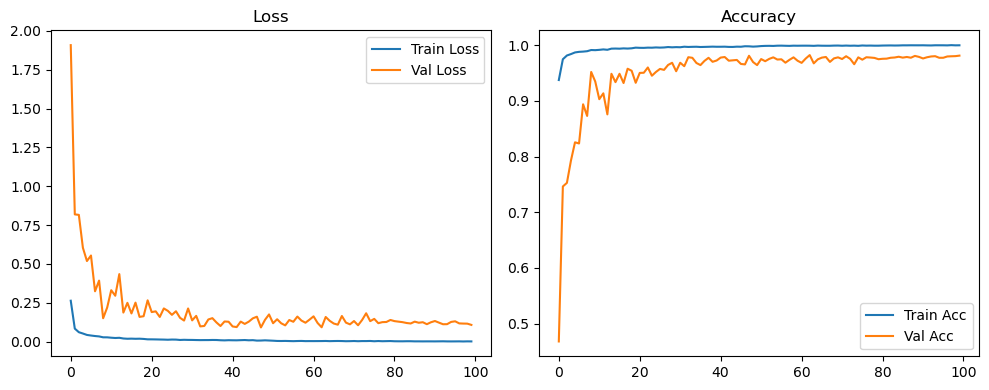

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4639, Acc: 0.8669 | Val Loss: 2.3984, Acc: 0.2920


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1668, Acc: 0.9511 | Val Loss: 1.7611, Acc: 0.4323


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9623 | Val Loss: 1.5272, Acc: 0.5066


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9669 | Val Loss: 1.3317, Acc: 0.5355


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9684 | Val Loss: 1.6278, Acc: 0.5309


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9710 | Val Loss: 1.6195, Acc: 0.5287


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9717 | Val Loss: 1.1133, Acc: 0.6420


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9733 | Val Loss: 1.6008, Acc: 0.5485


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9748 | Val Loss: 1.0973, Acc: 0.6252


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9751 | Val Loss: 1.4737, Acc: 0.5605


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9753 | Val Loss: 1.1091, Acc: 0.6212


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9757 | Val Loss: 0.8392, Acc: 0.7078


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9776 | Val Loss: 1.2846, Acc: 0.5968


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9780 | Val Loss: 1.2986, Acc: 0.6106


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9778 | Val Loss: 0.9329, Acc: 0.6996


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9788 | Val Loss: 1.2625, Acc: 0.6192


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0680, Acc: 0.9794 | Val Loss: 1.2992, Acc: 0.6196


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9798 | Val Loss: 1.2494, Acc: 0.6232


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9797 | Val Loss: 1.0190, Acc: 0.6693


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9808 | Val Loss: 0.8960, Acc: 0.7123


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9813 | Val Loss: 0.8263, Acc: 0.7385


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9819 | Val Loss: 0.6128, Acc: 0.7893


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9813 | Val Loss: 0.5607, Acc: 0.8063


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.6920, Acc: 0.7598


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9816 | Val Loss: 0.6274, Acc: 0.7875


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9814 | Val Loss: 0.8010, Acc: 0.7470


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9820 | Val Loss: 0.6235, Acc: 0.7880


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9827 | Val Loss: 0.8630, Acc: 0.7319


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9831 | Val Loss: 0.9321, Acc: 0.6977


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9821 | Val Loss: 1.0601, Acc: 0.6833


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9831 | Val Loss: 0.7563, Acc: 0.7501


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9835 | Val Loss: 0.9099, Acc: 0.7101


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9835 | Val Loss: 0.6064, Acc: 0.8012


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9828 | Val Loss: 0.8134, Acc: 0.7405


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9838 | Val Loss: 0.5927, Acc: 0.7916


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.8518, Acc: 0.7159


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9837 | Val Loss: 0.3727, Acc: 0.8662


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.6364, Acc: 0.7808


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9846 | Val Loss: 0.5594, Acc: 0.8291


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9845 | Val Loss: 0.5332, Acc: 0.8117


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9839 | Val Loss: 0.3713, Acc: 0.8638


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9848 | Val Loss: 0.4300, Acc: 0.8492


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9856 | Val Loss: 0.4195, Acc: 0.8423


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9841 | Val Loss: 0.5992, Acc: 0.7919


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9859 | Val Loss: 0.4335, Acc: 0.8466


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.4559, Acc: 0.8432


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9862 | Val Loss: 0.4595, Acc: 0.8370


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9855 | Val Loss: 0.5189, Acc: 0.8257


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9858 | Val Loss: 0.6547, Acc: 0.7764


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9863 | Val Loss: 0.4407, Acc: 0.8428


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9870 | Val Loss: 0.5372, Acc: 0.8122


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.3411, Acc: 0.8784


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9882 | Val Loss: 0.3768, Acc: 0.8608


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.3518, Acc: 0.8679


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.3633, Acc: 0.8725


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.3250, Acc: 0.8842


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.4046, Acc: 0.8562


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9889 | Val Loss: 0.5467, Acc: 0.8127


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9882 | Val Loss: 0.4873, Acc: 0.8271


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9888 | Val Loss: 0.3951, Acc: 0.8577


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9886 | Val Loss: 0.3819, Acc: 0.8612


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9894 | Val Loss: 0.4727, Acc: 0.8270


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.4227, Acc: 0.8445


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.4127, Acc: 0.8486


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9884 | Val Loss: 0.4135, Acc: 0.8392


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.4135, Acc: 0.8534


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9886 | Val Loss: 0.5653, Acc: 0.7812


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9895 | Val Loss: 0.4361, Acc: 0.8349


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.4925, Acc: 0.8116


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.4411, Acc: 0.8406


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9884 | Val Loss: 0.4650, Acc: 0.8314


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.4824, Acc: 0.8209


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9898 | Val Loss: 0.4429, Acc: 0.8367


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.4630, Acc: 0.8273


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9890 | Val Loss: 0.3420, Acc: 0.8759


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9898 | Val Loss: 0.3960, Acc: 0.8553


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9894 | Val Loss: 0.4371, Acc: 0.8413


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9900 | Val Loss: 0.3779, Acc: 0.8667


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9889 | Val Loss: 0.6234, Acc: 0.7695


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9888 | Val Loss: 0.4875, Acc: 0.8169


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.4175, Acc: 0.8482


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9910 | Val Loss: 0.3652, Acc: 0.8645


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9912 | Val Loss: 0.3934, Acc: 0.8512


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9916 | Val Loss: 0.3765, Acc: 0.8572


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.3730, Acc: 0.8633


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9912 | Val Loss: 0.3471, Acc: 0.8718


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.3555, Acc: 0.8670


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.3913, Acc: 0.8548


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.3316, Acc: 0.8808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9913 | Val Loss: 0.3568, Acc: 0.8700


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.3451, Acc: 0.8737


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.3775, Acc: 0.8592


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.3850, Acc: 0.8530


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.3491, Acc: 0.8680


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.3383, Acc: 0.8718


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9916 | Val Loss: 0.3176, Acc: 0.8803


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.3334, Acc: 0.8756


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.3673, Acc: 0.8621


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.2913, Acc: 0.8930


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.3070, Acc: 0.8845


Final Test Loss: 0.2955 Accuracy: 0.8874


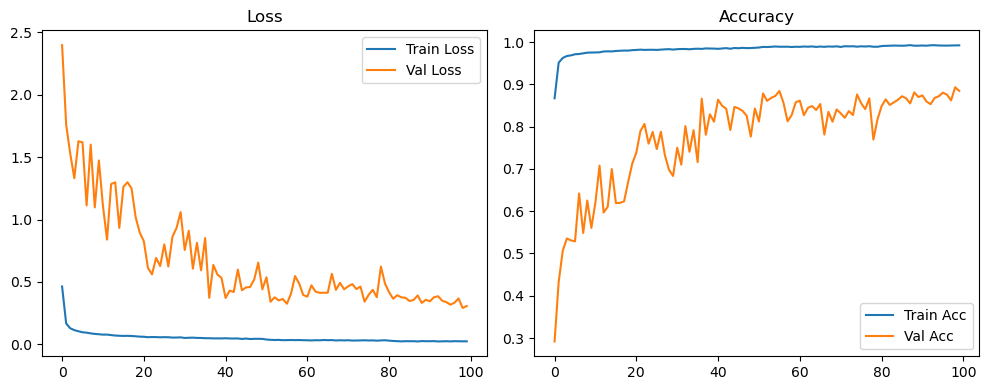

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2073, Acc: 0.9555 | Val Loss: 0.1377, Acc: 0.9613


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9833 | Val Loss: 0.1556, Acc: 0.9507


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.1078, Acc: 0.9677


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1110, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0628, Acc: 0.9816


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0631, Acc: 0.9828


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1143, Acc: 0.9665


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0811, Acc: 0.9756


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1770, Acc: 0.9536


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0922, Acc: 0.9753


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0644, Acc: 0.9832


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0560, Acc: 0.9870


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0986, Acc: 0.9752


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0548, Acc: 0.9864


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9976 | Val Loss: 0.0797, Acc: 0.9818


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.0686, Acc: 0.9834


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0695, Acc: 0.9852


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0674, Acc: 0.9841


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0685, Acc: 0.9854


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0547, Acc: 0.9868


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1884, Acc: 0.9580


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0634, Acc: 0.9850


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0809, Acc: 0.9839


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0585, Acc: 0.9878


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0789, Acc: 0.9842


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1789, Acc: 0.9587


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0764, Acc: 0.9852


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0709, Acc: 0.9867


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0669, Acc: 0.9862


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0764, Acc: 0.9838


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0772, Acc: 0.9835


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0664, Acc: 0.9874


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0798, Acc: 0.9852


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0637, Acc: 0.9870


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0734, Acc: 0.9853


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0831, Acc: 0.9849


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0819, Acc: 0.9851


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0754, Acc: 0.9861


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0684, Acc: 0.9863


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0751, Acc: 0.9870


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0686, Acc: 0.9868


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0690, Acc: 0.9878


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0875, Acc: 0.9851


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0742, Acc: 0.9875


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0754, Acc: 0.9875


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0752, Acc: 0.9879


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0833, Acc: 0.9854


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1258, Acc: 0.9792


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0749, Acc: 0.9878


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0783, Acc: 0.9865


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0632, Acc: 0.9888


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9890


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9888


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9885


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9896


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9889


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9888


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9889


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9896


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9893


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0634, Acc: 0.9890


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9895


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9895


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9899


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9892


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9888


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0634, Acc: 0.9892


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0661, Acc: 0.9890


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9898


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0642, Acc: 0.9896


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9895


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9897


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9898


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9902


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9904


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9898


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9893


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9904


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0749, Acc: 0.9888


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0701, Acc: 0.9894


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9899


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9895


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0634, Acc: 0.9907


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9903


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9906


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9908


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9904


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9905


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9902


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9906


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0649, Acc: 0.9901


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0653, Acc: 0.9902


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0637, Acc: 0.9907


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9902


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9903


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9902


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9902


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9904


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9903


Final Test Loss: 0.0626 Accuracy: 0.9899


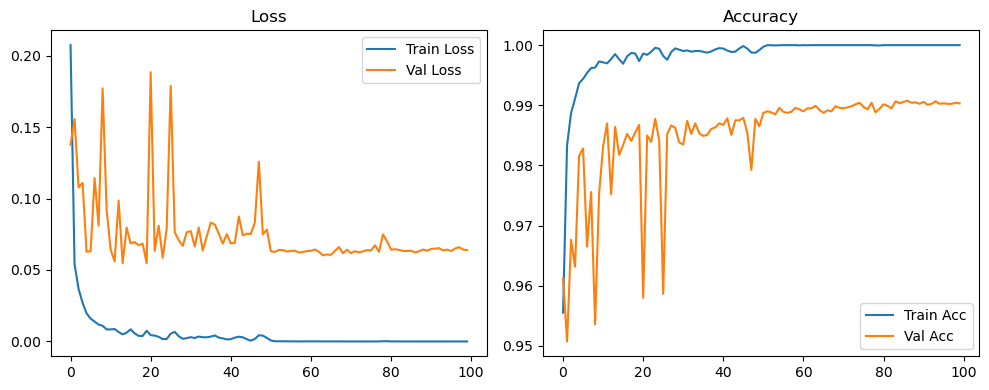

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2627, Acc: 0.9372 | Val Loss: 1.9997, Acc: 0.4304


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9743 | Val Loss: 0.8536, Acc: 0.7160


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9807 | Val Loss: 0.6826, Acc: 0.7835


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9838 | Val Loss: 0.4861, Acc: 0.8333


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9872 | Val Loss: 0.4429, Acc: 0.8580


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9869 | Val Loss: 0.4064, Acc: 0.8714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.2441, Acc: 0.9200


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9896 | Val Loss: 0.3140, Acc: 0.8982


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.2125, Acc: 0.9335


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.3311, Acc: 0.9021


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.2488, Acc: 0.9262


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.1913, Acc: 0.9397


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9921 | Val Loss: 0.2078, Acc: 0.9389


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1976, Acc: 0.9421


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.2619, Acc: 0.9283


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1780, Acc: 0.9484


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.2466, Acc: 0.9304


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.1544, Acc: 0.9569


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.1275, Acc: 0.9658


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1699, Acc: 0.9548


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1171, Acc: 0.9696


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.1234, Acc: 0.9692


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1291, Acc: 0.9667


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1432, Acc: 0.9629


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.2082, Acc: 0.9491


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1406, Acc: 0.9643


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9951 | Val Loss: 0.2106, Acc: 0.9515


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1822, Acc: 0.9557


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1410, Acc: 0.9647


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1757, Acc: 0.9580


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1225, Acc: 0.9699


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1835, Acc: 0.9563


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1278, Acc: 0.9709


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.1338, Acc: 0.9680


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1333, Acc: 0.9710


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9958 | Val Loss: 0.1153, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0962, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1367, Acc: 0.9703


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1711, Acc: 0.9632


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1582, Acc: 0.9665


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1209, Acc: 0.9738


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1261, Acc: 0.9740


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.1690, Acc: 0.9646


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1261, Acc: 0.9723


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1521, Acc: 0.9700


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1585, Acc: 0.9665


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1791, Acc: 0.9624


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1182, Acc: 0.9754


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1658, Acc: 0.9669


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1486, Acc: 0.9691


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1232, Acc: 0.9750


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1262, Acc: 0.9748


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1208, Acc: 0.9763


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1164, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1278, Acc: 0.9756


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1202, Acc: 0.9757


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1319, Acc: 0.9736


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1257, Acc: 0.9760


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1222, Acc: 0.9779


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1354, Acc: 0.9741


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1537, Acc: 0.9704


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1135, Acc: 0.9779


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1249, Acc: 0.9771


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1187, Acc: 0.9776


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1168, Acc: 0.9774


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1124, Acc: 0.9796


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1149, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1571, Acc: 0.9709


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.1263, Acc: 0.9771


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1233, Acc: 0.9779


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1362, Acc: 0.9753


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1230, Acc: 0.9771


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1299, Acc: 0.9772


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1294, Acc: 0.9762


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1202, Acc: 0.9781


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1100, Acc: 0.9803


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1197, Acc: 0.9778


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1190, Acc: 0.9781


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1287, Acc: 0.9770


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1081, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1144, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1110, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1171, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1084, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1164, Acc: 0.9787


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1148, Acc: 0.9790


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1122, Acc: 0.9791


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1141, Acc: 0.9797


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1176, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1192, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1112, Acc: 0.9801


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1121, Acc: 0.9801


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1096, Acc: 0.9809


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1117, Acc: 0.9796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1088, Acc: 0.9817


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1086, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1301, Acc: 0.9765


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1214, Acc: 0.9779


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1071, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1138, Acc: 0.9805


Final Test Loss: 0.1201 Accuracy: 0.9770


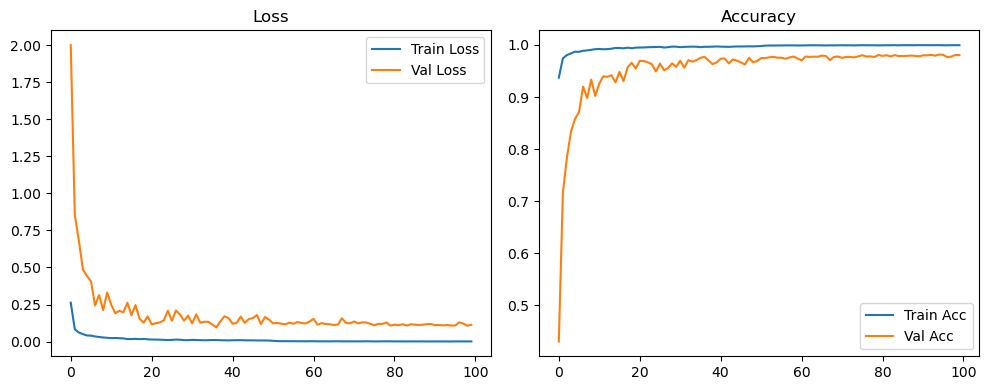

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4631, Acc: 0.8675 | Val Loss: 2.4234, Acc: 0.2987


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1651, Acc: 0.9517 | Val Loss: 1.7218, Acc: 0.4618


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9628 | Val Loss: 1.3368, Acc: 0.6069


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9664 | Val Loss: 1.3204, Acc: 0.5653


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9681 | Val Loss: 1.9022, Acc: 0.4722


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0973, Acc: 0.9705 | Val Loss: 1.2336, Acc: 0.6248


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9717 | Val Loss: 1.3230, Acc: 0.5948


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9724 | Val Loss: 1.2233, Acc: 0.6330


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9743 | Val Loss: 0.9861, Acc: 0.6775


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9755 | Val Loss: 1.2252, Acc: 0.6311


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9751 | Val Loss: 1.2539, Acc: 0.6191


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9761 | Val Loss: 0.5805, Acc: 0.7924


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9767 | Val Loss: 1.7454, Acc: 0.5292


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9786 | Val Loss: 1.2972, Acc: 0.6132


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9788 | Val Loss: 1.2141, Acc: 0.6348


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9791 | Val Loss: 0.9770, Acc: 0.7038


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9791 | Val Loss: 1.3590, Acc: 0.5937


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9791 | Val Loss: 0.8850, Acc: 0.7133


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9790 | Val Loss: 1.0059, Acc: 0.6957


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9793 | Val Loss: 1.2188, Acc: 0.6370


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9799 | Val Loss: 0.8863, Acc: 0.7248


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9805 | Val Loss: 0.8812, Acc: 0.7271


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9802 | Val Loss: 0.6391, Acc: 0.7768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9806 | Val Loss: 0.8154, Acc: 0.7286


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9819 | Val Loss: 0.7088, Acc: 0.7618


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9811 | Val Loss: 0.8895, Acc: 0.7237


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9820 | Val Loss: 0.8897, Acc: 0.7251


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9819 | Val Loss: 0.8112, Acc: 0.7402


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 1.0310, Acc: 0.6809


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9825 | Val Loss: 1.1468, Acc: 0.6522


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9831 | Val Loss: 0.9552, Acc: 0.7033


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9831 | Val Loss: 0.8784, Acc: 0.7194


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9832 | Val Loss: 1.0127, Acc: 0.6853


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9839 | Val Loss: 0.6321, Acc: 0.7901


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9836 | Val Loss: 0.8127, Acc: 0.7458


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9837 | Val Loss: 1.0315, Acc: 0.6821


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9835 | Val Loss: 0.5309, Acc: 0.8182


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9843 | Val Loss: 0.7848, Acc: 0.7432


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9849 | Val Loss: 0.8185, Acc: 0.7619


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9837 | Val Loss: 0.7589, Acc: 0.7482


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9845 | Val Loss: 0.8726, Acc: 0.7206


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.6772, Acc: 0.7737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9849 | Val Loss: 0.9831, Acc: 0.7011


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9847 | Val Loss: 0.7121, Acc: 0.7512


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9855 | Val Loss: 0.7170, Acc: 0.7634


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9844 | Val Loss: 0.9615, Acc: 0.6923


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9856 | Val Loss: 0.8070, Acc: 0.7356


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9845 | Val Loss: 0.7612, Acc: 0.7588


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9859 | Val Loss: 0.8255, Acc: 0.7179


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9847 | Val Loss: 0.7575, Acc: 0.7454


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9878 | Val Loss: 0.7823, Acc: 0.7418


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.7039, Acc: 0.7600


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9885 | Val Loss: 0.7278, Acc: 0.7595


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9889 | Val Loss: 0.5896, Acc: 0.7895


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.7227, Acc: 0.7642


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9893 | Val Loss: 0.6009, Acc: 0.7912


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.7230, Acc: 0.7566


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 0.7177, Acc: 0.7515


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9890 | Val Loss: 0.6843, Acc: 0.7690


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.5679, Acc: 0.8087


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9899 | Val Loss: 0.6307, Acc: 0.7809


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.5879, Acc: 0.7947


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.6130, Acc: 0.7858


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.6113, Acc: 0.7918


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9895 | Val Loss: 0.5643, Acc: 0.8071


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.5964, Acc: 0.7942


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.5004, Acc: 0.8197


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9904 | Val Loss: 0.6528, Acc: 0.7788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9894 | Val Loss: 0.6724, Acc: 0.7689


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.5844, Acc: 0.7969


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.5667, Acc: 0.8057


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9906 | Val Loss: 0.6649, Acc: 0.7783


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9895 | Val Loss: 0.6351, Acc: 0.7813


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.6235, Acc: 0.7855


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9897 | Val Loss: 0.5741, Acc: 0.8003


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.5630, Acc: 0.8040


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9899 | Val Loss: 0.4852, Acc: 0.8221


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.4791, Acc: 0.8276


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.5350, Acc: 0.8093


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.4603, Acc: 0.8343


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.4773, Acc: 0.8261


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.4351, Acc: 0.8404


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.4800, Acc: 0.8269


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.4034, Acc: 0.8485


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9910 | Val Loss: 0.4837, Acc: 0.8238


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9909 | Val Loss: 0.4128, Acc: 0.8485


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.4132, Acc: 0.8488


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9911 | Val Loss: 0.4646, Acc: 0.8295


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.4456, Acc: 0.8367


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.4980, Acc: 0.8206


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.5046, Acc: 0.8219


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9906 | Val Loss: 0.4788, Acc: 0.8236


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.4981, Acc: 0.8207


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.5273, Acc: 0.8091


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.4256, Acc: 0.8421


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9910 | Val Loss: 0.4416, Acc: 0.8403


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.4061, Acc: 0.8514


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9912 | Val Loss: 0.4895, Acc: 0.8253


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9912 | Val Loss: 0.3950, Acc: 0.8542


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.3707, Acc: 0.8628


Final Test Loss: 0.3647 Accuracy: 0.8676


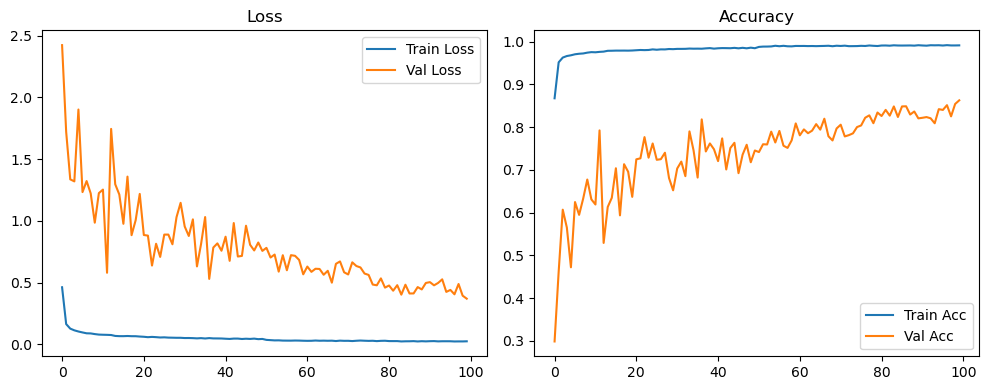

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2719, Acc: 0.9573 | Val Loss: 0.1714, Acc: 0.9521


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9843 | Val Loss: 0.2089, Acc: 0.9353


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9894 | Val Loss: 0.3466, Acc: 0.8909


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9925 | Val Loss: 0.0688, Acc: 0.9794


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9942 | Val Loss: 0.0511, Acc: 0.9840


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.0493, Acc: 0.9842


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1128, Acc: 0.9648


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.0778, Acc: 0.9762


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.1351, Acc: 0.9604


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.2425, Acc: 0.9261


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1281, Acc: 0.9648


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0553, Acc: 0.9848


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0714, Acc: 0.9788


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.2857, Acc: 0.9278


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0629, Acc: 0.9839


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0755, Acc: 0.9779


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0818, Acc: 0.9782


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0692, Acc: 0.9825


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1115, Acc: 0.9697


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0559, Acc: 0.9859


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0986, Acc: 0.9733


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0874, Acc: 0.9794


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1057, Acc: 0.9753


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0626, Acc: 0.9848


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0599, Acc: 0.9852


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0805, Acc: 0.9812


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0537, Acc: 0.9872


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0752, Acc: 0.9828


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0877, Acc: 0.9801


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1122, Acc: 0.9754


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0649, Acc: 0.9850


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0639, Acc: 0.9842


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0522, Acc: 0.9886


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0696, Acc: 0.9848


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0530, Acc: 0.9878


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0552, Acc: 0.9881


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0688, Acc: 0.9859


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0633, Acc: 0.9880


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0513, Acc: 0.9889


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0597, Acc: 0.9876


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0759, Acc: 0.9822


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0588, Acc: 0.9882


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0638, Acc: 0.9874


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0577, Acc: 0.9878


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0681, Acc: 0.9853


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0578, Acc: 0.9865


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0616, Acc: 0.9865


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0593, Acc: 0.9880


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0665, Acc: 0.9875


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0632, Acc: 0.9872


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0798, Acc: 0.9850


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0610, Acc: 0.9889


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0526, Acc: 0.9896


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9900


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0539, Acc: 0.9897


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1323, Acc: 0.9747


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0842, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0697, Acc: 0.9873


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0631, Acc: 0.9882


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9892


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9892


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9888


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9899


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0949, Acc: 0.9818


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0664, Acc: 0.9875


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0585, Acc: 0.9892


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0688, Acc: 0.9858


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0794, Acc: 0.9852


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0618, Acc: 0.9882


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0827, Acc: 0.9850


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0626, Acc: 0.9866


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0801, Acc: 0.9853


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0705, Acc: 0.9868


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0574, Acc: 0.9887


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9892


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9889


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0663, Acc: 0.9880


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1067, Acc: 0.9827


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0680, Acc: 0.9871


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0803, Acc: 0.9862


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0641, Acc: 0.9870


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0595, Acc: 0.9878


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0790, Acc: 0.9860


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0648, Acc: 0.9878


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0603, Acc: 0.9882


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0765, Acc: 0.9868


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0600, Acc: 0.9888


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9896


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9893


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9898


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9903


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9897


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9899


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9907


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9903


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9905


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9908


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1343, Acc: 0.9753


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0838, Acc: 0.9856


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0658, Acc: 0.9880


Final Test Loss: 0.0571 Accuracy: 0.9890


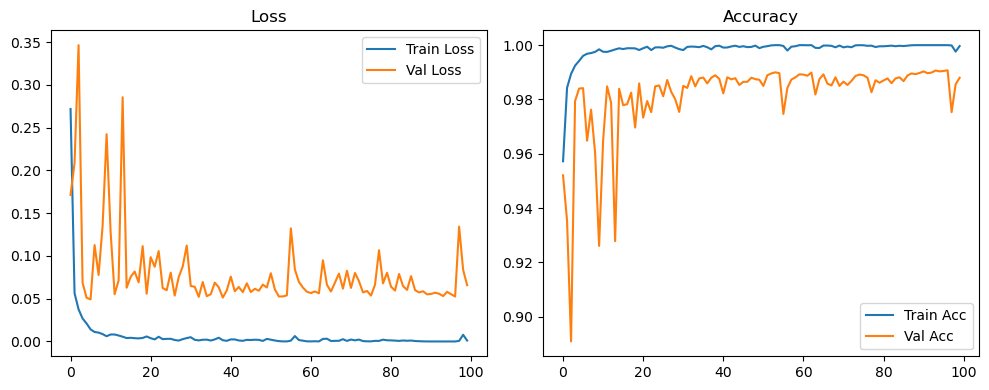

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3406, Acc: 0.9365 | Val Loss: 1.6438, Acc: 0.4309


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0915, Acc: 0.9738 | Val Loss: 1.1421, Acc: 0.5925


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9805 | Val Loss: 0.9619, Acc: 0.6803


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9831 | Val Loss: 0.9743, Acc: 0.6771


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9851 | Val Loss: 1.0094, Acc: 0.6890


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 0.5086, Acc: 0.8263


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9880 | Val Loss: 0.9877, Acc: 0.7123


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.5252, Acc: 0.8523


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.5985, Acc: 0.8252


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.4529, Acc: 0.8640


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.5339, Acc: 0.8488


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.4007, Acc: 0.8699


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.5684, Acc: 0.8303


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.6461, Acc: 0.8144


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.4389, Acc: 0.8772


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.3867, Acc: 0.8910


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.3132, Acc: 0.9121


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.2483, Acc: 0.9281


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.3222, Acc: 0.9148


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.2712, Acc: 0.9293


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9946 | Val Loss: 0.2280, Acc: 0.9397


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.3308, Acc: 0.9123


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.1764, Acc: 0.9507


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.2500, Acc: 0.9321


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.2345, Acc: 0.9383


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.2445, Acc: 0.9363


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.2374, Acc: 0.9385


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9954 | Val Loss: 0.1480, Acc: 0.9595


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9962 | Val Loss: 0.2069, Acc: 0.9448


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1874, Acc: 0.9527


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1955, Acc: 0.9493


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1455, Acc: 0.9603


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.2424, Acc: 0.9393


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1755, Acc: 0.9561


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1902, Acc: 0.9531


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.2010, Acc: 0.9517


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1808, Acc: 0.9582


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1753, Acc: 0.9605


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.2393, Acc: 0.9409


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.2192, Acc: 0.9518


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1948, Acc: 0.9550


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1575, Acc: 0.9641


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.2152, Acc: 0.9521


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.2152, Acc: 0.9515


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1180, Acc: 0.9719


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1239, Acc: 0.9707


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1526, Acc: 0.9661


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.1740, Acc: 0.9585


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.1278, Acc: 0.9719


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1705, Acc: 0.9615


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1472, Acc: 0.9665


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1777, Acc: 0.9613


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1569, Acc: 0.9654


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1889, Acc: 0.9600


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.2140, Acc: 0.9536


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1308, Acc: 0.9707


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1675, Acc: 0.9642


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1123, Acc: 0.9764


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.1488, Acc: 0.9687


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1481, Acc: 0.9698


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1413, Acc: 0.9690


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1677, Acc: 0.9633


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1496, Acc: 0.9695


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1579, Acc: 0.9665


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1184, Acc: 0.9739


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1409, Acc: 0.9703


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.1451, Acc: 0.9687


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.2215, Acc: 0.9543


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1288, Acc: 0.9729


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1610, Acc: 0.9671


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1369, Acc: 0.9715


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1181, Acc: 0.9748


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.2218, Acc: 0.9547


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1670, Acc: 0.9680


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.1775, Acc: 0.9655


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1576, Acc: 0.9675


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1636, Acc: 0.9683


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1200, Acc: 0.9753


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.1641, Acc: 0.9666


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1737, Acc: 0.9659


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1742, Acc: 0.9663


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0996, Acc: 0.9797


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1729, Acc: 0.9681


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1373, Acc: 0.9728


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.2077, Acc: 0.9617


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1962, Acc: 0.9630


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1582, Acc: 0.9707


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.1618, Acc: 0.9692


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1485, Acc: 0.9717


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.2349, Acc: 0.9559


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1871, Acc: 0.9653


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2145, Acc: 0.9598


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1575, Acc: 0.9704


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1421, Acc: 0.9729


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1656, Acc: 0.9686


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1302, Acc: 0.9738


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1660, Acc: 0.9673


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1588, Acc: 0.9693


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1307, Acc: 0.9738


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1765, Acc: 0.9679


Final Test Loss: 0.1938 Accuracy: 0.9645


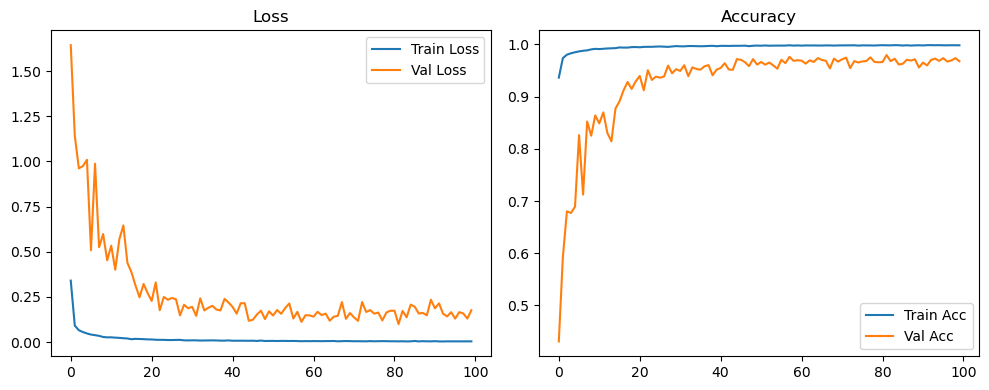

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5913, Acc: 0.8434 | Val Loss: 2.5284, Acc: 0.2319


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1975, Acc: 0.9424 | Val Loss: 2.5886, Acc: 0.2673


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1463, Acc: 0.9575 | Val Loss: 2.3359, Acc: 0.3215


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1256, Acc: 0.9639 | Val Loss: 2.6483, Acc: 0.3083


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1107, Acc: 0.9664 | Val Loss: 2.7230, Acc: 0.3493


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1059, Acc: 0.9681 | Val Loss: 2.9560, Acc: 0.2937


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0976, Acc: 0.9699 | Val Loss: 2.5994, Acc: 0.3017


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0920, Acc: 0.9714 | Val Loss: 2.3405, Acc: 0.3606


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0885, Acc: 0.9733 | Val Loss: 1.8615, Acc: 0.4569


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0826, Acc: 0.9753 | Val Loss: 2.0101, Acc: 0.4360


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9738 | Val Loss: 1.7620, Acc: 0.4883


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9751 | Val Loss: 1.5267, Acc: 0.5100


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0786, Acc: 0.9763 | Val Loss: 2.5911, Acc: 0.3801


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9767 | Val Loss: 1.9570, Acc: 0.4538


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9778 | Val Loss: 1.7459, Acc: 0.5016


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9791 | Val Loss: 2.1615, Acc: 0.4232


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9786 | Val Loss: 1.6609, Acc: 0.5272


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0668, Acc: 0.9794 | Val Loss: 1.7352, Acc: 0.5351


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0660, Acc: 0.9792 | Val Loss: 2.0616, Acc: 0.4655


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9798 | Val Loss: 1.9540, Acc: 0.4922


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9800 | Val Loss: 1.9288, Acc: 0.5068


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9807 | Val Loss: 1.9983, Acc: 0.4958


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9809 | Val Loss: 1.2840, Acc: 0.6118


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9801 | Val Loss: 1.3640, Acc: 0.5887


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9807 | Val Loss: 1.4801, Acc: 0.5995


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9811 | Val Loss: 1.6454, Acc: 0.5541


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9814 | Val Loss: 1.5911, Acc: 0.5672


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9820 | Val Loss: 1.6813, Acc: 0.5422


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9819 | Val Loss: 2.2410, Acc: 0.4389


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9815 | Val Loss: 2.5773, Acc: 0.4124


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9824 | Val Loss: 1.8444, Acc: 0.4830


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9831 | Val Loss: 1.4688, Acc: 0.5625


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9832 | Val Loss: 1.6752, Acc: 0.5392


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 1.6478, Acc: 0.5487


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 1.4205, Acc: 0.5934


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9832 | Val Loss: 1.6622, Acc: 0.5567


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9831 | Val Loss: 1.0881, Acc: 0.6623


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9833 | Val Loss: 1.3836, Acc: 0.6048


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 1.2164, Acc: 0.6629


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9836 | Val Loss: 1.1083, Acc: 0.6558


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 1.1180, Acc: 0.6630


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9851 | Val Loss: 1.1665, Acc: 0.6681


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 1.1877, Acc: 0.6648


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9836 | Val Loss: 1.0270, Acc: 0.6861


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9845 | Val Loss: 1.2352, Acc: 0.6314


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 1.0402, Acc: 0.6870


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9855 | Val Loss: 1.1786, Acc: 0.6392


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 1.0875, Acc: 0.6758


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9853 | Val Loss: 1.3535, Acc: 0.6051


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9853 | Val Loss: 1.0945, Acc: 0.6774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 1.3422, Acc: 0.6292


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9857 | Val Loss: 1.1222, Acc: 0.6567


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9859 | Val Loss: 0.8480, Acc: 0.7418


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.9094, Acc: 0.7267


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9868 | Val Loss: 1.0345, Acc: 0.7104


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9851 | Val Loss: 1.2020, Acc: 0.6429


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9854 | Val Loss: 1.2451, Acc: 0.6148


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 1.2753, Acc: 0.6129


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9854 | Val Loss: 1.2929, Acc: 0.6218


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9863 | Val Loss: 1.0315, Acc: 0.6870


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9857 | Val Loss: 1.1490, Acc: 0.6402


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 1.1536, Acc: 0.6477


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9861 | Val Loss: 1.1089, Acc: 0.6462


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9855 | Val Loss: 0.9930, Acc: 0.6878


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9869 | Val Loss: 0.9938, Acc: 0.6931


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 0.9945, Acc: 0.6964


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9865 | Val Loss: 0.9185, Acc: 0.7039


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 1.0536, Acc: 0.6647


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9865 | Val Loss: 1.1482, Acc: 0.6398


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 1.1027, Acc: 0.6653


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.9995, Acc: 0.6813


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 1.2452, Acc: 0.6381


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 1.3586, Acc: 0.6165


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9865 | Val Loss: 1.3043, Acc: 0.6004


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.8919, Acc: 0.7072


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9866 | Val Loss: 0.7884, Acc: 0.7424


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9872 | Val Loss: 1.1267, Acc: 0.6500


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9875 | Val Loss: 0.9881, Acc: 0.6907


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9876 | Val Loss: 1.0731, Acc: 0.6546


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9870 | Val Loss: 1.0380, Acc: 0.6707


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9873 | Val Loss: 0.9934, Acc: 0.6869


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9877 | Val Loss: 0.8499, Acc: 0.7255


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.9507, Acc: 0.7028


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9881 | Val Loss: 0.9760, Acc: 0.6872


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9872 | Val Loss: 1.0477, Acc: 0.6703


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 1.0149, Acc: 0.6726


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9880 | Val Loss: 1.0202, Acc: 0.6908


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9877 | Val Loss: 0.9713, Acc: 0.6977


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9876 | Val Loss: 1.0233, Acc: 0.6663


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9873 | Val Loss: 0.8567, Acc: 0.7216


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9878 | Val Loss: 0.9401, Acc: 0.6971


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 0.8500, Acc: 0.7073


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9875 | Val Loss: 0.8610, Acc: 0.7179


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9884 | Val Loss: 1.0193, Acc: 0.6693


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9879 | Val Loss: 0.8793, Acc: 0.7187


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9880 | Val Loss: 1.1849, Acc: 0.6432


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 1.2317, Acc: 0.6300


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 1.3119, Acc: 0.6013


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.6964, Acc: 0.7449


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.6925, Acc: 0.7601


Final Test Loss: 0.6620 Accuracy: 0.7716


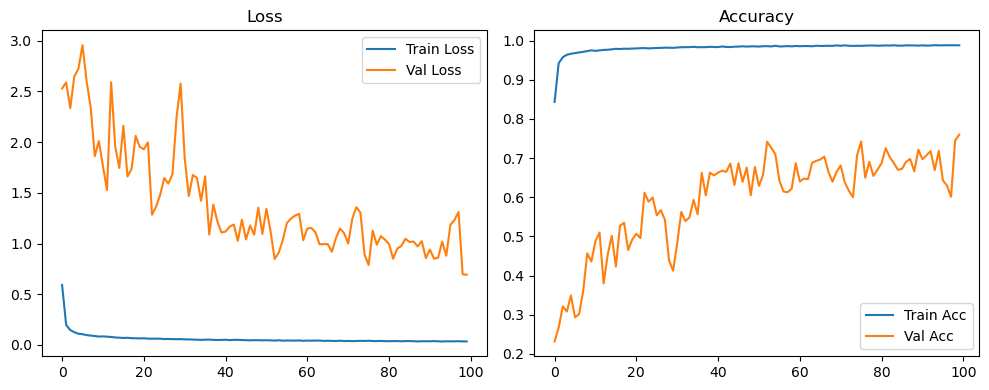

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2722, Acc: 0.9573 | Val Loss: 0.1319, Acc: 0.9653


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9842 | Val Loss: 0.1949, Acc: 0.9397


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9892 | Val Loss: 0.3770, Acc: 0.8590


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9920 | Val Loss: 0.0825, Acc: 0.9747


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9943 | Val Loss: 0.0715, Acc: 0.9772


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9962 | Val Loss: 0.0908, Acc: 0.9728


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.2480, Acc: 0.9335


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0741, Acc: 0.9764


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0832, Acc: 0.9738


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.0531, Acc: 0.9848


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0775, Acc: 0.9779


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0481, Acc: 0.9865


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0867, Acc: 0.9771


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0701, Acc: 0.9808


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1082, Acc: 0.9704


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0659, Acc: 0.9820


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1317, Acc: 0.9668


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1284, Acc: 0.9646


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0571, Acc: 0.9868


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0616, Acc: 0.9853


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1418, Acc: 0.9633


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1432, Acc: 0.9672


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0974, Acc: 0.9780


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0583, Acc: 0.9857


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0904, Acc: 0.9795


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0590, Acc: 0.9868


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0686, Acc: 0.9836


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0602, Acc: 0.9868


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0742, Acc: 0.9830


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0986, Acc: 0.9791


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0526, Acc: 0.9883


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0745, Acc: 0.9842


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0628, Acc: 0.9869


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0580, Acc: 0.9874


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0643, Acc: 0.9865


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0898, Acc: 0.9808


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0690, Acc: 0.9845


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0618, Acc: 0.9869


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0564, Acc: 0.9875


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0613, Acc: 0.9882


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0632, Acc: 0.9871


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0879, Acc: 0.9814


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0719, Acc: 0.9848


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0771, Acc: 0.9848


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0706, Acc: 0.9849


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0691, Acc: 0.9859


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0639, Acc: 0.9874


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0662, Acc: 0.9866


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1005, Acc: 0.9817


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0677, Acc: 0.9882


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0624, Acc: 0.9883


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9888


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9898


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9898


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9898


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9892


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9895


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9892


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9890


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0588, Acc: 0.9896


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0562, Acc: 0.9897


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9893


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9892


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9902


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9899


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0659, Acc: 0.9880


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0616, Acc: 0.9885


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9897


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9893


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0589, Acc: 0.9893


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9900


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9899


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9898


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0732, Acc: 0.9866


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0638, Acc: 0.9894


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9900


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9891


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9898


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9898


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9898


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9895


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9895


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9905


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9894


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9896


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9896


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9902


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9898


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9896


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9896


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9903


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9900


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9895


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9895


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9888


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9892


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9902


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9899


Final Test Loss: 0.0586 Accuracy: 0.9898


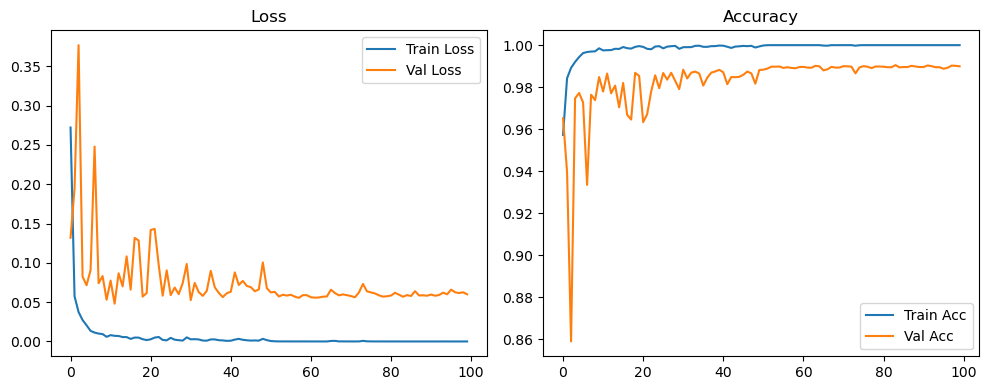

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3402, Acc: 0.9365 | Val Loss: 1.5965, Acc: 0.4333


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0913, Acc: 0.9734 | Val Loss: 0.8596, Acc: 0.6909


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9806 | Val Loss: 0.7624, Acc: 0.7346


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9834 | Val Loss: 1.1201, Acc: 0.6552


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.8554, Acc: 0.7246


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9867 | Val Loss: 0.6696, Acc: 0.7771


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9877 | Val Loss: 0.7304, Acc: 0.7649


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9884 | Val Loss: 0.6713, Acc: 0.8129


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.5961, Acc: 0.8193


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.2793, Acc: 0.9113


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.3195, Acc: 0.9004


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.5312, Acc: 0.8229


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.5388, Acc: 0.8386


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.3578, Acc: 0.8918


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.3837, Acc: 0.8872


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9939 | Val Loss: 0.5754, Acc: 0.8427


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.4641, Acc: 0.8668


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.4157, Acc: 0.8820


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.4388, Acc: 0.8770


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.4329, Acc: 0.8810


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.2149, Acc: 0.9386


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.3888, Acc: 0.8986


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.2540, Acc: 0.9324


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.2830, Acc: 0.9195


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.2593, Acc: 0.9314


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.3731, Acc: 0.9056


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.2459, Acc: 0.9351


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9954 | Val Loss: 0.1485, Acc: 0.9607


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1959, Acc: 0.9493


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.2687, Acc: 0.9353


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.1835, Acc: 0.9512


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.2665, Acc: 0.9364


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.2342, Acc: 0.9447


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1489, Acc: 0.9612


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1521, Acc: 0.9650


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.2983, Acc: 0.9234


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.1388, Acc: 0.9665


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1509, Acc: 0.9609


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1691, Acc: 0.9585


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.2731, Acc: 0.9367


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1422, Acc: 0.9665


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.1309, Acc: 0.9666


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.1514, Acc: 0.9624


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9969 | Val Loss: 0.1567, Acc: 0.9607


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.2110, Acc: 0.9488


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1408, Acc: 0.9661


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.3349, Acc: 0.9233


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1608, Acc: 0.9633


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9972 | Val Loss: 0.1825, Acc: 0.9562


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1627, Acc: 0.9611


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1441, Acc: 0.9667


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1367, Acc: 0.9702


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1329, Acc: 0.9702


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1191, Acc: 0.9736


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1218, Acc: 0.9733


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1234, Acc: 0.9721


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1525, Acc: 0.9649


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1455, Acc: 0.9679


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1346, Acc: 0.9708


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1278, Acc: 0.9720


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1212, Acc: 0.9739


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1272, Acc: 0.9715


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1342, Acc: 0.9701


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1217, Acc: 0.9725


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1131, Acc: 0.9758


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1181, Acc: 0.9739


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1066, Acc: 0.9770


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1423, Acc: 0.9698


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1381, Acc: 0.9713


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1278, Acc: 0.9734


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1432, Acc: 0.9699


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1636, Acc: 0.9651


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1501, Acc: 0.9691


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1981, Acc: 0.9589


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1530, Acc: 0.9692


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1713, Acc: 0.9647


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1690, Acc: 0.9639


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1481, Acc: 0.9695


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1148, Acc: 0.9779


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1413, Acc: 0.9711


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1410, Acc: 0.9718


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1200, Acc: 0.9746


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1239, Acc: 0.9745


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1287, Acc: 0.9722


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1372, Acc: 0.9715


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1459, Acc: 0.9692


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1106, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1182, Acc: 0.9767


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1221, Acc: 0.9760


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1150, Acc: 0.9765


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1274, Acc: 0.9745


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1200, Acc: 0.9757


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1490, Acc: 0.9700


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1222, Acc: 0.9763


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1289, Acc: 0.9751


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1226, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1453, Acc: 0.9714


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1225, Acc: 0.9770


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1192, Acc: 0.9760


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1244, Acc: 0.9753


Final Test Loss: 0.1392 Accuracy: 0.9732


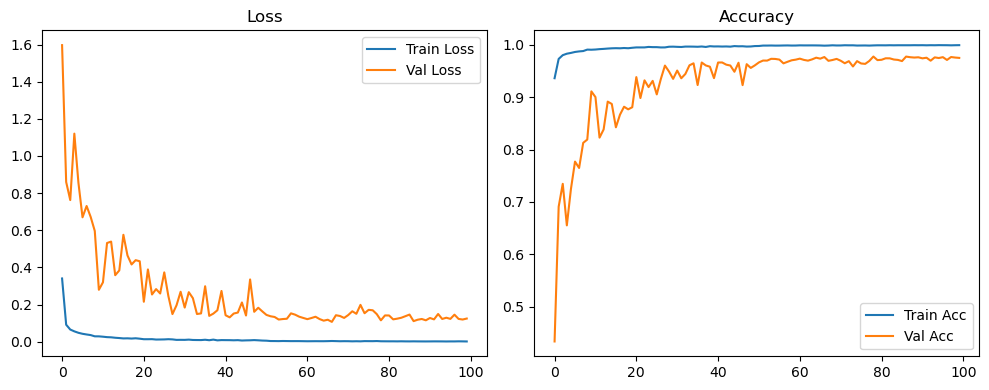

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5908, Acc: 0.8440 | Val Loss: 2.5162, Acc: 0.2375


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1972, Acc: 0.9422 | Val Loss: 2.6914, Acc: 0.2581


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1441, Acc: 0.9586 | Val Loss: 2.3286, Acc: 0.3357


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1242, Acc: 0.9633 | Val Loss: 2.5381, Acc: 0.3087


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1108, Acc: 0.9672 | Val Loss: 2.8750, Acc: 0.3224


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1052, Acc: 0.9681 | Val Loss: 2.5816, Acc: 0.3325


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0969, Acc: 0.9715 | Val Loss: 2.6357, Acc: 0.3137


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0927, Acc: 0.9713 | Val Loss: 2.3447, Acc: 0.3713


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9721 | Val Loss: 1.7193, Acc: 0.4928


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0837, Acc: 0.9754 | Val Loss: 1.7685, Acc: 0.4737


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0837, Acc: 0.9738 | Val Loss: 2.0367, Acc: 0.4392


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0805, Acc: 0.9754 | Val Loss: 1.8644, Acc: 0.4744


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0784, Acc: 0.9765 | Val Loss: 2.2501, Acc: 0.4141


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0750, Acc: 0.9766 | Val Loss: 2.0349, Acc: 0.4581


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9780 | Val Loss: 1.4165, Acc: 0.5948


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0707, Acc: 0.9786 | Val Loss: 1.7686, Acc: 0.5231


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9790 | Val Loss: 1.8446, Acc: 0.4969


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0667, Acc: 0.9794 | Val Loss: 1.7629, Acc: 0.5150


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0666, Acc: 0.9794 | Val Loss: 1.8993, Acc: 0.5014


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9801 | Val Loss: 1.7649, Acc: 0.5326


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9798 | Val Loss: 1.6104, Acc: 0.6005


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9805 | Val Loss: 1.2610, Acc: 0.6739


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9808 | Val Loss: 0.9644, Acc: 0.7094


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9801 | Val Loss: 1.3635, Acc: 0.6049


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9811 | Val Loss: 1.7279, Acc: 0.5612


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9816 | Val Loss: 1.5313, Acc: 0.6257


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9818 | Val Loss: 1.2054, Acc: 0.6715


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9820 | Val Loss: 1.8195, Acc: 0.5452


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9812 | Val Loss: 1.7900, Acc: 0.5295


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9814 | Val Loss: 2.0275, Acc: 0.4960


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9824 | Val Loss: 1.7945, Acc: 0.4989


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9829 | Val Loss: 1.1971, Acc: 0.6378


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 1.4356, Acc: 0.6067


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9834 | Val Loss: 1.3594, Acc: 0.6227


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9837 | Val Loss: 1.2142, Acc: 0.6493


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9836 | Val Loss: 1.7893, Acc: 0.5110


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9831 | Val Loss: 0.8717, Acc: 0.7295


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9839 | Val Loss: 1.2966, Acc: 0.6203


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9839 | Val Loss: 1.2470, Acc: 0.6547


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9830 | Val Loss: 1.0049, Acc: 0.6973


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9834 | Val Loss: 0.9572, Acc: 0.6997


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9847 | Val Loss: 0.8480, Acc: 0.7345


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 1.0678, Acc: 0.6917


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 1.0891, Acc: 0.6843


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9852 | Val Loss: 1.1312, Acc: 0.6635


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9842 | Val Loss: 1.0820, Acc: 0.6929


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 1.0219, Acc: 0.7042


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9846 | Val Loss: 0.9414, Acc: 0.7147


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.9371, Acc: 0.7182


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 1.0299, Acc: 0.7013


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9872 | Val Loss: 0.9697, Acc: 0.7114


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9871 | Val Loss: 1.0505, Acc: 0.6908


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9877 | Val Loss: 0.8853, Acc: 0.7302


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9871 | Val Loss: 0.9046, Acc: 0.7222


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.9411, Acc: 0.7290


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.8201, Acc: 0.7514


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 1.1348, Acc: 0.6721


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 1.1537, Acc: 0.6596


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 1.1324, Acc: 0.6693


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.9457, Acc: 0.7192


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9874 | Val Loss: 1.0204, Acc: 0.6888


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9881 | Val Loss: 1.0143, Acc: 0.6960


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.8871, Acc: 0.7238


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.8159, Acc: 0.7472


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9880 | Val Loss: 0.8758, Acc: 0.7272


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.8054, Acc: 0.7542


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9885 | Val Loss: 0.9229, Acc: 0.7221


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9891 | Val Loss: 1.0171, Acc: 0.6961


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9888 | Val Loss: 1.1109, Acc: 0.6876


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.9002, Acc: 0.7282


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.7925, Acc: 0.7640


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9895 | Val Loss: 0.8393, Acc: 0.7447


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.8768, Acc: 0.7302


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9890 | Val Loss: 1.0041, Acc: 0.6951


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9884 | Val Loss: 0.7721, Acc: 0.7566


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.8595, Acc: 0.7381


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.9871, Acc: 0.6948


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 1.0270, Acc: 0.6936


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.9570, Acc: 0.6978


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.9739, Acc: 0.6997


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.8173, Acc: 0.7344


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.7801, Acc: 0.7431


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.8421, Acc: 0.7298


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.8389, Acc: 0.7257


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.8671, Acc: 0.7184


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.8273, Acc: 0.7306


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.8570, Acc: 0.7265


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9899 | Val Loss: 0.9217, Acc: 0.7100


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.9160, Acc: 0.7081


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9903 | Val Loss: 1.0091, Acc: 0.6912


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.9814, Acc: 0.6941


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.7770, Acc: 0.7459


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.7966, Acc: 0.7454


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.7559, Acc: 0.7600


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.7623, Acc: 0.7502


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9894 | Val Loss: 0.7919, Acc: 0.7383


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.7234, Acc: 0.7636


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.9848, Acc: 0.6937


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9903 | Val Loss: 0.7258, Acc: 0.7582


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.7547, Acc: 0.7548


Final Test Loss: 0.7321 Accuracy: 0.7670


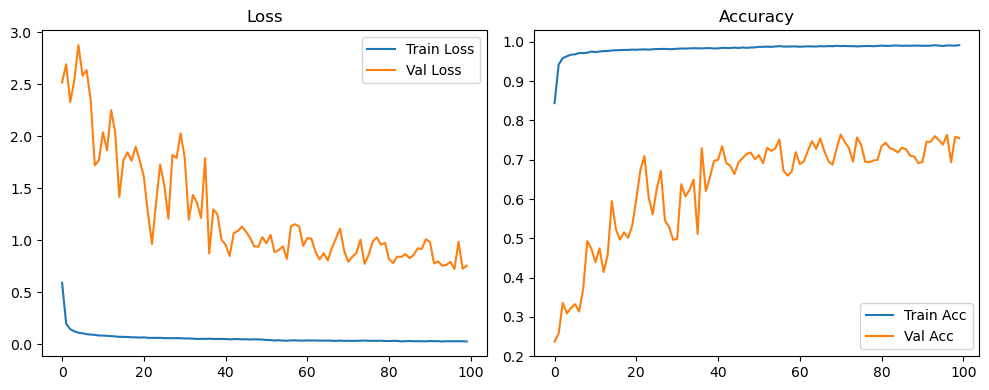

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4539, Acc: 0.9561 | Val Loss: 0.1894, Acc: 0.9656


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9843 | Val Loss: 0.2181, Acc: 0.9423


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0478, Acc: 0.9896 | Val Loss: 0.3455, Acc: 0.8896


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9926 | Val Loss: 0.0869, Acc: 0.9774


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9945 | Val Loss: 0.0590, Acc: 0.9820


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9963 | Val Loss: 0.1192, Acc: 0.9623


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9972 | Val Loss: 0.0781, Acc: 0.9762


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9981 | Val Loss: 0.1542, Acc: 0.9538


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.2204, Acc: 0.9303


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9987 | Val Loss: 0.1314, Acc: 0.9595


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.3703, Acc: 0.8945


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.2333, Acc: 0.9223


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9991 | Val Loss: 0.0594, Acc: 0.9827


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.0713, Acc: 0.9797


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1422, Acc: 0.9570


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.0669, Acc: 0.9819


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1769, Acc: 0.9519


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0708, Acc: 0.9779


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0936, Acc: 0.9723


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.0601, Acc: 0.9839


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0717, Acc: 0.9788


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1382, Acc: 0.9634


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0476, Acc: 0.9872


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0548, Acc: 0.9843


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0809, Acc: 0.9778


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.0555, Acc: 0.9869


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0651, Acc: 0.9853


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 1.2426, Acc: 0.7451


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1008, Acc: 0.9746


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0566, Acc: 0.9853


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0468, Acc: 0.9889


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9888


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0535, Acc: 0.9884


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0820, Acc: 0.9790


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.0591, Acc: 0.9848


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0838, Acc: 0.9798


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0586, Acc: 0.9859


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0606, Acc: 0.9857


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0543, Acc: 0.9863


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0585, Acc: 0.9872


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9880


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2875, Acc: 0.9218


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0615, Acc: 0.9862


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0536, Acc: 0.9880


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0551, Acc: 0.9878


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0544, Acc: 0.9883


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0490, Acc: 0.9879


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0839, Acc: 0.9824


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0682, Acc: 0.9827


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0981, Acc: 0.9777


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0506, Acc: 0.9888


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0519, Acc: 0.9882


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0590, Acc: 0.9879


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9878


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0612, Acc: 0.9866


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9892


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9872


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0965, Acc: 0.9789


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0681, Acc: 0.9838


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0582, Acc: 0.9869


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0554, Acc: 0.9888


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9862


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0786, Acc: 0.9818


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0624, Acc: 0.9862


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0695, Acc: 0.9845


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0574, Acc: 0.9881


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0591, Acc: 0.9863


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9874


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9892


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9888


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0837, Acc: 0.9816


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0719, Acc: 0.9861


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0554, Acc: 0.9883


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9884


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0544, Acc: 0.9890


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9879


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9878


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1131, Acc: 0.9770


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0647, Acc: 0.9872


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9880


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0598, Acc: 0.9885


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9883


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0547, Acc: 0.9890


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9883


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0772, Acc: 0.9842


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1115, Acc: 0.9782


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0605, Acc: 0.9873


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0685, Acc: 0.9864


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0861, Acc: 0.9845


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9892


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9891


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9892


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9896


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9888


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0879, Acc: 0.9823


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0698, Acc: 0.9871


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0620, Acc: 0.9873


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0666, Acc: 0.9870


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9887


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9888


Final Test Loss: 0.0514 Accuracy: 0.9888


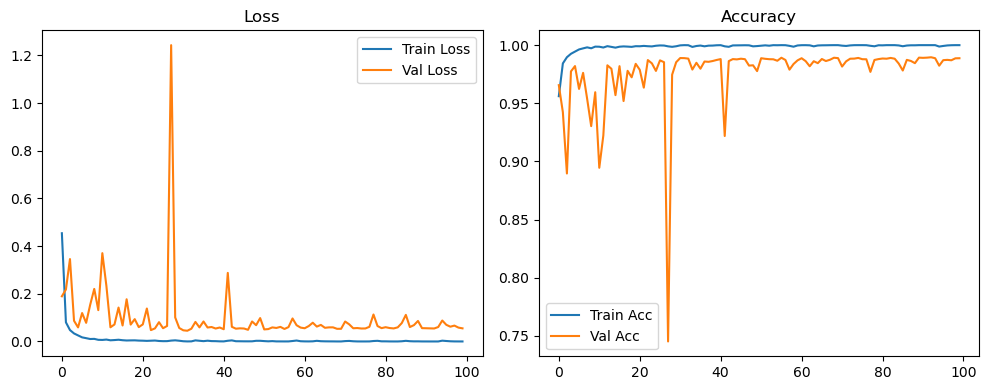

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5475, Acc: 0.9294 | Val Loss: 2.3778, Acc: 0.2166


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1266, Acc: 0.9717 | Val Loss: 1.4936, Acc: 0.4458


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0831, Acc: 0.9786 | Val Loss: 1.4643, Acc: 0.5295


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9812 | Val Loss: 1.7580, Acc: 0.4935


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9836 | Val Loss: 1.2779, Acc: 0.5975


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9859 | Val Loss: 1.8884, Acc: 0.4858


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9863 | Val Loss: 1.5247, Acc: 0.5847


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9863 | Val Loss: 1.5049, Acc: 0.6252


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9888 | Val Loss: 1.3668, Acc: 0.6152


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 1.5694, Acc: 0.5848


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.9560, Acc: 0.6960


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 1.3567, Acc: 0.6159


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9917 | Val Loss: 1.2557, Acc: 0.6841


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 1.0004, Acc: 0.6975


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 1.3301, Acc: 0.6686


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.7888, Acc: 0.7972


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 1.8721, Acc: 0.5528


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 1.0181, Acc: 0.7309


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 1.4115, Acc: 0.6866


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 1.7240, Acc: 0.6122


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.7751, Acc: 0.8104


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 1.0483, Acc: 0.7397


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.5788, Acc: 0.8464


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.8017, Acc: 0.8007


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.9768, Acc: 0.7608


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.7664, Acc: 0.8072


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9953 | Val Loss: 0.7799, Acc: 0.7967


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.4107, Acc: 0.8866


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.4196, Acc: 0.8842


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.3549, Acc: 0.9044


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.5545, Acc: 0.8451


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.7303, Acc: 0.8203


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.6013, Acc: 0.8497


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.5953, Acc: 0.8569


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.3199, Acc: 0.9115


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.6752, Acc: 0.8337


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.4653, Acc: 0.8802


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.5156, Acc: 0.8798


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.7633, Acc: 0.8403


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.6535, Acc: 0.8548


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.6164, Acc: 0.8469


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.6502, Acc: 0.8487


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.5739, Acc: 0.8681


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.4342, Acc: 0.8939


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.4519, Acc: 0.8899


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.5222, Acc: 0.8748


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.6549, Acc: 0.8448


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.4322, Acc: 0.8972


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.3533, Acc: 0.9183


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.5090, Acc: 0.8767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.3818, Acc: 0.9133


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.6250, Acc: 0.8564


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.4217, Acc: 0.9009


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.2444, Acc: 0.9383


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.3348, Acc: 0.9223


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.3872, Acc: 0.9110


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.4311, Acc: 0.9085


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.2943, Acc: 0.9287


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.3560, Acc: 0.9193


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.4783, Acc: 0.8871


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.5513, Acc: 0.8730


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.3629, Acc: 0.9158


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.3232, Acc: 0.9298


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.3279, Acc: 0.9241


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.3024, Acc: 0.9302


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.4323, Acc: 0.9032


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.3860, Acc: 0.9146


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.4246, Acc: 0.9117


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.3898, Acc: 0.9136


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.3296, Acc: 0.9273


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.4353, Acc: 0.9071


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.4180, Acc: 0.9093


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.4193, Acc: 0.9146


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.3752, Acc: 0.9208


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.4904, Acc: 0.9024


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.5163, Acc: 0.8965


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.3305, Acc: 0.9269


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.5575, Acc: 0.8874


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.3235, Acc: 0.9289


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.4559, Acc: 0.9026


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.4711, Acc: 0.9082


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.3203, Acc: 0.9302


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.4715, Acc: 0.9060


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.4750, Acc: 0.9020


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.6153, Acc: 0.8760


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.5374, Acc: 0.8911


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.3927, Acc: 0.9160


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.3865, Acc: 0.9218


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.4354, Acc: 0.9094


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.3304, Acc: 0.9290


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.3523, Acc: 0.9265


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.3173, Acc: 0.9358


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.3193, Acc: 0.9333


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.3893, Acc: 0.9217


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.2894, Acc: 0.9413


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.3278, Acc: 0.9304


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.2683, Acc: 0.9433


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.3000, Acc: 0.9388


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.3416, Acc: 0.9325


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.2738, Acc: 0.9447


Final Test Loss: 0.2963 Accuracy: 0.9442


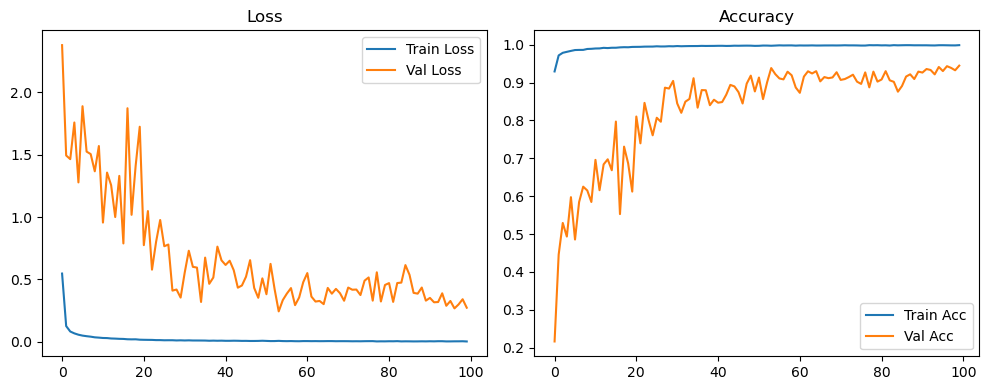

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.8782, Acc: 0.7896 | Val Loss: 2.8315, Acc: 0.1822


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3001, Acc: 0.9220 | Val Loss: 2.6637, Acc: 0.2298


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2032, Acc: 0.9447 | Val Loss: 2.6697, Acc: 0.2619


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1638, Acc: 0.9534 | Val Loss: 2.9705, Acc: 0.2445


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1406, Acc: 0.9599 | Val Loss: 3.2309, Acc: 0.2724


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1266, Acc: 0.9633 | Val Loss: 3.3650, Acc: 0.2425


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1170, Acc: 0.9661 | Val Loss: 3.3779, Acc: 0.2430


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1082, Acc: 0.9681 | Val Loss: 3.1777, Acc: 0.2487


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1036, Acc: 0.9687 | Val Loss: 3.3373, Acc: 0.2757


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0948, Acc: 0.9720 | Val Loss: 3.1627, Acc: 0.2886


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0950, Acc: 0.9714 | Val Loss: 2.5621, Acc: 0.3734


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0878, Acc: 0.9736 | Val Loss: 2.7131, Acc: 0.3534


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0852, Acc: 0.9751 | Val Loss: 2.4997, Acc: 0.3841


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0812, Acc: 0.9749 | Val Loss: 2.6139, Acc: 0.3559


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0791, Acc: 0.9765 | Val Loss: 2.1914, Acc: 0.4175


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0774, Acc: 0.9772 | Val Loss: 2.0532, Acc: 0.4272


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0769, Acc: 0.9768 | Val Loss: 2.2031, Acc: 0.3919


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0728, Acc: 0.9773 | Val Loss: 2.0238, Acc: 0.4467


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9779 | Val Loss: 2.1735, Acc: 0.4502


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0697, Acc: 0.9790 | Val Loss: 2.1934, Acc: 0.4363


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0704, Acc: 0.9782 | Val Loss: 1.7207, Acc: 0.5290


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9803 | Val Loss: 2.0569, Acc: 0.4624


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0674, Acc: 0.9804 | Val Loss: 1.6495, Acc: 0.5042


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9797 | Val Loss: 1.8803, Acc: 0.4689


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9801 | Val Loss: 2.1085, Acc: 0.4488


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9805 | Val Loss: 1.5433, Acc: 0.5656


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0651, Acc: 0.9810 | Val Loss: 1.5397, Acc: 0.5445


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0611, Acc: 0.9809 | Val Loss: 1.9883, Acc: 0.4687


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9806 | Val Loss: 2.0790, Acc: 0.4417


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0588, Acc: 0.9817 | Val Loss: 1.8190, Acc: 0.5158


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9820 | Val Loss: 2.3151, Acc: 0.4222


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9820 | Val Loss: 1.8006, Acc: 0.5065


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 2.1923, Acc: 0.4278


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9836 | Val Loss: 1.7604, Acc: 0.5354


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9826 | Val Loss: 1.9596, Acc: 0.4389


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9820 | Val Loss: 1.6522, Acc: 0.5423


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9815 | Val Loss: 1.2557, Acc: 0.6255


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9838 | Val Loss: 1.3555, Acc: 0.6135


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9833 | Val Loss: 1.1773, Acc: 0.6733


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9826 | Val Loss: 1.1627, Acc: 0.6498


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0533, Acc: 0.9832 | Val Loss: 0.9186, Acc: 0.7153


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9840 | Val Loss: 1.1083, Acc: 0.6763


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 1.1995, Acc: 0.6695


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9830 | Val Loss: 1.2278, Acc: 0.6338


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9840 | Val Loss: 1.0474, Acc: 0.6792


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9840 | Val Loss: 1.2401, Acc: 0.6298


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9845 | Val Loss: 1.3055, Acc: 0.6208


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9839 | Val Loss: 1.3813, Acc: 0.5860


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 1.6576, Acc: 0.5847


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9843 | Val Loss: 1.5836, Acc: 0.5687


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9841 | Val Loss: 1.3933, Acc: 0.6309


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9844 | Val Loss: 1.5613, Acc: 0.5777


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9848 | Val Loss: 1.3383, Acc: 0.6338


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9846 | Val Loss: 1.4540, Acc: 0.6078


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 1.3844, Acc: 0.6243


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0476, Acc: 0.9856 | Val Loss: 1.3147, Acc: 0.6200


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 1.0401, Acc: 0.6619


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9851 | Val Loss: 1.5435, Acc: 0.5643


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9850 | Val Loss: 1.5798, Acc: 0.5875


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9852 | Val Loss: 1.5356, Acc: 0.5702


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9852 | Val Loss: 1.4792, Acc: 0.5645


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9848 | Val Loss: 1.2888, Acc: 0.6274


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9860 | Val Loss: 1.2927, Acc: 0.6176


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9851 | Val Loss: 1.1267, Acc: 0.6776


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 1.4225, Acc: 0.6052


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9852 | Val Loss: 1.2279, Acc: 0.6472


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9852 | Val Loss: 1.1957, Acc: 0.6484


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 1.4765, Acc: 0.5694


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 1.5398, Acc: 0.5774


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 1.0291, Acc: 0.6947


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 1.3417, Acc: 0.6232


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9865 | Val Loss: 1.7194, Acc: 0.5347


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 1.3130, Acc: 0.6151


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9859 | Val Loss: 1.1221, Acc: 0.6514


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 1.2537, Acc: 0.6343


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9857 | Val Loss: 1.2814, Acc: 0.6215


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 1.3216, Acc: 0.5933


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9861 | Val Loss: 1.2143, Acc: 0.6283


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 1.0749, Acc: 0.6724


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9872 | Val Loss: 1.1577, Acc: 0.6444


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9877 | Val Loss: 0.9323, Acc: 0.6976


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 0.7557, Acc: 0.7490


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 1.1338, Acc: 0.6588


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.7982, Acc: 0.7388


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 1.1079, Acc: 0.6496


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 1.1181, Acc: 0.6486


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.9277, Acc: 0.7005


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 1.0766, Acc: 0.6570


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9869 | Val Loss: 1.1219, Acc: 0.6651


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.9556, Acc: 0.6857


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 1.2130, Acc: 0.6386


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 1.0919, Acc: 0.6787


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9873 | Val Loss: 1.2188, Acc: 0.6356


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 1.1466, Acc: 0.6500


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 1.0222, Acc: 0.6893


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9872 | Val Loss: 0.8875, Acc: 0.7267


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9881 | Val Loss: 1.0799, Acc: 0.6709


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 1.4331, Acc: 0.5982


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.6924, Acc: 0.7717


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9877 | Val Loss: 0.9617, Acc: 0.6908


Final Test Loss: 0.9256 Accuracy: 0.6999


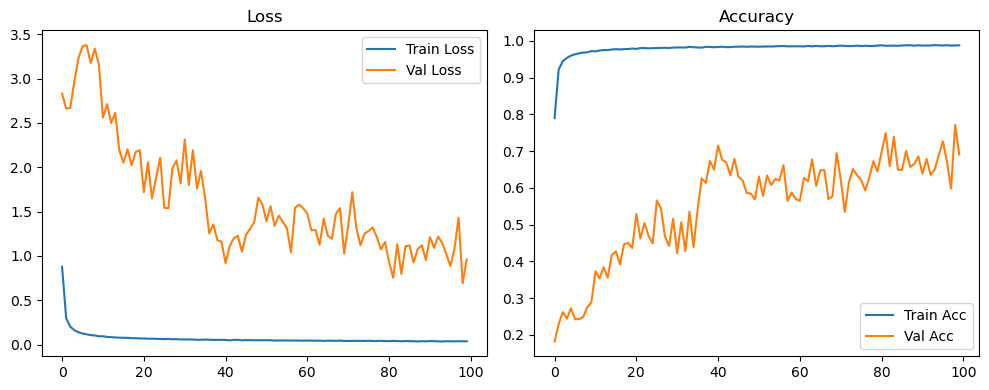

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6964, Acc: 0.9517 | Val Loss: 0.3283, Acc: 0.9652


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1400, Acc: 0.9829 | Val Loss: 0.2204, Acc: 0.9607


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0739, Acc: 0.9885 | Val Loss: 0.3892, Acc: 0.8792


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9918 | Val Loss: 0.1019, Acc: 0.9776


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9937 | Val Loss: 0.1117, Acc: 0.9683


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9953 | Val Loss: 0.0886, Acc: 0.9750


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9965 | Val Loss: 0.1326, Acc: 0.9617


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9981 | Val Loss: 0.0558, Acc: 0.9834


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9981 | Val Loss: 0.1306, Acc: 0.9603


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9984 | Val Loss: 0.1286, Acc: 0.9607


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9990 | Val Loss: 0.0757, Acc: 0.9763


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9993 | Val Loss: 0.1136, Acc: 0.9659


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9984 | Val Loss: 0.1117, Acc: 0.9658


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9989 | Val Loss: 0.0470, Acc: 0.9858


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9989 | Val Loss: 0.1440, Acc: 0.9548


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9991 | Val Loss: 0.1154, Acc: 0.9661


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9989 | Val Loss: 0.0871, Acc: 0.9743


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9994 | Val Loss: 0.1093, Acc: 0.9662


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9994 | Val Loss: 0.1291, Acc: 0.9607


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.0648, Acc: 0.9801


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9994 | Val Loss: 0.0562, Acc: 0.9834


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9872


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9884


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9883


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9878


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9885


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 1.7667, Acc: 0.6048


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1255, Acc: 0.9656


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.0601, Acc: 0.9833


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9999 | Val Loss: 0.0506, Acc: 0.9867


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9891


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9887


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9890


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1152, Acc: 0.9682


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0934, Acc: 0.9715


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.0521, Acc: 0.9862


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9870


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9885


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9883


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9882


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9892


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.9395, Acc: 0.7829


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1520, Acc: 0.9593


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0504, Acc: 0.9867


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0516, Acc: 0.9857


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0490, Acc: 0.9873


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9885


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0939, Acc: 0.9752


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0514, Acc: 0.9861


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0506, Acc: 0.9881


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0561, Acc: 0.9862


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1974, Acc: 0.9500


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0501, Acc: 0.9870


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9872


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9899


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0747, Acc: 0.9818


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9838


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1343, Acc: 0.9667


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0559, Acc: 0.9853


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0469, Acc: 0.9884


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9873


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9894


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9898


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9887


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9889


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9898


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9899


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1359, Acc: 0.9678


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0678, Acc: 0.9846


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0479, Acc: 0.9877


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1001, Acc: 0.9784


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9888


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9879


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9893


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9890


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9892


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9879


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0767, Acc: 0.9809


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0513, Acc: 0.9879


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0510, Acc: 0.9872


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0560, Acc: 0.9874


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9882


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9891


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9892


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9882


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1034, Acc: 0.9748


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0626, Acc: 0.9845


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9886


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9884


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9887


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9895


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9902


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9890


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9899


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9901


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9895


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9895


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0797, Acc: 0.9833


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1200, Acc: 0.9718


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0505, Acc: 0.9878


Final Test Loss: 0.0559 Accuracy: 0.9870


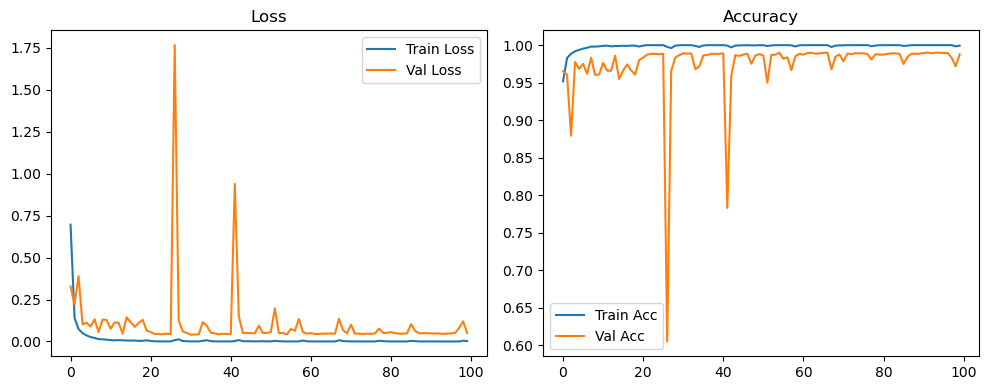

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.8075, Acc: 0.9165 | Val Loss: 1.3585, Acc: 0.4113


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2120, Acc: 0.9679 | Val Loss: 1.0188, Acc: 0.5903


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1215, Acc: 0.9763 | Val Loss: 1.6308, Acc: 0.4572


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0916, Acc: 0.9789 | Val Loss: 2.0745, Acc: 0.3374


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0744, Acc: 0.9818 | Val Loss: 1.6394, Acc: 0.4651


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0639, Acc: 0.9833 | Val Loss: 1.7217, Acc: 0.4782


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0572, Acc: 0.9847 | Val Loss: 1.2590, Acc: 0.6164


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9852 | Val Loss: 1.3440, Acc: 0.6358


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9873 | Val Loss: 1.6133, Acc: 0.5596


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9875 | Val Loss: 0.9908, Acc: 0.6872


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9881 | Val Loss: 1.5289, Acc: 0.4999


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9892 | Val Loss: 1.7531, Acc: 0.5084


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9895 | Val Loss: 1.4306, Acc: 0.6112


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9902 | Val Loss: 1.2095, Acc: 0.6023


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 1.4971, Acc: 0.6442


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.8468, Acc: 0.7803


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9924 | Val Loss: 1.1539, Acc: 0.6790


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 1.2564, Acc: 0.6807


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 1.2846, Acc: 0.6799


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9937 | Val Loss: 1.4050, Acc: 0.6174


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.8327, Acc: 0.8246


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 1.0318, Acc: 0.7613


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 1.2541, Acc: 0.6946


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.8865, Acc: 0.7382


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.8938, Acc: 0.7608


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.9499, Acc: 0.7636


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.8480, Acc: 0.7786


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.6836, Acc: 0.7938


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.7610, Acc: 0.7945


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 1.0154, Acc: 0.7767


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.9592, Acc: 0.7439


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.9499, Acc: 0.7390


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.8000, Acc: 0.7827


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.7886, Acc: 0.7990


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.6411, Acc: 0.8103


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.7705, Acc: 0.7947


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.6189, Acc: 0.8317


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.8930, Acc: 0.8007


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 1.0002, Acc: 0.7565


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.7448, Acc: 0.8131


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.7575, Acc: 0.8025


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.6383, Acc: 0.8377


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.7737, Acc: 0.8159


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.5423, Acc: 0.8588


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.5337, Acc: 0.8616


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.6191, Acc: 0.8536


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.6111, Acc: 0.8619


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.5745, Acc: 0.8496


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.3806, Acc: 0.8988


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.5314, Acc: 0.8581


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.6232, Acc: 0.8386


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.6228, Acc: 0.8399


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.6352, Acc: 0.8368


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.3482, Acc: 0.9054


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.3688, Acc: 0.8983


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.3895, Acc: 0.9024


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.5525, Acc: 0.8626


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.5194, Acc: 0.8737


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.7162, Acc: 0.8515


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.5853, Acc: 0.8629


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.5286, Acc: 0.8676


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.4421, Acc: 0.8851


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.6218, Acc: 0.8630


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.5565, Acc: 0.8741


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.5007, Acc: 0.8686


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.5648, Acc: 0.8686


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.6455, Acc: 0.8532


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.5138, Acc: 0.8758


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.6039, Acc: 0.8516


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.4889, Acc: 0.8832


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.5348, Acc: 0.8680


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.5001, Acc: 0.8769


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.7257, Acc: 0.8441


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.9050, Acc: 0.7962


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.5769, Acc: 0.8710


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.4233, Acc: 0.8939


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.4727, Acc: 0.8868


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.4194, Acc: 0.8998


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.3642, Acc: 0.9099


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.5618, Acc: 0.8654


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.5041, Acc: 0.8792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.4235, Acc: 0.8966


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.4694, Acc: 0.8842


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.4106, Acc: 0.9014


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.3859, Acc: 0.9018


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.5240, Acc: 0.8748


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.3994, Acc: 0.8990


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.5230, Acc: 0.8799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.4321, Acc: 0.8965


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.3462, Acc: 0.9154


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.4489, Acc: 0.8888


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.4273, Acc: 0.9000


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.5039, Acc: 0.8837


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.3051, Acc: 0.9234


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.3170, Acc: 0.9203


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.4295, Acc: 0.9025


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.4796, Acc: 0.8878


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.3372, Acc: 0.9177


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.4578, Acc: 0.8924


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.4006, Acc: 0.9052


Final Test Loss: 0.4078 Accuracy: 0.9127


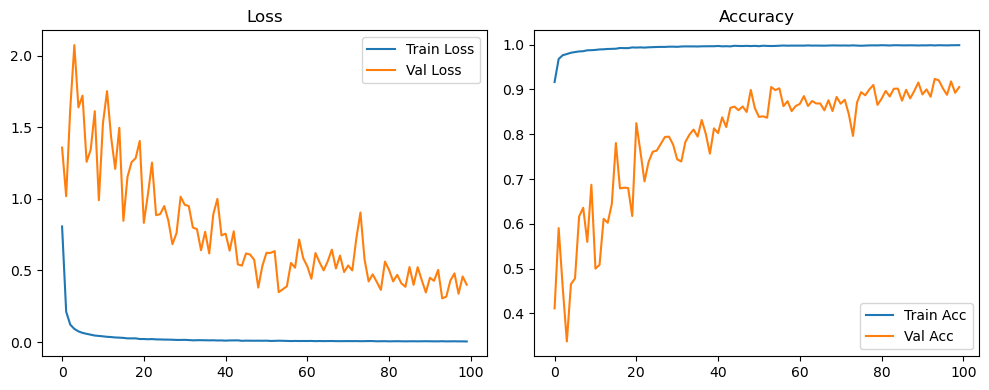

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.1669, Acc: 0.7346 | Val Loss: 3.0791, Acc: 0.1133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4901, Acc: 0.8875 | Val Loss: 3.2717, Acc: 0.1855


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3095, Acc: 0.9242 | Val Loss: 3.1541, Acc: 0.2117


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2353, Acc: 0.9375 | Val Loss: 3.1415, Acc: 0.2124


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1950, Acc: 0.9470 | Val Loss: 3.6669, Acc: 0.2121


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1697, Acc: 0.9528 | Val Loss: 3.7599, Acc: 0.2126


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1532, Acc: 0.9566 | Val Loss: 3.7460, Acc: 0.2152


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1392, Acc: 0.9599 | Val Loss: 3.5819, Acc: 0.2133


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1312, Acc: 0.9616 | Val Loss: 3.6588, Acc: 0.2337


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1186, Acc: 0.9649 | Val Loss: 3.8408, Acc: 0.2178


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1158, Acc: 0.9655 | Val Loss: 3.5772, Acc: 0.2423


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1074, Acc: 0.9682 | Val Loss: 3.4236, Acc: 0.2587


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1025, Acc: 0.9701 | Val Loss: 3.4681, Acc: 0.2749


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0996, Acc: 0.9698 | Val Loss: 3.6971, Acc: 0.2396


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0958, Acc: 0.9712 | Val Loss: 3.3235, Acc: 0.2592


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0913, Acc: 0.9731 | Val Loss: 3.2004, Acc: 0.2857


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0913, Acc: 0.9725 | Val Loss: 3.3152, Acc: 0.2867


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0850, Acc: 0.9741 | Val Loss: 2.8611, Acc: 0.3238


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0854, Acc: 0.9746 | Val Loss: 3.0176, Acc: 0.3370


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9758 | Val Loss: 2.7352, Acc: 0.3382


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0807, Acc: 0.9754 | Val Loss: 3.2967, Acc: 0.3075


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9770 | Val Loss: 3.1418, Acc: 0.2941


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9778 | Val Loss: 2.4635, Acc: 0.3518


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0750, Acc: 0.9769 | Val Loss: 2.6578, Acc: 0.3613


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0724, Acc: 0.9783 | Val Loss: 2.9602, Acc: 0.3064


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0712, Acc: 0.9777 | Val Loss: 2.6012, Acc: 0.3710


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9780 | Val Loss: 3.0232, Acc: 0.3252


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9781 | Val Loss: 3.2388, Acc: 0.3073


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9788 | Val Loss: 3.2234, Acc: 0.3174


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9794 | Val Loss: 3.2762, Acc: 0.3103


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9790 | Val Loss: 2.8998, Acc: 0.3323


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9801 | Val Loss: 2.5278, Acc: 0.3588


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0654, Acc: 0.9798 | Val Loss: 2.7489, Acc: 0.3074


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9804 | Val Loss: 2.6561, Acc: 0.3797


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0614, Acc: 0.9814 | Val Loss: 2.9690, Acc: 0.3393


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9809 | Val Loss: 2.9915, Acc: 0.3325


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0651, Acc: 0.9802 | Val Loss: 2.0762, Acc: 0.4564


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0609, Acc: 0.9815 | Val Loss: 2.2155, Acc: 0.4371


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9814 | Val Loss: 2.5267, Acc: 0.4136


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0614, Acc: 0.9810 | Val Loss: 2.3443, Acc: 0.4153


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9814 | Val Loss: 1.9752, Acc: 0.4831


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9825 | Val Loss: 2.0107, Acc: 0.4723


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9822 | Val Loss: 2.2771, Acc: 0.4673


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0608, Acc: 0.9818 | Val Loss: 2.7800, Acc: 0.3728


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 2.2736, Acc: 0.4237


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0557, Acc: 0.9833 | Val Loss: 2.5758, Acc: 0.3752


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9823 | Val Loss: 2.3450, Acc: 0.4339


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0560, Acc: 0.9825 | Val Loss: 2.4312, Acc: 0.4047


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9827 | Val Loss: 2.2891, Acc: 0.4422


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9840 | Val Loss: 2.7242, Acc: 0.3769


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9825 | Val Loss: 2.2957, Acc: 0.4375


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0543, Acc: 0.9828 | Val Loss: 2.4772, Acc: 0.4223


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9833 | Val Loss: 2.0533, Acc: 0.4880


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 1.9493, Acc: 0.5068


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9836 | Val Loss: 2.2367, Acc: 0.4534


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9834 | Val Loss: 2.0941, Acc: 0.4749


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9846 | Val Loss: 2.0961, Acc: 0.4778


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9831 | Val Loss: 2.7595, Acc: 0.3851


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9837 | Val Loss: 2.3807, Acc: 0.4243


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9846 | Val Loss: 2.2524, Acc: 0.4529


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9834 | Val Loss: 2.1541, Acc: 0.4756


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 1.9176, Acc: 0.4952


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9851 | Val Loss: 1.9581, Acc: 0.4956


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 1.5351, Acc: 0.5937


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9841 | Val Loss: 1.6738, Acc: 0.5537


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9847 | Val Loss: 1.6880, Acc: 0.5387


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 1.9310, Acc: 0.4917


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9849 | Val Loss: 2.3360, Acc: 0.4391


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9846 | Val Loss: 2.5501, Acc: 0.4083


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9855 | Val Loss: 2.0529, Acc: 0.4904


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9857 | Val Loss: 2.0008, Acc: 0.5124


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9861 | Val Loss: 2.1468, Acc: 0.4625


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 2.1600, Acc: 0.4813


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 2.1363, Acc: 0.4759


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9847 | Val Loss: 1.9550, Acc: 0.5136


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9847 | Val Loss: 2.0791, Acc: 0.4833


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9861 | Val Loss: 1.7524, Acc: 0.5288


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9852 | Val Loss: 1.8462, Acc: 0.5226


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9859 | Val Loss: 1.9034, Acc: 0.5332


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9856 | Val Loss: 2.0103, Acc: 0.5028


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9854 | Val Loss: 1.7978, Acc: 0.5385


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9858 | Val Loss: 1.7680, Acc: 0.5565


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 2.1080, Acc: 0.4783


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 1.8077, Acc: 0.5470


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9859 | Val Loss: 1.8379, Acc: 0.5357


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9857 | Val Loss: 1.7286, Acc: 0.5536


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 1.5266, Acc: 0.5985


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9859 | Val Loss: 1.7883, Acc: 0.5607


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 1.9179, Acc: 0.5407


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 1.7888, Acc: 0.5427


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9862 | Val Loss: 1.6927, Acc: 0.5750


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9860 | Val Loss: 1.5813, Acc: 0.5867


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9863 | Val Loss: 2.0075, Acc: 0.5106


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 1.6279, Acc: 0.5813


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9868 | Val Loss: 1.5187, Acc: 0.6020


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9860 | Val Loss: 1.7415, Acc: 0.5577


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9860 | Val Loss: 1.8376, Acc: 0.5451


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 1.7099, Acc: 0.5720


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9867 | Val Loss: 1.3830, Acc: 0.6348


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 1.6783, Acc: 0.5763


Final Test Loss: 1.6452 Accuracy: 0.5771


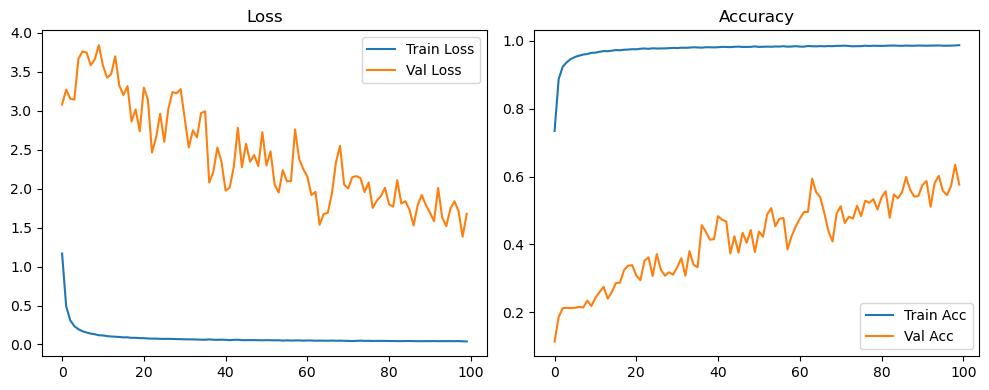

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2893, Acc: 0.9451 | Val Loss: 0.3022, Acc: 0.8959


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9839 | Val Loss: 0.1289, Acc: 0.9625


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9881 | Val Loss: 0.1370, Acc: 0.9598


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9917 | Val Loss: 0.1137, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.0856, Acc: 0.9739


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9954 | Val Loss: 0.0598, Acc: 0.9822


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9966 | Val Loss: 0.1488, Acc: 0.9524


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1226, Acc: 0.9623


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.0651, Acc: 0.9814


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.0617, Acc: 0.9822


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.0763, Acc: 0.9754


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1412, Acc: 0.9570


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.2133, Acc: 0.9435


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0658, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0577, Acc: 0.9832


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9999 | Val Loss: 0.0426, Acc: 0.9887


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9882


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9893


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9898


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9891


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9892


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9899


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9902


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9899


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9902


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9895


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9901


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9899


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9900


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9898


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9899


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9897


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9895


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9902


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9898


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0554, Acc: 0.9859


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9854 | Val Loss: 0.1672, Acc: 0.9488


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0715, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0603, Acc: 0.9837


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0488, Acc: 0.9881


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0416, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0458, Acc: 0.9891


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9895


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9899


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9894


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9896


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9891


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9893


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9903


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9902


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9894


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9900


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9897


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9894


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9898


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9899


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9907


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9902


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9908


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9900


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9899


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9902


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0552, Acc: 0.9893


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.0989, Acc: 0.9738


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0591, Acc: 0.9863


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0585, Acc: 0.9867


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0534, Acc: 0.9877


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9897


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9899


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9888


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9889


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9897


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9895


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9896


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9892


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9903


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9895


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9897


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9896


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9898


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9891


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9898


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9896


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9895


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9894


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9899


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0547, Acc: 0.9902


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9898


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9891


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9895


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9894


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9887


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9898


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9897


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9896


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9900


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9893


Final Test Loss: 0.0577 Accuracy: 0.9895


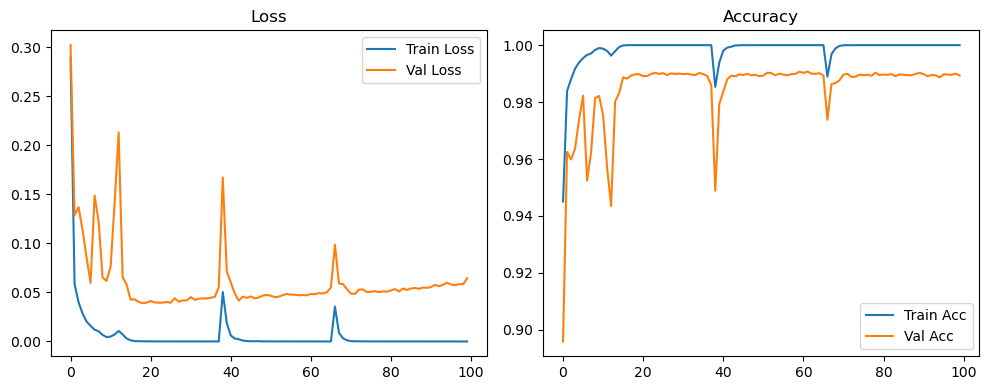

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3623, Acc: 0.9205 | Val Loss: 2.9178, Acc: 0.2890


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9737 | Val Loss: 0.8832, Acc: 0.7244


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9788 | Val Loss: 0.6952, Acc: 0.7696


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9834 | Val Loss: 1.0661, Acc: 0.7056


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9850 | Val Loss: 1.4251, Acc: 0.5506


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9863 | Val Loss: 0.6707, Acc: 0.8080


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.7385, Acc: 0.7707


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.6995, Acc: 0.7894


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.5712, Acc: 0.8333


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9922 | Val Loss: 0.3453, Acc: 0.8945


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.7204, Acc: 0.8225


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.5751, Acc: 0.8343


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.5005, Acc: 0.8533


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.2343, Acc: 0.9282


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.2496, Acc: 0.9261


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.2254, Acc: 0.9303


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9942 | Val Loss: 0.3598, Acc: 0.8999


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1307, Acc: 0.9633


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.3114, Acc: 0.9142


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.4398, Acc: 0.8826


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.2347, Acc: 0.9334


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.3145, Acc: 0.9158


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.2677, Acc: 0.9259


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.2308, Acc: 0.9365


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.2724, Acc: 0.9281


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.3724, Acc: 0.9024


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1897, Acc: 0.9477


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.2358, Acc: 0.9355


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.2716, Acc: 0.9338


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.3077, Acc: 0.9227


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1809, Acc: 0.9542


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9960 | Val Loss: 0.1778, Acc: 0.9553


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.2566, Acc: 0.9315


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.2063, Acc: 0.9507


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.3109, Acc: 0.9220


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.1514, Acc: 0.9603


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1239, Acc: 0.9677


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9965 | Val Loss: 0.1671, Acc: 0.9564


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1499, Acc: 0.9625


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1388, Acc: 0.9663


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1607, Acc: 0.9603


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1793, Acc: 0.9556


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1325, Acc: 0.9681


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1007, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.2160, Acc: 0.9458


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1479, Acc: 0.9642


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9974 | Val Loss: 0.2489, Acc: 0.9428


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1576, Acc: 0.9631


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1240, Acc: 0.9713


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1472, Acc: 0.9667


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.2197, Acc: 0.9509


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.1753, Acc: 0.9603


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.2021, Acc: 0.9554


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.2516, Acc: 0.9461


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1592, Acc: 0.9659


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1728, Acc: 0.9634


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.2019, Acc: 0.9577


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1114, Acc: 0.9734


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.1865, Acc: 0.9594


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1578, Acc: 0.9653


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1924, Acc: 0.9577


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1537, Acc: 0.9673


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1362, Acc: 0.9708


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1337, Acc: 0.9718


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.2841, Acc: 0.9402


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9978 | Val Loss: 0.1961, Acc: 0.9603


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1661, Acc: 0.9657


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1316, Acc: 0.9718


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1879, Acc: 0.9609


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9692


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1430, Acc: 0.9688


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.2072, Acc: 0.9557


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.2345, Acc: 0.9473


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1583, Acc: 0.9683


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.2886, Acc: 0.9406


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.2216, Acc: 0.9547


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1910, Acc: 0.9615


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0998, Acc: 0.9788


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1294, Acc: 0.9738


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1416, Acc: 0.9727


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1391, Acc: 0.9709


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1160, Acc: 0.9779


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1389, Acc: 0.9736


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1019, Acc: 0.9813


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1666, Acc: 0.9683


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1128, Acc: 0.9791


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1797, Acc: 0.9642


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1408, Acc: 0.9731


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1254, Acc: 0.9754


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1252, Acc: 0.9762


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1193, Acc: 0.9782


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1844, Acc: 0.9650


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1384, Acc: 0.9742


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.2310, Acc: 0.9566


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1721, Acc: 0.9666


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1221, Acc: 0.9762


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1168, Acc: 0.9768


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1774, Acc: 0.9650


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1110, Acc: 0.9797


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1346, Acc: 0.9749


Final Test Loss: 0.1448 Accuracy: 0.9713


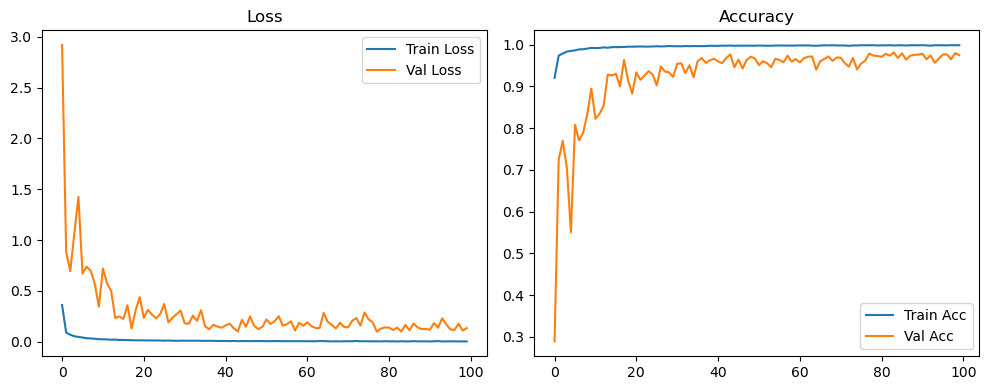

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6135, Acc: 0.8226 | Val Loss: 3.2432, Acc: 0.1789


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1936, Acc: 0.9433 | Val Loss: 2.6332, Acc: 0.2495


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9584 | Val Loss: 1.9377, Acc: 0.3648


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9643 | Val Loss: 2.5933, Acc: 0.3108


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9689 | Val Loss: 2.0468, Acc: 0.4040


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1002, Acc: 0.9702 | Val Loss: 1.8861, Acc: 0.4547


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9723 | Val Loss: 1.9387, Acc: 0.4303


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9731 | Val Loss: 1.5925, Acc: 0.5383


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9753 | Val Loss: 1.7874, Acc: 0.4911


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9764 | Val Loss: 2.0109, Acc: 0.4595


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9761 | Val Loss: 1.8246, Acc: 0.4902


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0758, Acc: 0.9772 | Val Loss: 1.7242, Acc: 0.5255


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9788 | Val Loss: 1.7505, Acc: 0.5326


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9780 | Val Loss: 1.3388, Acc: 0.5903


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9792 | Val Loss: 1.2878, Acc: 0.6344


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9797 | Val Loss: 1.5397, Acc: 0.5728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9800 | Val Loss: 1.1628, Acc: 0.6627


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9801 | Val Loss: 1.3622, Acc: 0.6401


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9803 | Val Loss: 1.5808, Acc: 0.6068


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9808 | Val Loss: 1.2618, Acc: 0.6488


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9821 | Val Loss: 1.2968, Acc: 0.6348


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9821 | Val Loss: 1.5419, Acc: 0.6019


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9820 | Val Loss: 0.9056, Acc: 0.7200


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9820 | Val Loss: 1.0719, Acc: 0.7037


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9824 | Val Loss: 1.0040, Acc: 0.7131


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9827 | Val Loss: 0.9366, Acc: 0.7445


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9832 | Val Loss: 1.6024, Acc: 0.6259


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9835 | Val Loss: 1.3587, Acc: 0.6457


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9841 | Val Loss: 1.2500, Acc: 0.6809


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9826 | Val Loss: 1.1535, Acc: 0.6763


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9838 | Val Loss: 1.4606, Acc: 0.6567


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9836 | Val Loss: 1.3632, Acc: 0.6562


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9835 | Val Loss: 1.4804, Acc: 0.6390


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9851 | Val Loss: 0.6315, Acc: 0.8027


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9843 | Val Loss: 0.7590, Acc: 0.7784


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9842 | Val Loss: 1.5377, Acc: 0.6046


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.7587, Acc: 0.7693


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9846 | Val Loss: 1.1175, Acc: 0.7043


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9845 | Val Loss: 0.8871, Acc: 0.7568


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9850 | Val Loss: 1.1616, Acc: 0.6901


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9856 | Val Loss: 1.3488, Acc: 0.6550


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9858 | Val Loss: 1.4737, Acc: 0.6580


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 1.2099, Acc: 0.6783


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9851 | Val Loss: 1.1611, Acc: 0.6841


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9860 | Val Loss: 1.1150, Acc: 0.6995


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 1.1929, Acc: 0.7003


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9858 | Val Loss: 0.9659, Acc: 0.7375


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9861 | Val Loss: 0.6703, Acc: 0.7982


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9867 | Val Loss: 1.2622, Acc: 0.6690


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.9707, Acc: 0.7272


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9863 | Val Loss: 0.9697, Acc: 0.7368


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 1.1117, Acc: 0.7121


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 1.1088, Acc: 0.7162


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9862 | Val Loss: 0.9078, Acc: 0.7368


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9868 | Val Loss: 1.1030, Acc: 0.7249


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9861 | Val Loss: 1.2242, Acc: 0.6872


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9877 | Val Loss: 1.0804, Acc: 0.7048


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 1.1630, Acc: 0.6923


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9861 | Val Loss: 0.9168, Acc: 0.7471


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 1.0808, Acc: 0.7129


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9876 | Val Loss: 0.9488, Acc: 0.7438


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.6706, Acc: 0.8043


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9873 | Val Loss: 0.6926, Acc: 0.7916


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.8788, Acc: 0.7563


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9872 | Val Loss: 0.9247, Acc: 0.7478


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9870 | Val Loss: 0.9594, Acc: 0.7464


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 0.8821, Acc: 0.7502


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9866 | Val Loss: 0.9558, Acc: 0.7280


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9873 | Val Loss: 1.1975, Acc: 0.6873


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 1.1868, Acc: 0.6967


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.7312, Acc: 0.7884


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9871 | Val Loss: 0.8324, Acc: 0.7662


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9877 | Val Loss: 0.9631, Acc: 0.7455


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 1.0458, Acc: 0.7298


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9878 | Val Loss: 0.9269, Acc: 0.7491


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9882 | Val Loss: 0.7369, Acc: 0.7968


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9885 | Val Loss: 1.0714, Acc: 0.7063


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9882 | Val Loss: 0.7808, Acc: 0.7731


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.6418, Acc: 0.8172


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9882 | Val Loss: 0.6229, Acc: 0.8162


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.9366, Acc: 0.7352


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9884 | Val Loss: 0.6568, Acc: 0.8127


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9881 | Val Loss: 0.8334, Acc: 0.7818


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.6255, Acc: 0.8222


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9883 | Val Loss: 0.6595, Acc: 0.8006


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9893 | Val Loss: 0.7596, Acc: 0.7703


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9888 | Val Loss: 0.7125, Acc: 0.7952


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9881 | Val Loss: 0.9467, Acc: 0.7258


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.6351, Acc: 0.8079


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.6982, Acc: 0.8012


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9888 | Val Loss: 0.6139, Acc: 0.8106


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.6116, Acc: 0.8213


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.6649, Acc: 0.8093


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.7820, Acc: 0.7761


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.9649, Acc: 0.7368


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 0.9370, Acc: 0.7448


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9896 | Val Loss: 0.5756, Acc: 0.8270


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9889 | Val Loss: 0.6687, Acc: 0.8053


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9896 | Val Loss: 0.9204, Acc: 0.7380


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9891 | Val Loss: 0.7663, Acc: 0.7790


Final Test Loss: 0.7381 Accuracy: 0.7855


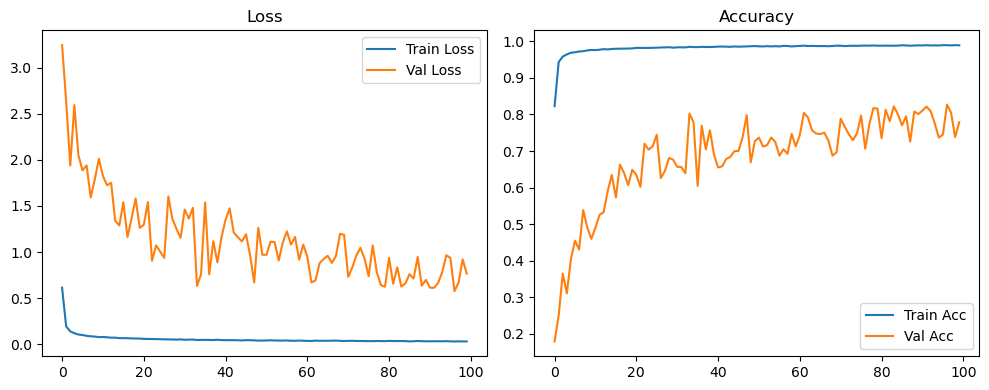

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2895, Acc: 0.9448 | Val Loss: 0.2699, Acc: 0.9163


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9832 | Val Loss: 0.3417, Acc: 0.8885


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9884 | Val Loss: 0.1917, Acc: 0.9410


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9922 | Val Loss: 0.1778, Acc: 0.9445


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9942 | Val Loss: 0.1896, Acc: 0.9393


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9953 | Val Loss: 0.0710, Acc: 0.9786


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.1804, Acc: 0.9462


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.2336, Acc: 0.9358


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0846, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.0707, Acc: 0.9792


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.3626, Acc: 0.9077


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1017, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1772, Acc: 0.9507


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0766, Acc: 0.9772


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0830, Acc: 0.9768


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.0556, Acc: 0.9841


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0449, Acc: 0.9874


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9893


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9898


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9900


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9902


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9906


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9902


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9900


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9903


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9902


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9904


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9911


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9905


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9899


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9901


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9902


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9902


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9905


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9899


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9907


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9907


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9898


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9905


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9898


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9902


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9898


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9902


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9897


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9899


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0729, Acc: 0.9842


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9825 | Val Loss: 0.0529, Acc: 0.9843


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1445, Acc: 0.9592


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0539, Acc: 0.9854


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.0409, Acc: 0.9888


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9885


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9894


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9896


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9898


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9897


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9899


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9894


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9892


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9898


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9898


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9898


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9896


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9901


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9901


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9894


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9897


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9895


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9896


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9895


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9899


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9897


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9896


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9890


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0834, Acc: 0.9828


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0550, Acc: 0.9872


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0581, Acc: 0.9868


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0517, Acc: 0.9886


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9893


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9887


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9894


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9892


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9894


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9892


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9891


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9892


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9890


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9893


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9890


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9892


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9895


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9892


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9888


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9892


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9889


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9888


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9893


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9895


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9891


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9893


Final Test Loss: 0.0530 Accuracy: 0.9891


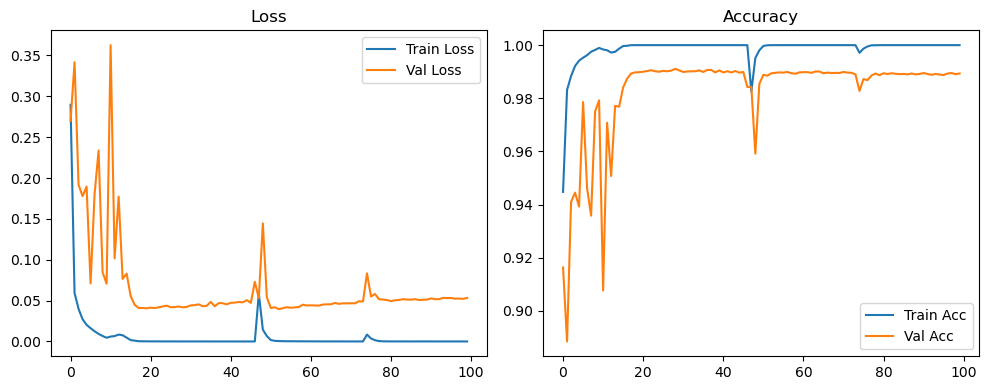

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3615, Acc: 0.9210 | Val Loss: 2.7163, Acc: 0.2894


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0906, Acc: 0.9734 | Val Loss: 1.1384, Acc: 0.6257


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9782 | Val Loss: 0.7564, Acc: 0.7612


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9833 | Val Loss: 0.9471, Acc: 0.7112


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9859 | Val Loss: 1.4871, Acc: 0.5539


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.5850, Acc: 0.8247


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.7550, Acc: 0.7657


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.8008, Acc: 0.7851


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9912 | Val Loss: 0.8626, Acc: 0.7378


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.9535, Acc: 0.7305


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9913 | Val Loss: 0.7235, Acc: 0.7879


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.5781, Acc: 0.8213


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.4210, Acc: 0.8658


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.4592, Acc: 0.8561


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.3031, Acc: 0.9115


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9937 | Val Loss: 0.3110, Acc: 0.9081


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.3846, Acc: 0.8852


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.2708, Acc: 0.9188


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.4110, Acc: 0.8925


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.3610, Acc: 0.9000


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.2278, Acc: 0.9346


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.2954, Acc: 0.9189


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9955 | Val Loss: 0.1954, Acc: 0.9463


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.3463, Acc: 0.9106


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.3396, Acc: 0.9118


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.3003, Acc: 0.9205


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.2616, Acc: 0.9278


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.2496, Acc: 0.9333


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.1888, Acc: 0.9513


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9954 | Val Loss: 0.2388, Acc: 0.9360


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1474, Acc: 0.9620


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.2649, Acc: 0.9324


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1562, Acc: 0.9607


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1687, Acc: 0.9583


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.2323, Acc: 0.9425


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.2060, Acc: 0.9487


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1323, Acc: 0.9685


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.2055, Acc: 0.9482


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.1941, Acc: 0.9551


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1280, Acc: 0.9698


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.2024, Acc: 0.9496


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.2278, Acc: 0.9437


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.2037, Acc: 0.9540


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1560, Acc: 0.9624


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.1186, Acc: 0.9710


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1366, Acc: 0.9643


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1742, Acc: 0.9593


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1421, Acc: 0.9667


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1331, Acc: 0.9688


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.2047, Acc: 0.9535


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1454, Acc: 0.9664


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1272, Acc: 0.9716


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1321, Acc: 0.9702


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1286, Acc: 0.9712


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1440, Acc: 0.9682


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1519, Acc: 0.9657


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1469, Acc: 0.9667


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1324, Acc: 0.9699


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1502, Acc: 0.9675


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1648, Acc: 0.9651


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1637, Acc: 0.9648


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1402, Acc: 0.9697


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1457, Acc: 0.9699


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1640, Acc: 0.9651


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1429, Acc: 0.9698


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1438, Acc: 0.9702


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1421, Acc: 0.9692


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1613, Acc: 0.9659


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1443, Acc: 0.9702


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1781, Acc: 0.9623


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1365, Acc: 0.9707


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1593, Acc: 0.9663


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1508, Acc: 0.9688


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1650, Acc: 0.9668


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1481, Acc: 0.9702


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1335, Acc: 0.9723


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9989 | Val Loss: 0.1385, Acc: 0.9712


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1731, Acc: 0.9661


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1155, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1502, Acc: 0.9702


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1559, Acc: 0.9691


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1605, Acc: 0.9688


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1611, Acc: 0.9689


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1256, Acc: 0.9754


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1219, Acc: 0.9765


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1473, Acc: 0.9700


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1348, Acc: 0.9725


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1201, Acc: 0.9767


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1046, Acc: 0.9793


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1451, Acc: 0.9729


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1351, Acc: 0.9758


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1364, Acc: 0.9745


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1225, Acc: 0.9769


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1335, Acc: 0.9742


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1308, Acc: 0.9755


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1568, Acc: 0.9694


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1325, Acc: 0.9732


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1458, Acc: 0.9715


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1155, Acc: 0.9773


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1141, Acc: 0.9783


Final Test Loss: 0.1213 Accuracy: 0.9751


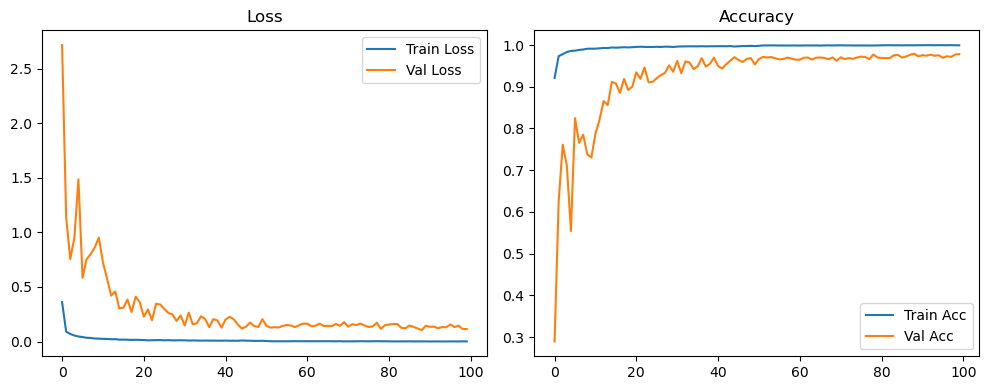

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6136, Acc: 0.8219 | Val Loss: 2.9315, Acc: 0.2177


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1940, Acc: 0.9431 | Val Loss: 2.4138, Acc: 0.2781


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9580 | Val Loss: 2.2756, Acc: 0.3493


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9637 | Val Loss: 2.6190, Acc: 0.3182


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1056, Acc: 0.9683 | Val Loss: 2.3990, Acc: 0.3476


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9698 | Val Loss: 2.5412, Acc: 0.3716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0914, Acc: 0.9727 | Val Loss: 2.2318, Acc: 0.4057


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9736 | Val Loss: 1.9592, Acc: 0.4682


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9750 | Val Loss: 2.0760, Acc: 0.4422


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9774 | Val Loss: 2.2824, Acc: 0.4153


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9766 | Val Loss: 1.9267, Acc: 0.4738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9759 | Val Loss: 2.1018, Acc: 0.4498


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9779 | Val Loss: 1.7258, Acc: 0.5278


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9783 | Val Loss: 1.5312, Acc: 0.5686


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9794 | Val Loss: 1.9927, Acc: 0.4933


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9791 | Val Loss: 1.4468, Acc: 0.6208


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0650, Acc: 0.9798 | Val Loss: 1.2247, Acc: 0.6436


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9808 | Val Loss: 1.3378, Acc: 0.6292


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9803 | Val Loss: 1.6790, Acc: 0.5923


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9808 | Val Loss: 1.2179, Acc: 0.6514


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9817 | Val Loss: 1.3714, Acc: 0.6266


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9821 | Val Loss: 1.7102, Acc: 0.5622


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9821 | Val Loss: 1.0260, Acc: 0.6950


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9832 | Val Loss: 1.4548, Acc: 0.6435


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9824 | Val Loss: 1.1612, Acc: 0.6783


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9830 | Val Loss: 1.1900, Acc: 0.7003


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9824 | Val Loss: 1.5446, Acc: 0.6213


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9825 | Val Loss: 0.9471, Acc: 0.7304


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9840 | Val Loss: 1.3316, Acc: 0.6647


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9828 | Val Loss: 1.4283, Acc: 0.6482


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9840 | Val Loss: 1.3264, Acc: 0.6668


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9849 | Val Loss: 1.4228, Acc: 0.6520


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9832 | Val Loss: 1.4010, Acc: 0.6429


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9841 | Val Loss: 0.9035, Acc: 0.7459


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9846 | Val Loss: 1.0472, Acc: 0.7323


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9848 | Val Loss: 1.3358, Acc: 0.6434


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9849 | Val Loss: 0.9598, Acc: 0.7212


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9844 | Val Loss: 0.8082, Acc: 0.7657


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.9673, Acc: 0.7390


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9842 | Val Loss: 1.1200, Acc: 0.6973


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 1.1706, Acc: 0.6908


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9852 | Val Loss: 0.8680, Acc: 0.7551


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9851 | Val Loss: 0.8260, Acc: 0.7570


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.8034, Acc: 0.7690


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.7566, Acc: 0.7873


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9860 | Val Loss: 0.6069, Acc: 0.8101


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9855 | Val Loss: 1.2481, Acc: 0.6816


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9858 | Val Loss: 0.8936, Acc: 0.7658


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9868 | Val Loss: 0.9699, Acc: 0.7371


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.7570, Acc: 0.7815


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9879 | Val Loss: 0.6924, Acc: 0.8013


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.8723, Acc: 0.7595


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.7248, Acc: 0.7947


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9888 | Val Loss: 0.7782, Acc: 0.7767


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.9591, Acc: 0.7448


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.8647, Acc: 0.7617


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9887 | Val Loss: 0.9689, Acc: 0.7305


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9890 | Val Loss: 0.9025, Acc: 0.7521


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 0.8701, Acc: 0.7617


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.9153, Acc: 0.7576


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9897 | Val Loss: 0.9332, Acc: 0.7441


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9896 | Val Loss: 0.6853, Acc: 0.7991


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.7697, Acc: 0.7772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.6684, Acc: 0.8025


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.7942, Acc: 0.7678


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.8754, Acc: 0.7519


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9888 | Val Loss: 0.7815, Acc: 0.7721


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.9311, Acc: 0.7466


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.6575, Acc: 0.7963


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.8633, Acc: 0.7637


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.9552, Acc: 0.7400


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.7999, Acc: 0.7772


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9895 | Val Loss: 0.7212, Acc: 0.7971


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9888 | Val Loss: 0.8713, Acc: 0.7491


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9890 | Val Loss: 0.8123, Acc: 0.7651


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.7401, Acc: 0.7918


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9898 | Val Loss: 0.9282, Acc: 0.7481


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 1.0913, Acc: 0.7093


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.7194, Acc: 0.7848


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9902 | Val Loss: 0.7287, Acc: 0.7979


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.5980, Acc: 0.8217


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9911 | Val Loss: 0.6395, Acc: 0.8136


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.5722, Acc: 0.8307


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.5845, Acc: 0.8287


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9911 | Val Loss: 0.5740, Acc: 0.8281


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9914 | Val Loss: 0.6463, Acc: 0.8080


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9913 | Val Loss: 0.5852, Acc: 0.8245


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.7597, Acc: 0.7826


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9911 | Val Loss: 0.6883, Acc: 0.7983


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.7176, Acc: 0.7863


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.7631, Acc: 0.7770


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.6523, Acc: 0.8057


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9909 | Val Loss: 0.6533, Acc: 0.8106


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.8177, Acc: 0.7676


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.7907, Acc: 0.7777


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.7131, Acc: 0.7917


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.6269, Acc: 0.8127


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9916 | Val Loss: 0.6599, Acc: 0.8038


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.7480, Acc: 0.7818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.5921, Acc: 0.8215


Final Test Loss: 0.5820 Accuracy: 0.8267


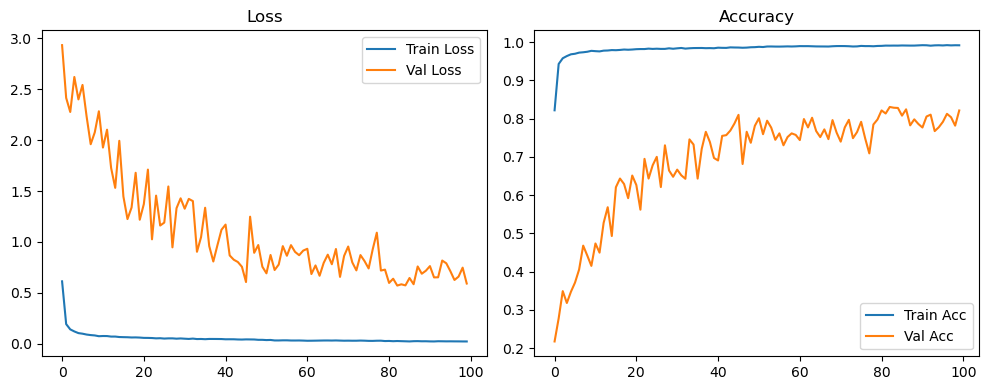

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2890, Acc: 0.9448 | Val Loss: 0.1832, Acc: 0.9470


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9832 | Val Loss: 0.2206, Acc: 0.9287


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9883 | Val Loss: 0.1892, Acc: 0.9430


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9910 | Val Loss: 0.2782, Acc: 0.9081


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9939 | Val Loss: 0.3286, Acc: 0.8912


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9956 | Val Loss: 0.0798, Acc: 0.9742


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.0832, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9974 | Val Loss: 0.3539, Acc: 0.8964


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.0713, Acc: 0.9788


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.0581, Acc: 0.9827


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1110, Acc: 0.9680


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1017, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1248, Acc: 0.9637


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0873, Acc: 0.9745


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0796, Acc: 0.9779


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0470, Acc: 0.9872


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0829, Acc: 0.9782


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9999 | Val Loss: 0.0532, Acc: 0.9861


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9879


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9893


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9901


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9901


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9898


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9902


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9890


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9880


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9896


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9906


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9904


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9899


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9899


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9905


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9903


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9904


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9890


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9893


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9902


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9899


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9904


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9902


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9903


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9896


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9908


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9941 | Val Loss: 0.2123, Acc: 0.9383


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.0850, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0786, Acc: 0.9794


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.0456, Acc: 0.9883


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9999 | Val Loss: 0.0434, Acc: 0.9899


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9892


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9899


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9896


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9897


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9894


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9904


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9901


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9900


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9904


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9890


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9891


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0709, Acc: 0.9830


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0541, Acc: 0.9868


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0584, Acc: 0.9872


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9900


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9903


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9901


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0864, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0693, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0542, Acc: 0.9890


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0506, Acc: 0.9895


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9899


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9897


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9899


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9894


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9900


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9902


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9900


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9896


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9902


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9904


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9897


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9898


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9899


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9899


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9902


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9902


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9896


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9896


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9901


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9898


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9902


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9901


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9903


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9903


Final Test Loss: 0.0478 Accuracy: 0.9897


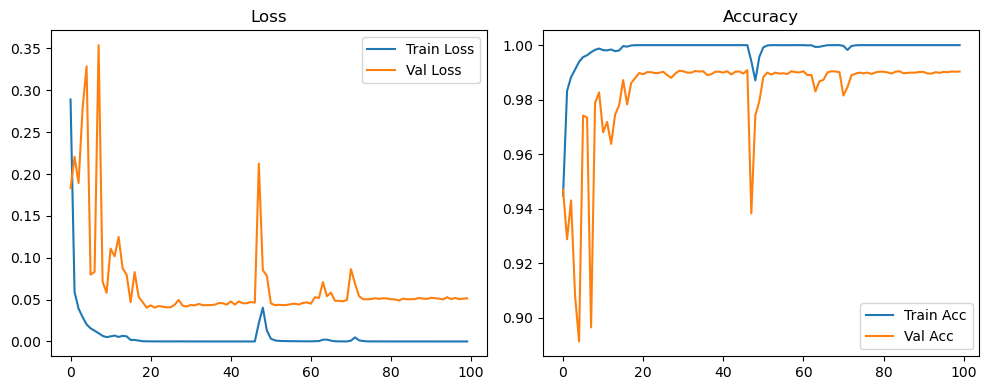

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3617, Acc: 0.9211 | Val Loss: 2.2697, Acc: 0.3568


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0906, Acc: 0.9737 | Val Loss: 1.2779, Acc: 0.6062


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9784 | Val Loss: 1.0367, Acc: 0.6967


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9832 | Val Loss: 0.9974, Acc: 0.6831


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9853 | Val Loss: 0.8574, Acc: 0.7154


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 0.6979, Acc: 0.8092


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.7138, Acc: 0.7783


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.5832, Acc: 0.8213


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.7045, Acc: 0.7882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.5607, Acc: 0.8428


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.6314, Acc: 0.8398


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.5521, Acc: 0.8407


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.6692, Acc: 0.8202


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.2749, Acc: 0.9185


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.3367, Acc: 0.8988


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.2240, Acc: 0.9358


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.2578, Acc: 0.9288


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1975, Acc: 0.9443


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.2850, Acc: 0.9200


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.3820, Acc: 0.8975


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1855, Acc: 0.9477


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.2653, Acc: 0.9307


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1754, Acc: 0.9533


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.4508, Acc: 0.8888


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1924, Acc: 0.9496


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.4683, Acc: 0.8878


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1991, Acc: 0.9468


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1841, Acc: 0.9500


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.2212, Acc: 0.9440


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.3226, Acc: 0.9217


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.3673, Acc: 0.9167


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.2903, Acc: 0.9320


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.2779, Acc: 0.9299


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.2057, Acc: 0.9493


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.2504, Acc: 0.9405


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.2215, Acc: 0.9456


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1307, Acc: 0.9664


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.2344, Acc: 0.9450


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.2097, Acc: 0.9525


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.2460, Acc: 0.9399


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.2230, Acc: 0.9434


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.2873, Acc: 0.9327


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.2162, Acc: 0.9510


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0976, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.2070, Acc: 0.9517


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9974 | Val Loss: 0.2056, Acc: 0.9493


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9973 | Val Loss: 0.1245, Acc: 0.9722


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.2215, Acc: 0.9494


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.2036, Acc: 0.9523


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1326, Acc: 0.9687


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.2027, Acc: 0.9547


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1790, Acc: 0.9602


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1739, Acc: 0.9620


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.2021, Acc: 0.9548


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1626, Acc: 0.9653


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1680, Acc: 0.9627


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.2053, Acc: 0.9543


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2120, Acc: 0.9533


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1899, Acc: 0.9587


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.2199, Acc: 0.9537


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1454, Acc: 0.9708


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2245, Acc: 0.9560


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1588, Acc: 0.9668


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.2483, Acc: 0.9487


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1878, Acc: 0.9615


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2772, Acc: 0.9433


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1755, Acc: 0.9633


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.2890, Acc: 0.9430


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.2253, Acc: 0.9556


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2237, Acc: 0.9557


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1954, Acc: 0.9602


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.2178, Acc: 0.9563


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.2010, Acc: 0.9622


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1951, Acc: 0.9626


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2717, Acc: 0.9475


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.2376, Acc: 0.9520


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1878, Acc: 0.9627


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1678, Acc: 0.9668


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1638, Acc: 0.9688


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2017, Acc: 0.9599


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1594, Acc: 0.9688


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1598, Acc: 0.9688


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1497, Acc: 0.9712


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1553, Acc: 0.9702


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1396, Acc: 0.9732


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1597, Acc: 0.9688


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1467, Acc: 0.9715


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1549, Acc: 0.9692


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1480, Acc: 0.9715


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1494, Acc: 0.9716


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1491, Acc: 0.9712


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1732, Acc: 0.9674


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1560, Acc: 0.9700


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1593, Acc: 0.9685


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1642, Acc: 0.9688


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1762, Acc: 0.9659


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1551, Acc: 0.9704


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1601, Acc: 0.9685


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1345, Acc: 0.9741


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1329, Acc: 0.9748


Final Test Loss: 0.1465 Accuracy: 0.9722


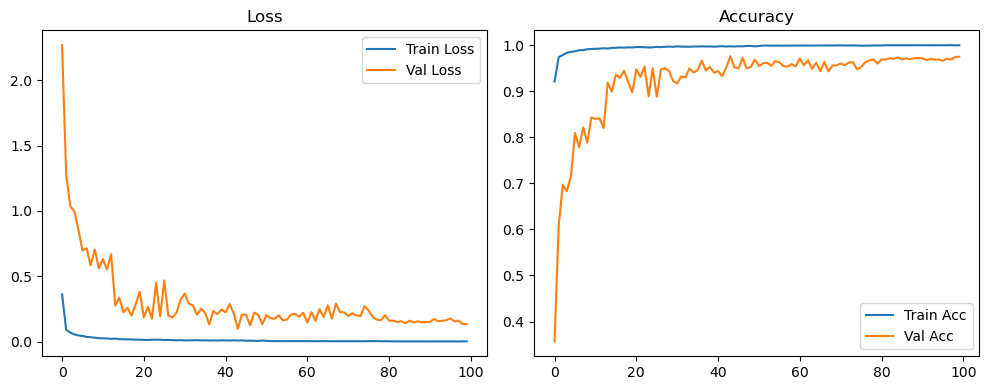

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6140, Acc: 0.8222 | Val Loss: 3.1632, Acc: 0.1890


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1950, Acc: 0.9430 | Val Loss: 2.4307, Acc: 0.2582


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1415, Acc: 0.9571 | Val Loss: 1.9444, Acc: 0.4110


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9644 | Val Loss: 1.9590, Acc: 0.4094


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1059, Acc: 0.9679 | Val Loss: 2.2023, Acc: 0.3811


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9702 | Val Loss: 2.0649, Acc: 0.4229


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9719 | Val Loss: 2.1411, Acc: 0.4045


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9737 | Val Loss: 1.8677, Acc: 0.4772


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9751 | Val Loss: 1.7183, Acc: 0.4879


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9762 | Val Loss: 2.3259, Acc: 0.3796


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9755 | Val Loss: 2.0176, Acc: 0.4537


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9767 | Val Loss: 2.1957, Acc: 0.4445


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9774 | Val Loss: 1.9520, Acc: 0.4884


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9772 | Val Loss: 1.1621, Acc: 0.6464


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9789 | Val Loss: 1.4980, Acc: 0.5873


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9792 | Val Loss: 2.0653, Acc: 0.4862


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9803 | Val Loss: 1.5122, Acc: 0.5879


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9808 | Val Loss: 1.4942, Acc: 0.5958


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 1.3446, Acc: 0.6653


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9815 | Val Loss: 1.5878, Acc: 0.5621


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9824 | Val Loss: 1.7606, Acc: 0.5337


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9814 | Val Loss: 1.6766, Acc: 0.5592


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9819 | Val Loss: 1.1908, Acc: 0.6544


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 1.7743, Acc: 0.5562


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9828 | Val Loss: 1.1527, Acc: 0.6835


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9826 | Val Loss: 1.4899, Acc: 0.6312


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9837 | Val Loss: 2.1442, Acc: 0.5078


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 1.3329, Acc: 0.6362


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9843 | Val Loss: 1.5914, Acc: 0.5998


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9826 | Val Loss: 1.3633, Acc: 0.6388


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9844 | Val Loss: 1.7324, Acc: 0.5886


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9840 | Val Loss: 1.5138, Acc: 0.6187


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9841 | Val Loss: 1.6214, Acc: 0.6027


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9845 | Val Loss: 1.1600, Acc: 0.6887


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9846 | Val Loss: 1.8314, Acc: 0.5654


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9856 | Val Loss: 1.7385, Acc: 0.5603


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9847 | Val Loss: 1.3509, Acc: 0.6291


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9843 | Val Loss: 1.6213, Acc: 0.5872


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9846 | Val Loss: 1.3391, Acc: 0.6542


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9848 | Val Loss: 1.0741, Acc: 0.6961


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9854 | Val Loss: 1.3306, Acc: 0.6632


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9852 | Val Loss: 1.3188, Acc: 0.6519


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9852 | Val Loss: 1.1406, Acc: 0.6949


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 1.7094, Acc: 0.5723


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9857 | Val Loss: 1.2031, Acc: 0.6757


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9859 | Val Loss: 1.4073, Acc: 0.6450


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9869 | Val Loss: 1.6431, Acc: 0.5912


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9864 | Val Loss: 1.2075, Acc: 0.7008


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9864 | Val Loss: 1.4261, Acc: 0.6379


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9871 | Val Loss: 0.9369, Acc: 0.7334


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 1.2047, Acc: 0.6825


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9879 | Val Loss: 1.1543, Acc: 0.6944


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9884 | Val Loss: 1.4131, Acc: 0.6426


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 1.2468, Acc: 0.6660


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9889 | Val Loss: 1.2590, Acc: 0.6807


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9883 | Val Loss: 1.2481, Acc: 0.6683


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 1.4396, Acc: 0.6177


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 1.1851, Acc: 0.6866


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9884 | Val Loss: 0.8947, Acc: 0.7472


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.9024, Acc: 0.7482


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 1.1731, Acc: 0.6944


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 1.0058, Acc: 0.7177


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9888 | Val Loss: 0.9235, Acc: 0.7375


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 1.0056, Acc: 0.7212


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.9303, Acc: 0.7303


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 1.1226, Acc: 0.7036


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9890 | Val Loss: 1.1857, Acc: 0.6782


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 1.0739, Acc: 0.7027


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.8562, Acc: 0.7506


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9902 | Val Loss: 1.1665, Acc: 0.6990


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.9021, Acc: 0.7432


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.9699, Acc: 0.7292


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.9213, Acc: 0.7433


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9892 | Val Loss: 1.0826, Acc: 0.7016


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 1.1096, Acc: 0.7058


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 1.1061, Acc: 0.7006


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 1.3600, Acc: 0.6569


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 1.1398, Acc: 0.6973


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9893 | Val Loss: 0.9061, Acc: 0.7440


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9899 | Val Loss: 0.9344, Acc: 0.7405


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.9462, Acc: 0.7361


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.9402, Acc: 0.7378


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9908 | Val Loss: 1.0398, Acc: 0.7237


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 1.0501, Acc: 0.7222


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 1.0800, Acc: 0.7100


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9915 | Val Loss: 1.0442, Acc: 0.7164


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9913 | Val Loss: 0.9407, Acc: 0.7411


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.9603, Acc: 0.7309


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9917 | Val Loss: 0.9804, Acc: 0.7252


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.9973, Acc: 0.7273


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 1.0635, Acc: 0.7147


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.9302, Acc: 0.7438


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9914 | Val Loss: 0.9319, Acc: 0.7446


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.9608, Acc: 0.7352


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 1.0485, Acc: 0.7201


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.9961, Acc: 0.7307


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.9038, Acc: 0.7491


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.9786, Acc: 0.7341


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.9351, Acc: 0.7378


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.8131, Acc: 0.7685


Final Test Loss: 0.7888 Accuracy: 0.7729


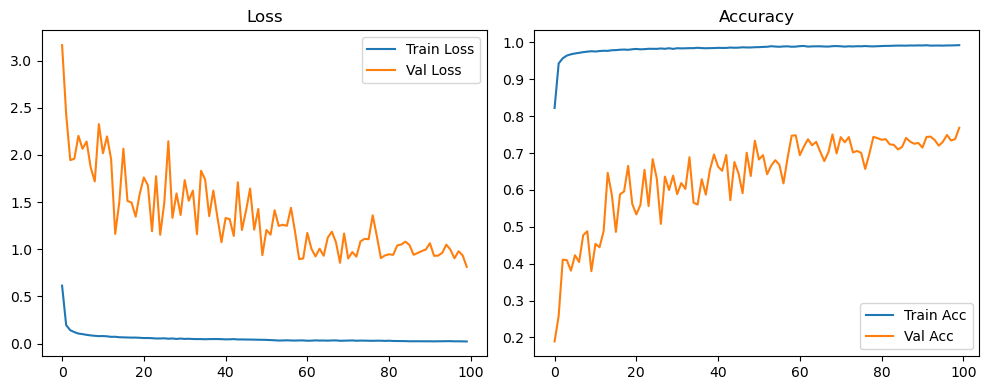

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2888, Acc: 0.9445 | Val Loss: 0.1958, Acc: 0.9444


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9831 | Val Loss: 0.1891, Acc: 0.9407


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9878 | Val Loss: 0.5030, Acc: 0.8359


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9915 | Val Loss: 0.0800, Acc: 0.9758


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.6118, Acc: 0.8007


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9949 | Val Loss: 0.0995, Acc: 0.9685


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9969 | Val Loss: 0.0544, Acc: 0.9825


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.0841, Acc: 0.9732


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.1277, Acc: 0.9617


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.1409, Acc: 0.9597


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0614, Acc: 0.9821


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.0906, Acc: 0.9751


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0837, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0766, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0706, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1115, Acc: 0.9713


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0501, Acc: 0.9862


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0594, Acc: 0.9846


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0668, Acc: 0.9820


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0831, Acc: 0.9775


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0942, Acc: 0.9772


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1461, Acc: 0.9652


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0767, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0697, Acc: 0.9822


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0580, Acc: 0.9858


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0655, Acc: 0.9839


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0517, Acc: 0.9880


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9886


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0464, Acc: 0.9882


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0620, Acc: 0.9875


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.4785, Acc: 0.9128


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.0831, Acc: 0.9794


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0895, Acc: 0.9795


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0575, Acc: 0.9857


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0457, Acc: 0.9888


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9899


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9897


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9904


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9893


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9892


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9894


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9899


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9888


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9892


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9902


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9900


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9892


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9892


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9898


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9896


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9896


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9902


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9902


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9899


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9905


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9900


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9903


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9898


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9900


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9900


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9902


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9902


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9898


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9903


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9903


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9895


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9898


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9903


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9902


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9897


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9900


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9898


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9897


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9902


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9902


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9897


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9901


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9901


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9900


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9901


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9906


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9902


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9896


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0494, Acc: 0.9902


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9903


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9898


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9902


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9901


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9901


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9897


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9896


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9899


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9898


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9907


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9896


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9898


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9902


Final Test Loss: 0.0621 Accuracy: 0.9893


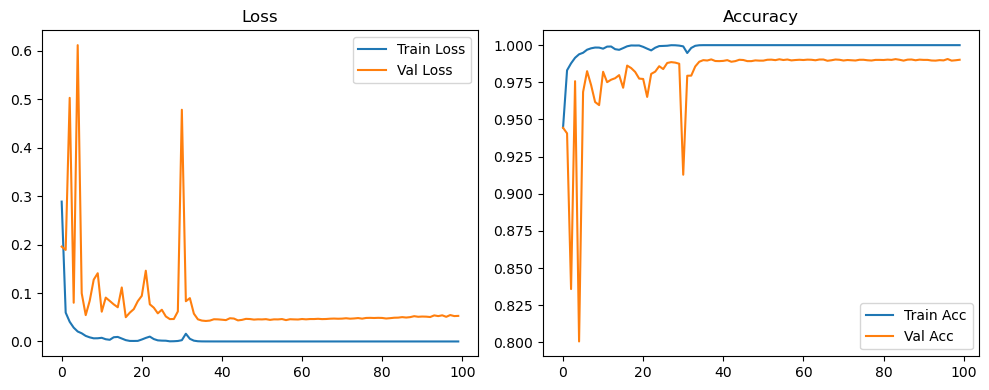

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3618, Acc: 0.9212 | Val Loss: 2.3678, Acc: 0.3737


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9743 | Val Loss: 0.9674, Acc: 0.6971


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9781 | Val Loss: 0.8479, Acc: 0.7193


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9834 | Val Loss: 0.8574, Acc: 0.7188


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9849 | Val Loss: 1.1579, Acc: 0.6677


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9868 | Val Loss: 0.4189, Acc: 0.8640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9888 | Val Loss: 0.5901, Acc: 0.8106


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9897 | Val Loss: 0.7672, Acc: 0.7796


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.5388, Acc: 0.8436


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.4140, Acc: 0.8761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.7175, Acc: 0.8225


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.4184, Acc: 0.8739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9927 | Val Loss: 0.4191, Acc: 0.8808


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.3458, Acc: 0.9006


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.3696, Acc: 0.9025


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.2888, Acc: 0.9193


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.4219, Acc: 0.8880


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.2800, Acc: 0.9218


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.5223, Acc: 0.8750


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.5325, Acc: 0.8553


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9952 | Val Loss: 0.1692, Acc: 0.9550


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.5023, Acc: 0.8780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.2667, Acc: 0.9253


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.2353, Acc: 0.9393


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.3382, Acc: 0.9141


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.3970, Acc: 0.8968


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.3250, Acc: 0.9193


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9960 | Val Loss: 0.2172, Acc: 0.9428


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.2423, Acc: 0.9384


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.5209, Acc: 0.8829


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.3014, Acc: 0.9244


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.3423, Acc: 0.9165


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.2123, Acc: 0.9475


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1676, Acc: 0.9582


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9967 | Val Loss: 0.1888, Acc: 0.9524


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.2470, Acc: 0.9387


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1056, Acc: 0.9727


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1753, Acc: 0.9566


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1567, Acc: 0.9633


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1509, Acc: 0.9635


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.2474, Acc: 0.9384


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.2139, Acc: 0.9493


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1532, Acc: 0.9646


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9974 | Val Loss: 0.1275, Acc: 0.9687


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1703, Acc: 0.9616


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9968 | Val Loss: 0.1826, Acc: 0.9561


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1537, Acc: 0.9632


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1651, Acc: 0.9633


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1504, Acc: 0.9660


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9974 | Val Loss: 0.1625, Acc: 0.9634


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1346, Acc: 0.9689


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1364, Acc: 0.9687


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1276, Acc: 0.9715


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1304, Acc: 0.9712


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1378, Acc: 0.9701


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1229, Acc: 0.9729


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1318, Acc: 0.9710


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1376, Acc: 0.9701


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1287, Acc: 0.9729


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1499, Acc: 0.9671


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1439, Acc: 0.9681


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1522, Acc: 0.9667


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1312, Acc: 0.9716


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1471, Acc: 0.9696


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1386, Acc: 0.9706


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1408, Acc: 0.9697


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1257, Acc: 0.9745


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1590, Acc: 0.9661


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1627, Acc: 0.9649


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1262, Acc: 0.9726


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1373, Acc: 0.9709


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1302, Acc: 0.9713


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1526, Acc: 0.9685


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1492, Acc: 0.9701


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1453, Acc: 0.9698


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1379, Acc: 0.9718


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1436, Acc: 0.9711


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1490, Acc: 0.9701


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1434, Acc: 0.9707


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1445, Acc: 0.9704


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1312, Acc: 0.9735


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1443, Acc: 0.9711


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1300, Acc: 0.9739


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1185, Acc: 0.9758


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1272, Acc: 0.9748


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1383, Acc: 0.9717


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1171, Acc: 0.9769


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1502, Acc: 0.9703


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1223, Acc: 0.9759


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1233, Acc: 0.9753


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1307, Acc: 0.9743


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1361, Acc: 0.9733


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1317, Acc: 0.9738


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1162, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1440, Acc: 0.9718


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1545, Acc: 0.9692


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1423, Acc: 0.9718


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1468, Acc: 0.9716


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1289, Acc: 0.9748


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1306, Acc: 0.9747


Final Test Loss: 0.1505 Accuracy: 0.9703


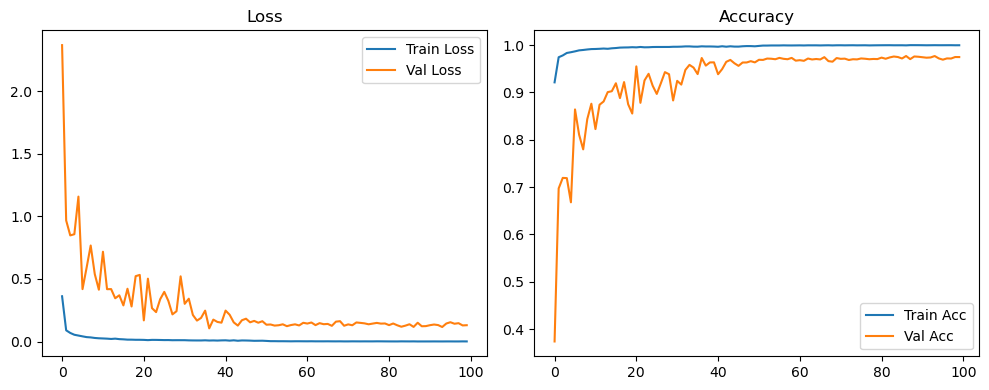

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6134, Acc: 0.8225 | Val Loss: 3.2630, Acc: 0.1856


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1932, Acc: 0.9436 | Val Loss: 2.3931, Acc: 0.2770


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1415, Acc: 0.9574 | Val Loss: 1.9659, Acc: 0.3962


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9649 | Val Loss: 2.0173, Acc: 0.3902


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9683 | Val Loss: 2.0959, Acc: 0.3999


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9701 | Val Loss: 1.9741, Acc: 0.4521


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9722 | Val Loss: 1.7624, Acc: 0.4711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0852, Acc: 0.9734 | Val Loss: 1.3903, Acc: 0.5782


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9747 | Val Loss: 1.5867, Acc: 0.5239


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9769 | Val Loss: 1.5840, Acc: 0.5267


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9756 | Val Loss: 2.2008, Acc: 0.4350


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9763 | Val Loss: 1.3943, Acc: 0.5642


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9779 | Val Loss: 1.6583, Acc: 0.5542


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9780 | Val Loss: 1.5770, Acc: 0.5264


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9792 | Val Loss: 1.5049, Acc: 0.5843


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9798 | Val Loss: 1.7702, Acc: 0.5027


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9798 | Val Loss: 1.2207, Acc: 0.6303


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9806 | Val Loss: 1.3961, Acc: 0.5981


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9797 | Val Loss: 1.3803, Acc: 0.6364


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9812 | Val Loss: 0.8289, Acc: 0.7319


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9819 | Val Loss: 1.2437, Acc: 0.6321


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9813 | Val Loss: 1.7229, Acc: 0.5549


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9817 | Val Loss: 1.0055, Acc: 0.6907


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9821 | Val Loss: 1.4082, Acc: 0.6291


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9828 | Val Loss: 1.0480, Acc: 0.7065


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9827 | Val Loss: 0.6926, Acc: 0.7893


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9833 | Val Loss: 1.3846, Acc: 0.6634


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9832 | Val Loss: 1.2231, Acc: 0.6579


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9828 | Val Loss: 1.6333, Acc: 0.6044


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9825 | Val Loss: 1.1881, Acc: 0.6757


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9841 | Val Loss: 1.2461, Acc: 0.6629


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9849 | Val Loss: 1.2876, Acc: 0.6437


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9834 | Val Loss: 0.9689, Acc: 0.7203


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9841 | Val Loss: 0.8466, Acc: 0.7305


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9843 | Val Loss: 0.9261, Acc: 0.7304


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9841 | Val Loss: 1.0597, Acc: 0.6716


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9852 | Val Loss: 1.0016, Acc: 0.7033


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9840 | Val Loss: 1.0247, Acc: 0.6975


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9847 | Val Loss: 1.0032, Acc: 0.7274


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9848 | Val Loss: 1.2342, Acc: 0.6650


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 1.1740, Acc: 0.6784


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9846 | Val Loss: 0.9616, Acc: 0.7281


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9853 | Val Loss: 0.7475, Acc: 0.7732


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9860 | Val Loss: 0.9309, Acc: 0.7226


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 0.8262, Acc: 0.7546


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9851 | Val Loss: 0.8217, Acc: 0.7508


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 1.2592, Acc: 0.6568


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9858 | Val Loss: 0.7419, Acc: 0.7813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9863 | Val Loss: 0.8445, Acc: 0.7575


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9879 | Val Loss: 0.7759, Acc: 0.7668


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.8297, Acc: 0.7593


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.8299, Acc: 0.7572


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9889 | Val Loss: 0.7847, Acc: 0.7711


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.8240, Acc: 0.7627


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9891 | Val Loss: 0.8197, Acc: 0.7672


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9895 | Val Loss: 0.7947, Acc: 0.7692


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9895 | Val Loss: 0.9507, Acc: 0.7280


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 1.1231, Acc: 0.7013


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9892 | Val Loss: 0.8269, Acc: 0.7617


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9900 | Val Loss: 0.8253, Acc: 0.7632


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.9670, Acc: 0.7408


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.7822, Acc: 0.7746


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9897 | Val Loss: 0.7039, Acc: 0.7911


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9901 | Val Loss: 0.7718, Acc: 0.7708


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.9581, Acc: 0.7249


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9898 | Val Loss: 0.9101, Acc: 0.7382


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.8521, Acc: 0.7484


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.8861, Acc: 0.7491


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9903 | Val Loss: 0.8537, Acc: 0.7562


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.8028, Acc: 0.7691


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.8965, Acc: 0.7469


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9896 | Val Loss: 0.7798, Acc: 0.7771


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.7387, Acc: 0.7879


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.7144, Acc: 0.7922


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.9696, Acc: 0.7353


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.8085, Acc: 0.7685


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.8413, Acc: 0.7622


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.8189, Acc: 0.7625


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9896 | Val Loss: 0.6676, Acc: 0.7946


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.6990, Acc: 0.7917


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.6133, Acc: 0.8153


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9912 | Val Loss: 0.7060, Acc: 0.7899


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.6259, Acc: 0.8129


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.6579, Acc: 0.8038


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.7331, Acc: 0.7839


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9909 | Val Loss: 0.7345, Acc: 0.7838


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9911 | Val Loss: 0.7087, Acc: 0.7919


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.7707, Acc: 0.7720


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.6595, Acc: 0.8032


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.6916, Acc: 0.7892


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.6756, Acc: 0.7947


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.6585, Acc: 0.8043


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9909 | Val Loss: 0.6583, Acc: 0.8064


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9912 | Val Loss: 0.7009, Acc: 0.7917


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.7337, Acc: 0.7853


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.7469, Acc: 0.7841


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.6781, Acc: 0.7992


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.6700, Acc: 0.7999


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.5767, Acc: 0.8257


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.7026, Acc: 0.7967


Final Test Loss: 0.6775 Accuracy: 0.8040


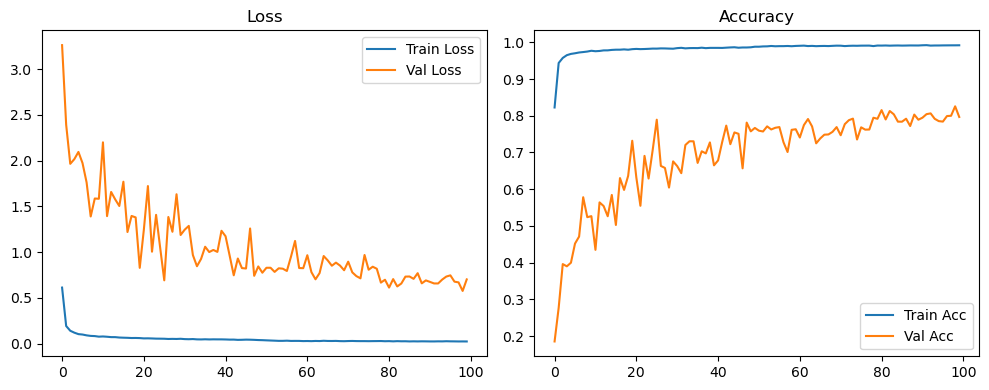

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3994, Acc: 0.9466 | Val Loss: 0.3085, Acc: 0.9079


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9841 | Val Loss: 0.5627, Acc: 0.8330


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9892 | Val Loss: 0.4265, Acc: 0.8643


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9928 | Val Loss: 0.1870, Acc: 0.9443


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9946 | Val Loss: 0.1554, Acc: 0.9503


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9961 | Val Loss: 0.0862, Acc: 0.9715


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9974 | Val Loss: 0.1046, Acc: 0.9647


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9985 | Val Loss: 0.1047, Acc: 0.9683


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9990 | Val Loss: 0.1221, Acc: 0.9641


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9995 | Val Loss: 0.1429, Acc: 0.9564


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.1518, Acc: 0.9557


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.1394, Acc: 0.9583


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.0795, Acc: 0.9782


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9992 | Val Loss: 0.1789, Acc: 0.9523


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9998 | Val Loss: 0.0495, Acc: 0.9857


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.0514, Acc: 0.9841


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9891


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9882


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9872


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9892


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9894


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9894


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9892


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9884


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9890


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9892


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9896


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9889


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9888


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9891


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9888


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9890


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9882


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9868


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9877


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9852 | Val Loss: 0.0597, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0815, Acc: 0.9757


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0639, Acc: 0.9811


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0468, Acc: 0.9877


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9998 | Val Loss: 0.0512, Acc: 0.9868


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9899


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9892


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9886


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9892


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9895


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9891


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9888


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9893


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9886


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9887


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9885


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9883


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9889


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9885


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9897


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9886


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9892


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9889


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9897


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9896


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0544, Acc: 0.9882


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9884


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9883


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.1266, Acc: 0.9649


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.0702, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0558, Acc: 0.9856


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0471, Acc: 0.9888


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9892


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9898


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9900


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9894


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9893


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9894


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9899


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9899


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9905


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9908


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9905


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9911


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9901


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9904


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9911


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0940, Acc: 0.9769


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0669, Acc: 0.9834


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0598, Acc: 0.9862


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0497, Acc: 0.9885


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9894


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9906


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9901


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9902


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9904


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9902


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9907


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9902


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9898


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9897


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9896


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9894


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9904


Final Test Loss: 0.0489 Accuracy: 0.9890


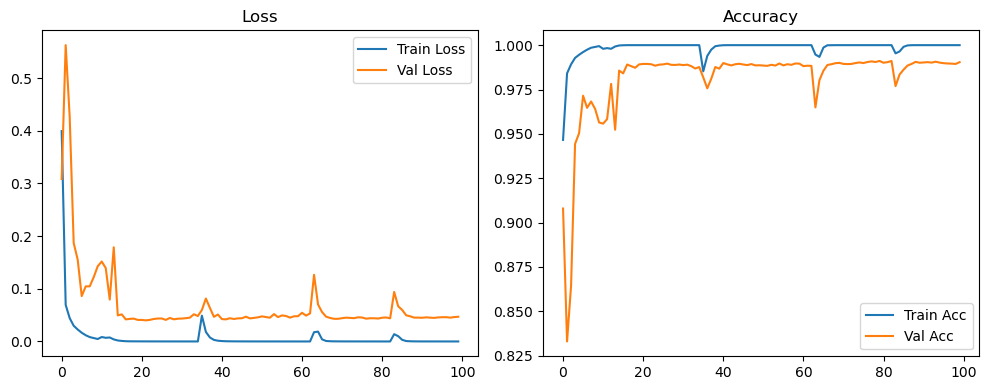

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4838, Acc: 0.9187 | Val Loss: 1.9122, Acc: 0.3242


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1084, Acc: 0.9734 | Val Loss: 1.0195, Acc: 0.6036


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9774 | Val Loss: 1.1845, Acc: 0.6002


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9826 | Val Loss: 1.2817, Acc: 0.5726


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9839 | Val Loss: 1.8195, Acc: 0.4744


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9866 | Val Loss: 0.7831, Acc: 0.7486


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9880 | Val Loss: 1.6063, Acc: 0.5547


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9883 | Val Loss: 1.0724, Acc: 0.6817


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9897 | Val Loss: 1.0612, Acc: 0.6934


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.6384, Acc: 0.7949


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.7398, Acc: 0.8071


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.8404, Acc: 0.7511


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.5631, Acc: 0.8267


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 1.1948, Acc: 0.7067


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.7615, Acc: 0.7892


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.4730, Acc: 0.8652


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9943 | Val Loss: 0.7462, Acc: 0.7831


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.7324, Acc: 0.7926


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.8274, Acc: 0.7930


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.6064, Acc: 0.8234


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1621, Acc: 0.9503


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.5402, Acc: 0.8550


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.3783, Acc: 0.8942


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.3491, Acc: 0.9076


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.6541, Acc: 0.8223


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9955 | Val Loss: 0.5214, Acc: 0.8598


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.3903, Acc: 0.8933


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1946, Acc: 0.9437


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.4501, Acc: 0.8827


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.5839, Acc: 0.8684


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.2461, Acc: 0.9317


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.3407, Acc: 0.9113


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1813, Acc: 0.9482


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1947, Acc: 0.9491


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.3004, Acc: 0.9182


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1726, Acc: 0.9543


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.4113, Acc: 0.8959


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.2500, Acc: 0.9391


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.2827, Acc: 0.9302


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.2959, Acc: 0.9222


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.2777, Acc: 0.9297


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.2373, Acc: 0.9387


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.3711, Acc: 0.9104


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.2055, Acc: 0.9493


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.3140, Acc: 0.9250


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.3290, Acc: 0.9204


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.2067, Acc: 0.9488


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1746, Acc: 0.9604


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.2484, Acc: 0.9397


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1534, Acc: 0.9625


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.2403, Acc: 0.9394


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1887, Acc: 0.9528


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.2124, Acc: 0.9494


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.2311, Acc: 0.9429


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.2671, Acc: 0.9393


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1939, Acc: 0.9537


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.2495, Acc: 0.9435


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.2305, Acc: 0.9481


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1426, Acc: 0.9671


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.2873, Acc: 0.9382


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.2266, Acc: 0.9477


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1610, Acc: 0.9644


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.2485, Acc: 0.9463


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.2329, Acc: 0.9483


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1682, Acc: 0.9617


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.2845, Acc: 0.9351


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1909, Acc: 0.9583


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.2276, Acc: 0.9489


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.2277, Acc: 0.9513


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.2697, Acc: 0.9420


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.2653, Acc: 0.9421


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.3121, Acc: 0.9351


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1828, Acc: 0.9598


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.2398, Acc: 0.9468


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.2710, Acc: 0.9395


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2036, Acc: 0.9537


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.2029, Acc: 0.9560


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.2636, Acc: 0.9417


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.2888, Acc: 0.9407


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.2320, Acc: 0.9495


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.2078, Acc: 0.9553


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1505, Acc: 0.9670


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.2650, Acc: 0.9432


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.2493, Acc: 0.9494


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9981 | Val Loss: 0.1583, Acc: 0.9660


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1924, Acc: 0.9603


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1427, Acc: 0.9705


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.2141, Acc: 0.9563


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1465, Acc: 0.9686


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.2732, Acc: 0.9448


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.2193, Acc: 0.9553


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2832, Acc: 0.9407


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.2074, Acc: 0.9567


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2741, Acc: 0.9482


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1843, Acc: 0.9633


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.2681, Acc: 0.9457


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2045, Acc: 0.9579


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1862, Acc: 0.9633


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1974, Acc: 0.9610


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.2273, Acc: 0.9553


Final Test Loss: 0.2381 Accuracy: 0.9551


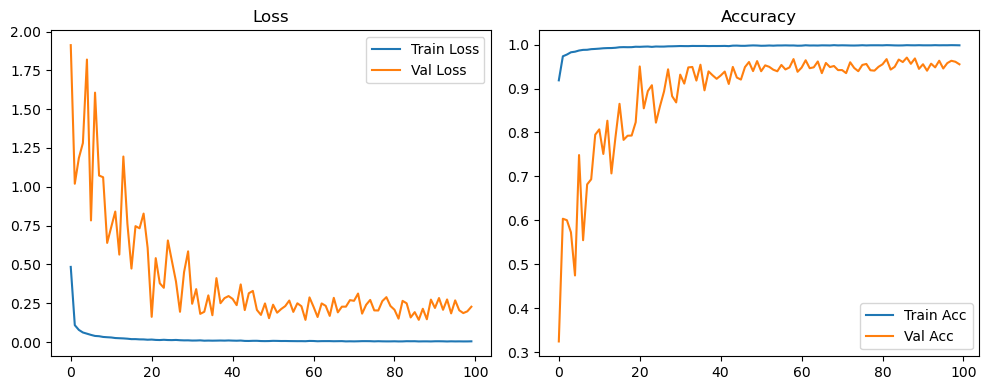

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7837, Acc: 0.7927 | Val Loss: 3.5595, Acc: 0.1206


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2557, Acc: 0.9282 | Val Loss: 3.1773, Acc: 0.2093


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1790, Acc: 0.9470 | Val Loss: 2.7532, Acc: 0.2266


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1444, Acc: 0.9583 | Val Loss: 2.6608, Acc: 0.2588


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1277, Acc: 0.9620 | Val Loss: 3.1322, Acc: 0.2587


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1161, Acc: 0.9637 | Val Loss: 3.0765, Acc: 0.2647


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1031, Acc: 0.9696 | Val Loss: 3.0254, Acc: 0.2657


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0973, Acc: 0.9701 | Val Loss: 2.5777, Acc: 0.3085


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9729 | Val Loss: 2.8465, Acc: 0.3043


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9739 | Val Loss: 3.2048, Acc: 0.2697


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0858, Acc: 0.9740 | Val Loss: 2.5769, Acc: 0.3542


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9760 | Val Loss: 2.4128, Acc: 0.3673


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0779, Acc: 0.9762 | Val Loss: 2.6206, Acc: 0.3540


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0773, Acc: 0.9763 | Val Loss: 2.2450, Acc: 0.3798


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9780 | Val Loss: 2.3738, Acc: 0.3977


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9784 | Val Loss: 2.4255, Acc: 0.3658


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9787 | Val Loss: 2.5028, Acc: 0.3502


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9782 | Val Loss: 1.7643, Acc: 0.5111


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9791 | Val Loss: 2.6305, Acc: 0.3688


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0645, Acc: 0.9800 | Val Loss: 1.9092, Acc: 0.4663


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9806 | Val Loss: 1.6811, Acc: 0.5349


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0630, Acc: 0.9799 | Val Loss: 2.4170, Acc: 0.4228


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9806 | Val Loss: 1.5428, Acc: 0.5602


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0599, Acc: 0.9814 | Val Loss: 2.1007, Acc: 0.4918


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9815 | Val Loss: 1.5914, Acc: 0.5815


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9815 | Val Loss: 1.5695, Acc: 0.5895


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9816 | Val Loss: 2.1189, Acc: 0.4718


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9817 | Val Loss: 1.7619, Acc: 0.5325


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9836 | Val Loss: 2.1371, Acc: 0.4883


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9826 | Val Loss: 1.8687, Acc: 0.5441


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9824 | Val Loss: 2.0155, Acc: 0.5200


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 1.7414, Acc: 0.5352


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9838 | Val Loss: 1.5641, Acc: 0.5838


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9839 | Val Loss: 1.3812, Acc: 0.5857


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9838 | Val Loss: 1.6868, Acc: 0.5567


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9841 | Val Loss: 2.0377, Acc: 0.4843


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9838 | Val Loss: 1.7463, Acc: 0.5337


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9837 | Val Loss: 1.7909, Acc: 0.5370


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 1.4001, Acc: 0.6452


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9834 | Val Loss: 1.4163, Acc: 0.6172


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9844 | Val Loss: 1.7050, Acc: 0.5586


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9836 | Val Loss: 1.4456, Acc: 0.6258


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9844 | Val Loss: 1.2779, Acc: 0.6383


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9852 | Val Loss: 1.3026, Acc: 0.6278


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 1.6443, Acc: 0.5642


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9853 | Val Loss: 1.3186, Acc: 0.6463


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9850 | Val Loss: 1.5944, Acc: 0.5853


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 1.1285, Acc: 0.6688


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9860 | Val Loss: 1.3661, Acc: 0.6222


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9864 | Val Loss: 1.3445, Acc: 0.6259


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9854 | Val Loss: 1.4258, Acc: 0.6277


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9852 | Val Loss: 1.5495, Acc: 0.5868


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 1.5962, Acc: 0.6064


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9851 | Val Loss: 1.2471, Acc: 0.6544


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9854 | Val Loss: 0.9865, Acc: 0.7118


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9852 | Val Loss: 1.2640, Acc: 0.6704


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9864 | Val Loss: 1.6310, Acc: 0.5893


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9862 | Val Loss: 1.8562, Acc: 0.5512


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 1.5197, Acc: 0.6094


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 1.6762, Acc: 0.6082


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9866 | Val Loss: 1.5602, Acc: 0.5905


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9859 | Val Loss: 1.2739, Acc: 0.6352


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9858 | Val Loss: 1.2209, Acc: 0.6733


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9871 | Val Loss: 1.0867, Acc: 0.6977


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 1.2759, Acc: 0.6649


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9868 | Val Loss: 1.3288, Acc: 0.6482


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 1.6206, Acc: 0.5874


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 1.2879, Acc: 0.6560


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9867 | Val Loss: 1.3352, Acc: 0.6383


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 1.4956, Acc: 0.6259


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9865 | Val Loss: 0.9519, Acc: 0.7302


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9865 | Val Loss: 1.1743, Acc: 0.6643


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9876 | Val Loss: 1.3202, Acc: 0.6512


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9869 | Val Loss: 1.6093, Acc: 0.5894


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 1.3225, Acc: 0.6424


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9888 | Val Loss: 1.2158, Acc: 0.6916


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9883 | Val Loss: 1.1052, Acc: 0.6940


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.9610, Acc: 0.7236


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9871 | Val Loss: 1.1342, Acc: 0.6987


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9873 | Val Loss: 1.1264, Acc: 0.6879


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.9263, Acc: 0.7324


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.8795, Acc: 0.7472


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 1.2390, Acc: 0.6776


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.8906, Acc: 0.7428


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9876 | Val Loss: 0.7444, Acc: 0.7733


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9882 | Val Loss: 0.8813, Acc: 0.7405


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9878 | Val Loss: 0.9673, Acc: 0.7192


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9874 | Val Loss: 0.7880, Acc: 0.7648


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9881 | Val Loss: 0.8803, Acc: 0.7470


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 1.1059, Acc: 0.7000


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9880 | Val Loss: 1.1886, Acc: 0.6785


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9885 | Val Loss: 1.0012, Acc: 0.7270


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.8381, Acc: 0.7572


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9881 | Val Loss: 1.1854, Acc: 0.6801


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 1.2406, Acc: 0.6646


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9885 | Val Loss: 1.0524, Acc: 0.7091


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9887 | Val Loss: 0.8099, Acc: 0.7644


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9886 | Val Loss: 0.8840, Acc: 0.7466


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.9983, Acc: 0.7256


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9880 | Val Loss: 1.1469, Acc: 0.6830


Final Test Loss: 1.1209 Accuracy: 0.6874


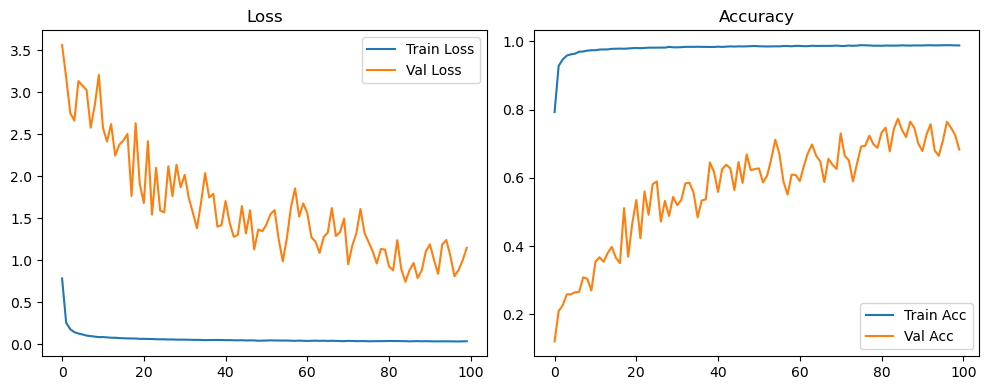

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3995, Acc: 0.9467 | Val Loss: 0.2895, Acc: 0.9203


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9843 | Val Loss: 0.5382, Acc: 0.8262


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9893 | Val Loss: 0.2085, Acc: 0.9388


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9924 | Val Loss: 0.1094, Acc: 0.9673


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9941 | Val Loss: 0.2166, Acc: 0.9311


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9960 | Val Loss: 0.1879, Acc: 0.9368


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9975 | Val Loss: 0.0584, Acc: 0.9832


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9985 | Val Loss: 0.1234, Acc: 0.9601


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9991 | Val Loss: 0.0696, Acc: 0.9792


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9988 | Val Loss: 0.0893, Acc: 0.9731


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.0900, Acc: 0.9730


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9984 | Val Loss: 0.1677, Acc: 0.9495


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9993 | Val Loss: 0.1156, Acc: 0.9696


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.0581, Acc: 0.9831


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9998 | Val Loss: 0.0678, Acc: 0.9798


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0723, Acc: 0.9791


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9863


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9887


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9890


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9894


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9897


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9894


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9894


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9898


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9893


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9895


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9892


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9894


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9891


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9893


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9890


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9888


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9891


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9896


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9890


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9899


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9889


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9884


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9892


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9895


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9896


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 0.3607, Acc: 0.8913


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.0688, Acc: 0.9819


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0641, Acc: 0.9814


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.0430, Acc: 0.9886


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9997 | Val Loss: 0.0400, Acc: 0.9893


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.0382, Acc: 0.9902


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9898


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9905


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9903


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9900


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9908


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9901


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9902


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9908


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9906


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9900


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9910


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9911


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9910


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9910


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9902


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9903


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9902


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9892


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9906


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9899


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9907


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9904


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9896


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9905


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9903


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9904


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9903


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9905


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9903


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9908


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9895


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9904


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9903


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9902


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9903


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9895


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0923, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0547, Acc: 0.9878


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0492, Acc: 0.9892


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9901


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9897


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9898


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9902


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9896


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9897


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9903


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9903


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9903


Final Test Loss: 0.0516 Accuracy: 0.9874


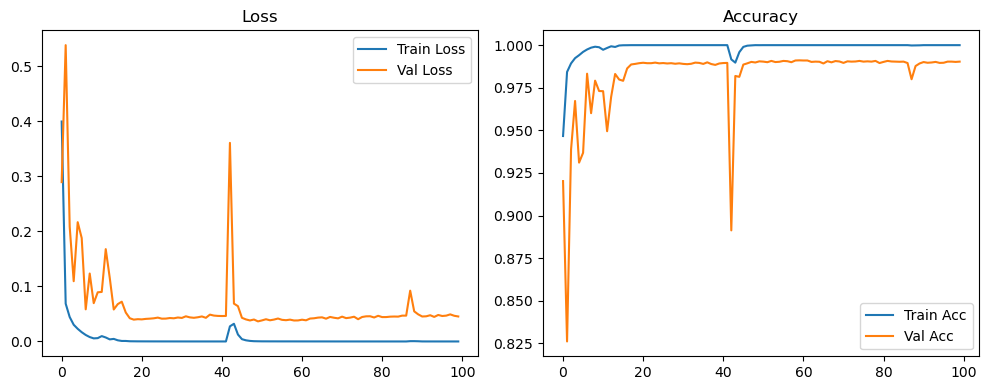

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4833, Acc: 0.9192 | Val Loss: 1.9522, Acc: 0.3336


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1082, Acc: 0.9730 | Val Loss: 1.2461, Acc: 0.5133


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0776, Acc: 0.9776 | Val Loss: 0.7413, Acc: 0.7390


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9825 | Val Loss: 1.2773, Acc: 0.6299


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9837 | Val Loss: 1.7563, Acc: 0.5250


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9861 | Val Loss: 1.2562, Acc: 0.6683


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9877 | Val Loss: 1.4348, Acc: 0.5996


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9882 | Val Loss: 0.8445, Acc: 0.7432


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 1.1621, Acc: 0.6781


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.8063, Acc: 0.7527


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9917 | Val Loss: 0.8666, Acc: 0.7550


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9913 | Val Loss: 0.9722, Acc: 0.7238


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.6958, Acc: 0.7855


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.9323, Acc: 0.7421


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.7248, Acc: 0.8041


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.7415, Acc: 0.7982


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.6971, Acc: 0.7900


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.5121, Acc: 0.8485


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9940 | Val Loss: 1.1141, Acc: 0.7655


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.6660, Acc: 0.8180


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.3500, Acc: 0.8956


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.4619, Acc: 0.8803


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.5360, Acc: 0.8492


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9950 | Val Loss: 0.5030, Acc: 0.8662


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.5728, Acc: 0.8430


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.4697, Acc: 0.8762


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.5628, Acc: 0.8476


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.3320, Acc: 0.9060


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.3342, Acc: 0.9123


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.4901, Acc: 0.8847


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.3524, Acc: 0.9040


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.4288, Acc: 0.8886


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.3422, Acc: 0.9086


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.2901, Acc: 0.9244


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.3225, Acc: 0.9148


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.2327, Acc: 0.9373


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.2154, Acc: 0.9440


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.2484, Acc: 0.9368


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9967 | Val Loss: 0.3546, Acc: 0.9132


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.2303, Acc: 0.9442


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.2637, Acc: 0.9363


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.2659, Acc: 0.9353


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.2845, Acc: 0.9313


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.2187, Acc: 0.9450


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1904, Acc: 0.9534


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.2812, Acc: 0.9336


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.2737, Acc: 0.9355


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.4769, Acc: 0.8925


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.2012, Acc: 0.9490


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.2810, Acc: 0.9295


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.2273, Acc: 0.9441


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2195, Acc: 0.9460


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2291, Acc: 0.9457


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.2888, Acc: 0.9295


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2197, Acc: 0.9471


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.2064, Acc: 0.9513


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2490, Acc: 0.9438


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2826, Acc: 0.9338


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2702, Acc: 0.9395


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.3371, Acc: 0.9248


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.3004, Acc: 0.9333


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.2732, Acc: 0.9407


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2148, Acc: 0.9520


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1788, Acc: 0.9585


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2495, Acc: 0.9437


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1628, Acc: 0.9627


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2360, Acc: 0.9463


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.2490, Acc: 0.9427


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2168, Acc: 0.9505


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1853, Acc: 0.9581


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2169, Acc: 0.9523


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.2399, Acc: 0.9471


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2808, Acc: 0.9363


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2517, Acc: 0.9447


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2300, Acc: 0.9474


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1957, Acc: 0.9557


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1723, Acc: 0.9603


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1913, Acc: 0.9570


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1867, Acc: 0.9588


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.2171, Acc: 0.9529


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1572, Acc: 0.9653


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1929, Acc: 0.9573


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1741, Acc: 0.9616


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1874, Acc: 0.9596


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2007, Acc: 0.9567


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.2101, Acc: 0.9544


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2035, Acc: 0.9548


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2002, Acc: 0.9557


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1748, Acc: 0.9605


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2004, Acc: 0.9552


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1866, Acc: 0.9589


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2164, Acc: 0.9541


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2205, Acc: 0.9527


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2526, Acc: 0.9454


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2412, Acc: 0.9490


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2171, Acc: 0.9547


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2343, Acc: 0.9506


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2527, Acc: 0.9462


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1761, Acc: 0.9618


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2261, Acc: 0.9525


Final Test Loss: 0.2437 Accuracy: 0.9502


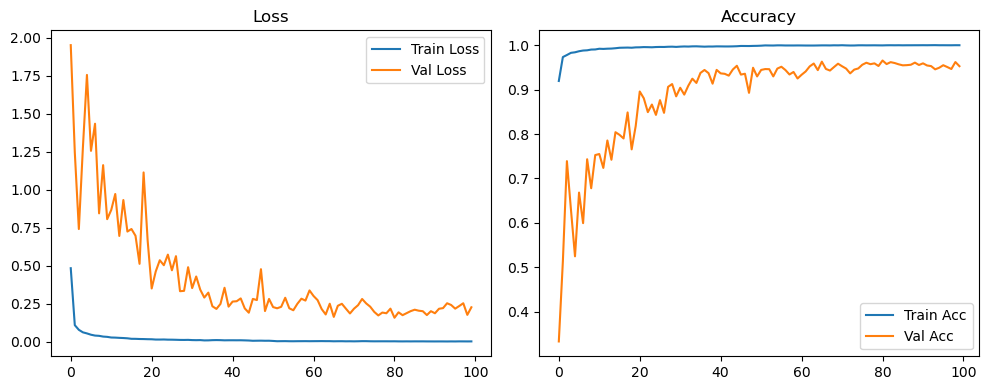

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7836, Acc: 0.7926 | Val Loss: 3.5226, Acc: 0.1302


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2560, Acc: 0.9282 | Val Loss: 3.1291, Acc: 0.2101


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1787, Acc: 0.9472 | Val Loss: 2.9691, Acc: 0.2200


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1442, Acc: 0.9589 | Val Loss: 2.6527, Acc: 0.2666


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1271, Acc: 0.9628 | Val Loss: 3.3278, Acc: 0.2410


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1168, Acc: 0.9637 | Val Loss: 3.0817, Acc: 0.2660


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1032, Acc: 0.9691 | Val Loss: 3.1335, Acc: 0.2606


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0984, Acc: 0.9706 | Val Loss: 2.7336, Acc: 0.2898


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9732 | Val Loss: 2.6601, Acc: 0.3262


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9739 | Val Loss: 2.8439, Acc: 0.2983


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0878, Acc: 0.9736 | Val Loss: 2.7297, Acc: 0.3367


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9757 | Val Loss: 2.4058, Acc: 0.3646


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9762 | Val Loss: 2.8210, Acc: 0.3302


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9767 | Val Loss: 2.2026, Acc: 0.3892


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9781 | Val Loss: 2.4935, Acc: 0.3782


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9781 | Val Loss: 2.8326, Acc: 0.3289


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9781 | Val Loss: 2.5703, Acc: 0.3515


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9783 | Val Loss: 2.0438, Acc: 0.4690


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9787 | Val Loss: 2.5050, Acc: 0.4074


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0654, Acc: 0.9805 | Val Loss: 2.0171, Acc: 0.4921


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9797 | Val Loss: 1.9326, Acc: 0.4984


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9800 | Val Loss: 2.8177, Acc: 0.3862


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9817 | Val Loss: 1.7967, Acc: 0.5396


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9819 | Val Loss: 2.0952, Acc: 0.5228


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9813 | Val Loss: 1.6343, Acc: 0.5851


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9813 | Val Loss: 1.6960, Acc: 0.5831


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9822 | Val Loss: 2.1793, Acc: 0.4838


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9824 | Val Loss: 1.4531, Acc: 0.6062


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9831 | Val Loss: 1.9234, Acc: 0.5448


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9823 | Val Loss: 1.8276, Acc: 0.5520


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9830 | Val Loss: 1.7385, Acc: 0.5752


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9826 | Val Loss: 1.7310, Acc: 0.5466


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9831 | Val Loss: 2.0991, Acc: 0.4893


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9834 | Val Loss: 1.3413, Acc: 0.6238


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9843 | Val Loss: 1.6292, Acc: 0.5619


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 1.7341, Acc: 0.5286


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9840 | Val Loss: 1.7013, Acc: 0.5470


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9838 | Val Loss: 1.9448, Acc: 0.5275


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9839 | Val Loss: 1.4954, Acc: 0.6160


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 1.5248, Acc: 0.6037


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9839 | Val Loss: 1.5428, Acc: 0.5763


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 1.0717, Acc: 0.7015


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 1.5142, Acc: 0.5863


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 1.3513, Acc: 0.6200


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9855 | Val Loss: 1.2248, Acc: 0.6383


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9856 | Val Loss: 1.3430, Acc: 0.6400


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 1.0086, Acc: 0.7118


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9855 | Val Loss: 0.9702, Acc: 0.7127


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 1.4392, Acc: 0.6248


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9860 | Val Loss: 1.0834, Acc: 0.6927


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9869 | Val Loss: 1.2563, Acc: 0.6791


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9868 | Val Loss: 1.1734, Acc: 0.6725


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 1.0997, Acc: 0.7025


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9875 | Val Loss: 0.9433, Acc: 0.7181


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.9586, Acc: 0.7270


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9875 | Val Loss: 1.1143, Acc: 0.6924


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 1.1121, Acc: 0.6842


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9886 | Val Loss: 1.4175, Acc: 0.6490


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9882 | Val Loss: 1.3072, Acc: 0.6444


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 1.4804, Acc: 0.6318


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9884 | Val Loss: 1.2083, Acc: 0.6762


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 1.1524, Acc: 0.6879


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.9340, Acc: 0.7351


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 1.0255, Acc: 0.7062


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 1.2927, Acc: 0.6590


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 1.3236, Acc: 0.6551


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9881 | Val Loss: 1.3968, Acc: 0.6324


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 1.1681, Acc: 0.6869


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 1.2618, Acc: 0.6639


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9890 | Val Loss: 1.3802, Acc: 0.6597


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9887 | Val Loss: 1.2344, Acc: 0.6826


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 1.2346, Acc: 0.6696


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 1.1902, Acc: 0.6863


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9888 | Val Loss: 1.4273, Acc: 0.6408


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9887 | Val Loss: 1.3352, Acc: 0.6672


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 1.3209, Acc: 0.6781


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 1.2378, Acc: 0.6823


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 1.2101, Acc: 0.6810


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9885 | Val Loss: 1.2677, Acc: 0.6689


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 1.2041, Acc: 0.6840


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 1.2686, Acc: 0.6689


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9895 | Val Loss: 1.0071, Acc: 0.7297


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 1.2169, Acc: 0.6937


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9905 | Val Loss: 1.1803, Acc: 0.6917


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9902 | Val Loss: 1.1106, Acc: 0.7039


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 1.1644, Acc: 0.7034


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 1.3706, Acc: 0.6697


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 1.3000, Acc: 0.6777


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 1.1691, Acc: 0.6928


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 1.3287, Acc: 0.6682


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 1.2165, Acc: 0.6896


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 1.2112, Acc: 0.6892


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 1.0995, Acc: 0.7190


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 1.2399, Acc: 0.6799


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9898 | Val Loss: 1.3405, Acc: 0.6633


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 1.2402, Acc: 0.6884


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 1.1768, Acc: 0.6964


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 1.1298, Acc: 0.7046


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 1.0737, Acc: 0.7177


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 1.1051, Acc: 0.7099


Final Test Loss: 1.0755 Accuracy: 0.7188


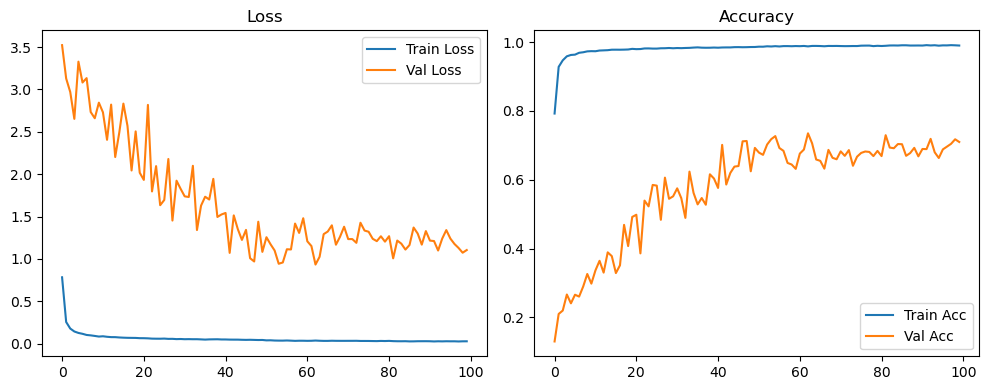

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6747, Acc: 0.9444 | Val Loss: 0.4579, Acc: 0.8877


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1296, Acc: 0.9824 | Val Loss: 0.3279, Acc: 0.9293


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9882 | Val Loss: 0.9960, Acc: 0.6438


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9915 | Val Loss: 0.1504, Acc: 0.9657


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9937 | Val Loss: 0.0940, Acc: 0.9740


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9959 | Val Loss: 0.1888, Acc: 0.9490


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9971 | Val Loss: 0.0606, Acc: 0.9825


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9985 | Val Loss: 0.0826, Acc: 0.9761


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9988 | Val Loss: 0.0788, Acc: 0.9756


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9992 | Val Loss: 0.0737, Acc: 0.9788


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9992 | Val Loss: 0.1175, Acc: 0.9634


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9995 | Val Loss: 0.0624, Acc: 0.9820


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9999 | Val Loss: 0.0572, Acc: 0.9838


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9864


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9982 | Val Loss: 0.0951, Acc: 0.9724


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9987 | Val Loss: 0.2209, Acc: 0.9277


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9988 | Val Loss: 0.2679, Acc: 0.9086


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9996 | Val Loss: 0.0588, Acc: 0.9819


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9844


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9874


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9874


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9877


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9882


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9836


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0905, Acc: 0.9732


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.5336, Acc: 0.8542


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.3714, Acc: 0.8902


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9996 | Val Loss: 0.0615, Acc: 0.9817


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9884


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9889


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9903


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9905


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9900


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9893


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9898


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9907


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9902


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9904


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9898


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9898


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9891


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9900


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9898


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9892


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9892


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9888


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9902


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9883


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9892


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9892


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9891


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9891


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9892


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9890


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9889


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9892


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9893


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9886


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9894


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9892


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9883


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0562, Acc: 0.9876


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9882


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9892


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9891


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9882


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9889


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.1514, Acc: 0.9567


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.2111, Acc: 0.9309


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0663, Acc: 0.9815


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0467, Acc: 0.9876


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9900


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9887


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9886


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9882


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9895


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9893


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9890


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9887


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9883


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9885


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9877


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9900


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9880


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9888


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9883


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9890


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9889


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9883


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9879


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9886


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9894


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9883


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9877


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9892


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9883


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9888


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9888


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9888


Final Test Loss: 0.0550 Accuracy: 0.9881


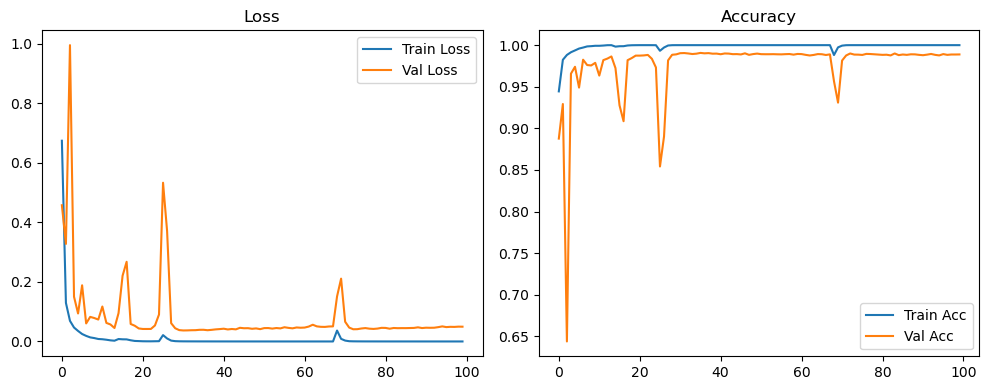

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.7797, Acc: 0.9088 | Val Loss: 2.0958, Acc: 0.2181


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1921, Acc: 0.9692 | Val Loss: 1.3494, Acc: 0.4267


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1156, Acc: 0.9752 | Val Loss: 1.4402, Acc: 0.4602


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0852, Acc: 0.9803 | Val Loss: 1.3854, Acc: 0.4585


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9821 | Val Loss: 1.6214, Acc: 0.4579


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9833 | Val Loss: 1.8950, Acc: 0.4187


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9851 | Val Loss: 2.9195, Acc: 0.3100


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0478, Acc: 0.9872 | Val Loss: 2.1974, Acc: 0.3859


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9877 | Val Loss: 1.9248, Acc: 0.4856


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9878 | Val Loss: 2.1748, Acc: 0.4343


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9895 | Val Loss: 1.5024, Acc: 0.5716


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9895 | Val Loss: 1.5819, Acc: 0.5523


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9905 | Val Loss: 1.8157, Acc: 0.5555


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9909 | Val Loss: 1.4711, Acc: 0.5724


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9911 | Val Loss: 0.9458, Acc: 0.6791


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9925 | Val Loss: 1.4872, Acc: 0.5692


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 1.9734, Acc: 0.4973


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 1.3255, Acc: 0.6393


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 2.0705, Acc: 0.5373


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9939 | Val Loss: 1.3987, Acc: 0.6108


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 1.3047, Acc: 0.6619


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 1.0509, Acc: 0.7083


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 1.1089, Acc: 0.6928


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 1.4785, Acc: 0.6398


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 1.0756, Acc: 0.6980


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 1.5986, Acc: 0.6255


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.8844, Acc: 0.7826


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.5196, Acc: 0.8549


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.7853, Acc: 0.7886


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.9295, Acc: 0.7774


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.9899, Acc: 0.7628


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.4489, Acc: 0.8662


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.9782, Acc: 0.7532


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.6318, Acc: 0.8266


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9957 | Val Loss: 0.6896, Acc: 0.7956


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.7814, Acc: 0.7884


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.4111, Acc: 0.8739


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 1.4414, Acc: 0.7076


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.8039, Acc: 0.8079


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.5121, Acc: 0.8667


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.6320, Acc: 0.8327


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.6303, Acc: 0.8337


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.9304, Acc: 0.7706


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.7956, Acc: 0.8047


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.7200, Acc: 0.8177


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.8954, Acc: 0.7702


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 1.0669, Acc: 0.7278


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.6163, Acc: 0.8373


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.6797, Acc: 0.8398


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.4172, Acc: 0.8878


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 1.0949, Acc: 0.7308


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.8568, Acc: 0.7762


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.7201, Acc: 0.8356


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.5241, Acc: 0.8703


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.5569, Acc: 0.8653


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.7577, Acc: 0.8308


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.4946, Acc: 0.8846


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.5170, Acc: 0.8884


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.6597, Acc: 0.8519


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.8693, Acc: 0.8167


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.7828, Acc: 0.8214


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.3654, Acc: 0.8985


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.7670, Acc: 0.8236


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.5980, Acc: 0.8645


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.4556, Acc: 0.8899


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.5142, Acc: 0.8706


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.4440, Acc: 0.8924


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.4981, Acc: 0.8758


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.4945, Acc: 0.8855


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.4812, Acc: 0.8854


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.4725, Acc: 0.8850


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.4680, Acc: 0.8864


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.3521, Acc: 0.9112


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.5640, Acc: 0.8676


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.6026, Acc: 0.8424


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.4246, Acc: 0.9010


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.5969, Acc: 0.8629


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.5202, Acc: 0.8862


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.4838, Acc: 0.8872


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.5823, Acc: 0.8635


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.3861, Acc: 0.9033


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.2526, Acc: 0.9367


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.5672, Acc: 0.8700


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.3696, Acc: 0.9194


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.4060, Acc: 0.9062


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.3974, Acc: 0.9055


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.2942, Acc: 0.9293


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.4347, Acc: 0.9042


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.3594, Acc: 0.9131


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.2830, Acc: 0.9307


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.2758, Acc: 0.9331


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.3330, Acc: 0.9227


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3623, Acc: 0.9183


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.5662, Acc: 0.8861


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.3407, Acc: 0.9230


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.3603, Acc: 0.9127


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.4037, Acc: 0.9064


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.2947, Acc: 0.9319


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.4580, Acc: 0.8992


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.3659, Acc: 0.9158


Final Test Loss: 0.3937 Accuracy: 0.9137


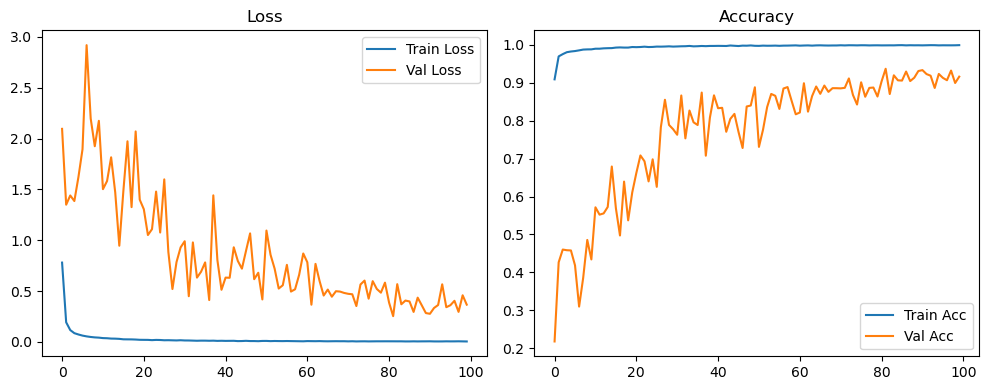

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 1.1232, Acc: 0.7332 | Val Loss: 3.4127, Acc: 0.1133


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.4500, Acc: 0.8908 | Val Loss: 3.4653, Acc: 0.1680


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2883, Acc: 0.9241 | Val Loss: 3.2549, Acc: 0.2078


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2166, Acc: 0.9417 | Val Loss: 3.5008, Acc: 0.2122


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1832, Acc: 0.9497 | Val Loss: 3.6262, Acc: 0.2132


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1610, Acc: 0.9542 | Val Loss: 3.6568, Acc: 0.2178


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1437, Acc: 0.9588 | Val Loss: 3.6397, Acc: 0.2166


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1307, Acc: 0.9628 | Val Loss: 3.6834, Acc: 0.2223


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1224, Acc: 0.9648 | Val Loss: 3.5055, Acc: 0.2441


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1127, Acc: 0.9661 | Val Loss: 3.7743, Acc: 0.2142


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1117, Acc: 0.9671 | Val Loss: 3.3741, Acc: 0.2242


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1045, Acc: 0.9686 | Val Loss: 3.5207, Acc: 0.2228


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0974, Acc: 0.9716 | Val Loss: 3.3382, Acc: 0.2383


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0979, Acc: 0.9711 | Val Loss: 3.5799, Acc: 0.2268


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0916, Acc: 0.9728 | Val Loss: 3.4140, Acc: 0.2335


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0872, Acc: 0.9732 | Val Loss: 3.3582, Acc: 0.2348


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0843, Acc: 0.9752 | Val Loss: 3.6296, Acc: 0.2311


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9752 | Val Loss: 2.9878, Acc: 0.2892


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0798, Acc: 0.9755 | Val Loss: 3.2697, Acc: 0.2658


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0761, Acc: 0.9768 | Val Loss: 3.2003, Acc: 0.2722


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9769 | Val Loss: 2.9572, Acc: 0.3281


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0726, Acc: 0.9770 | Val Loss: 3.3215, Acc: 0.2700


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0686, Acc: 0.9795 | Val Loss: 2.7907, Acc: 0.3079


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9797 | Val Loss: 3.3672, Acc: 0.2659


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0672, Acc: 0.9782 | Val Loss: 2.8443, Acc: 0.3340


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0674, Acc: 0.9791 | Val Loss: 3.1997, Acc: 0.2721


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9794 | Val Loss: 3.2658, Acc: 0.2894


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0655, Acc: 0.9801 | Val Loss: 3.0352, Acc: 0.3068


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9814 | Val Loss: 2.5915, Acc: 0.3490


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9805 | Val Loss: 2.6046, Acc: 0.3857


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9820 | Val Loss: 2.5903, Acc: 0.4127


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9815 | Val Loss: 2.6822, Acc: 0.3809


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 2.6569, Acc: 0.3583


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0594, Acc: 0.9824 | Val Loss: 2.9439, Acc: 0.3603


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9823 | Val Loss: 2.9911, Acc: 0.3275


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9823 | Val Loss: 3.0943, Acc: 0.3321


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9826 | Val Loss: 2.5619, Acc: 0.3951


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9829 | Val Loss: 3.2016, Acc: 0.3298


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0569, Acc: 0.9820 | Val Loss: 3.2218, Acc: 0.3232


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9824 | Val Loss: 2.9158, Acc: 0.3594


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9835 | Val Loss: 3.0570, Acc: 0.3357


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9828 | Val Loss: 2.7554, Acc: 0.3572


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9843 | Val Loss: 2.7520, Acc: 0.3738


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9835 | Val Loss: 2.6671, Acc: 0.4056


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9837 | Val Loss: 2.2638, Acc: 0.4593


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9845 | Val Loss: 1.8336, Acc: 0.5324


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 2.2848, Acc: 0.4286


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9842 | Val Loss: 2.4288, Acc: 0.4102


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 2.7125, Acc: 0.3887


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9847 | Val Loss: 2.5303, Acc: 0.4111


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9842 | Val Loss: 2.7023, Acc: 0.3931


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9831 | Val Loss: 2.6067, Acc: 0.3980


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9845 | Val Loss: 2.3084, Acc: 0.4772


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9841 | Val Loss: 1.9974, Acc: 0.5062


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9846 | Val Loss: 2.4597, Acc: 0.4439


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9845 | Val Loss: 2.4052, Acc: 0.4303


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 2.3333, Acc: 0.4542


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9848 | Val Loss: 2.1535, Acc: 0.4850


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9850 | Val Loss: 2.2723, Acc: 0.4416


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9858 | Val Loss: 2.0601, Acc: 0.5189


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9850 | Val Loss: 2.2250, Acc: 0.4693


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9859 | Val Loss: 1.8129, Acc: 0.5678


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 2.2135, Acc: 0.4756


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 1.9496, Acc: 0.5157


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9857 | Val Loss: 1.9797, Acc: 0.5038


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 2.1960, Acc: 0.4806


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9857 | Val Loss: 2.2406, Acc: 0.4701


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 1.8397, Acc: 0.5539


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9860 | Val Loss: 2.2535, Acc: 0.4903


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9859 | Val Loss: 1.9437, Acc: 0.5323


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9865 | Val Loss: 1.9470, Acc: 0.5178


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9860 | Val Loss: 1.9870, Acc: 0.5031


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 2.0991, Acc: 0.4778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 2.0385, Acc: 0.5165


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 2.0641, Acc: 0.4868


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 1.6106, Acc: 0.5999


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9866 | Val Loss: 1.8066, Acc: 0.5562


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 1.5620, Acc: 0.6039


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 1.8863, Acc: 0.5411


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9867 | Val Loss: 1.6314, Acc: 0.5829


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 1.6821, Acc: 0.5741


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 1.4570, Acc: 0.6237


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 1.8714, Acc: 0.5757


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9881 | Val Loss: 1.6591, Acc: 0.5807


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 1.5809, Acc: 0.5753


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9875 | Val Loss: 1.8317, Acc: 0.5537


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 1.7271, Acc: 0.5727


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9873 | Val Loss: 1.4991, Acc: 0.6046


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9874 | Val Loss: 1.5685, Acc: 0.6142


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 1.7387, Acc: 0.5663


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9877 | Val Loss: 1.7144, Acc: 0.5663


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9872 | Val Loss: 1.3313, Acc: 0.6366


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 1.6510, Acc: 0.5891


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 1.5212, Acc: 0.6015


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 1.8683, Acc: 0.5414


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9877 | Val Loss: 1.5999, Acc: 0.6164


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 1.5949, Acc: 0.5958


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 1.6303, Acc: 0.5849


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9880 | Val Loss: 1.6407, Acc: 0.5957


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 1.5165, Acc: 0.6260


Final Test Loss: 1.4950 Accuracy: 0.6301


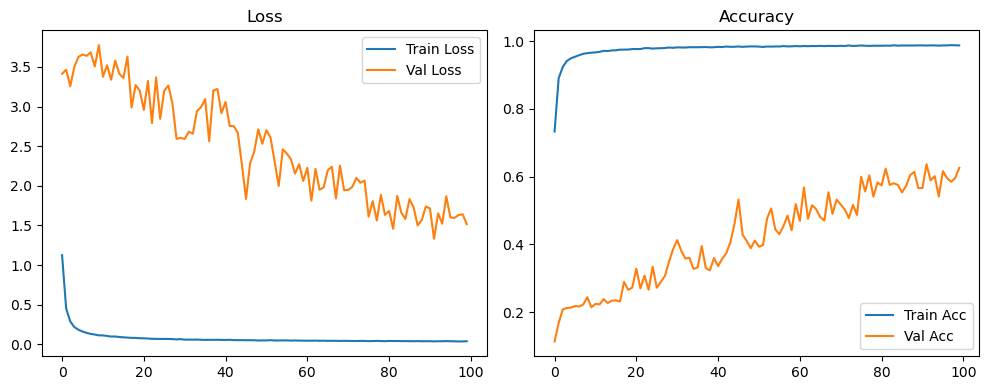

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9769, Acc: 0.9368 | Val Loss: 0.6093, Acc: 0.9337


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2794, Acc: 0.9797 | Val Loss: 0.3122, Acc: 0.9619


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1325, Acc: 0.9863 | Val Loss: 0.2789, Acc: 0.9519


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9894 | Val Loss: 0.4286, Acc: 0.8791


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0603, Acc: 0.9924 | Val Loss: 0.2334, Acc: 0.9431


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9942 | Val Loss: 0.0836, Acc: 0.9831


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9959 | Val Loss: 0.2384, Acc: 0.9399


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9972 | Val Loss: 0.2110, Acc: 0.9457


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9981 | Val Loss: 0.0706, Acc: 0.9817


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9988 | Val Loss: 0.1719, Acc: 0.9497


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9991 | Val Loss: 0.1944, Acc: 0.9467


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9995 | Val Loss: 0.1216, Acc: 0.9647


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9997 | Val Loss: 0.1032, Acc: 0.9732


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9997 | Val Loss: 0.1128, Acc: 0.9666


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9997 | Val Loss: 0.1447, Acc: 0.9563


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9788


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9839


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 1.0000 | Val Loss: 0.1833, Acc: 0.9418


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9991 | Val Loss: 0.2455, Acc: 0.9222


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9967 | Val Loss: 0.0956, Acc: 0.9712


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9992 | Val Loss: 0.0561, Acc: 0.9830


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9999 | Val Loss: 0.0626, Acc: 0.9818


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9876


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9877


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9881


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9871


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9855


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9883


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9876


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9846


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9846


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9868


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9850


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9795


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 1.4620, Acc: 0.6172


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9894 | Val Loss: 0.1212, Acc: 0.9628


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9984 | Val Loss: 0.0851, Acc: 0.9740


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9997 | Val Loss: 0.0429, Acc: 0.9878


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9876


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9884


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9878


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9882


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9885


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9884


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9876


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9887


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9882


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9884


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9880


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 1.3956, Acc: 0.6438


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.2311, Acc: 0.9384


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9995 | Val Loss: 0.0749, Acc: 0.9760


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9883


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9898


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9892


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9898


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9894


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9900


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9888


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9896


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9890


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9894


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9882


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9891


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9885


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9889


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9880


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9889


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9888


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9888


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9882


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9895


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9888


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9890


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9882


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9892


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9884


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9878


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9885


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9882


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 1.0493, Acc: 0.7415


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.3963, Acc: 0.8864


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.0561, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.0513, Acc: 0.9865


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9856


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9892


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9888


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9895


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9890


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9888


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9903


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9889


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9890


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9882


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9881


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9884


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9893


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9891


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9888


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9891


Final Test Loss: 0.0431 Accuracy: 0.9891


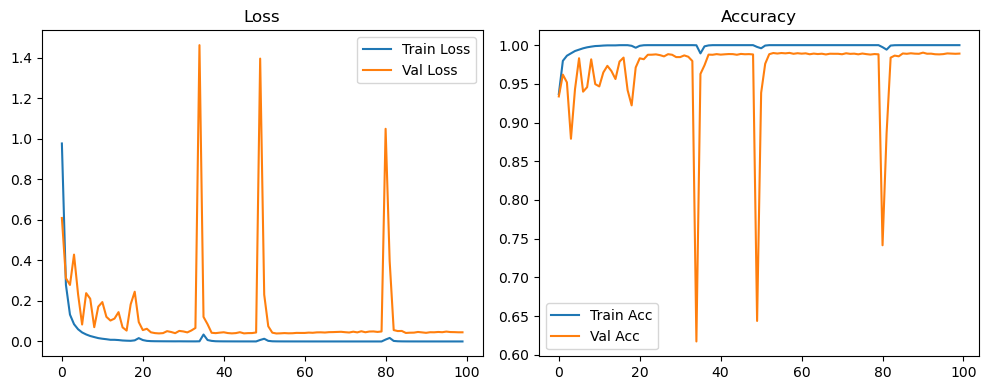

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.0822, Acc: 0.8906 | Val Loss: 1.7865, Acc: 0.2269


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3801, Acc: 0.9614 | Val Loss: 1.0732, Acc: 0.5367


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2046, Acc: 0.9706 | Val Loss: 1.4967, Acc: 0.4203


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1384, Acc: 0.9769 | Val Loss: 1.5684, Acc: 0.3655


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1103, Acc: 0.9787 | Val Loss: 2.0022, Acc: 0.2837


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9814 | Val Loss: 1.9794, Acc: 0.3228


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0761, Acc: 0.9836 | Val Loss: 2.3635, Acc: 0.2965


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9848 | Val Loss: 1.7275, Acc: 0.4240


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0611, Acc: 0.9851 | Val Loss: 2.0602, Acc: 0.3814


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0558, Acc: 0.9862 | Val Loss: 1.7931, Acc: 0.3806


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9870 | Val Loss: 2.1872, Acc: 0.3588


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9876 | Val Loss: 2.1323, Acc: 0.3863


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9885 | Val Loss: 2.0621, Acc: 0.4859


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9884 | Val Loss: 1.6882, Acc: 0.5535


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9891 | Val Loss: 2.0129, Acc: 0.4204


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9906 | Val Loss: 1.6526, Acc: 0.5456


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9907 | Val Loss: 2.2163, Acc: 0.3897


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9906 | Val Loss: 1.9809, Acc: 0.4828


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9919 | Val Loss: 2.4660, Acc: 0.3840


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9920 | Val Loss: 2.5336, Acc: 0.4016


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9922 | Val Loss: 2.4395, Acc: 0.4561


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9924 | Val Loss: 1.9098, Acc: 0.5245


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 1.7795, Acc: 0.5447


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9921 | Val Loss: 1.4332, Acc: 0.6127


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9932 | Val Loss: 2.9235, Acc: 0.3825


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9939 | Val Loss: 1.3900, Acc: 0.6706


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9938 | Val Loss: 1.2205, Acc: 0.7132


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9943 | Val Loss: 2.0396, Acc: 0.5387


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9942 | Val Loss: 1.0026, Acc: 0.7208


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 2.2488, Acc: 0.5300


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 1.8772, Acc: 0.5920


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 1.4915, Acc: 0.6476


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9948 | Val Loss: 1.4710, Acc: 0.6342


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 1.9140, Acc: 0.5573


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 1.3613, Acc: 0.6314


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9956 | Val Loss: 1.7029, Acc: 0.6052


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 1.8691, Acc: 0.5615


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 2.4322, Acc: 0.4992


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 1.3260, Acc: 0.6735


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 1.4791, Acc: 0.6523


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.8388, Acc: 0.7827


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 1.2216, Acc: 0.7027


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 1.6277, Acc: 0.6408


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 1.8752, Acc: 0.5634


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.8270, Acc: 0.7583


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 1.2134, Acc: 0.7045


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 1.6212, Acc: 0.5810


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.9409, Acc: 0.7582


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 1.2244, Acc: 0.7001


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 1.4825, Acc: 0.6482


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 1.4536, Acc: 0.6690


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 2.1954, Acc: 0.5475


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 1.2487, Acc: 0.7205


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 1.1732, Acc: 0.6933


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 1.1497, Acc: 0.6891


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 1.2523, Acc: 0.7108


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 1.5180, Acc: 0.6695


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 1.6425, Acc: 0.6483


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.9396, Acc: 0.7907


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 1.7798, Acc: 0.6360


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 1.3197, Acc: 0.7042


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.8152, Acc: 0.7844


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 1.1709, Acc: 0.7218


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.9405, Acc: 0.7782


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.7929, Acc: 0.7934


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 1.4677, Acc: 0.6923


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 1.2969, Acc: 0.7508


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.7806, Acc: 0.7973


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.8538, Acc: 0.7947


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 1.0742, Acc: 0.7665


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.7787, Acc: 0.8119


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.9130, Acc: 0.7874


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 1.4207, Acc: 0.7109


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 1.0920, Acc: 0.7480


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.9083, Acc: 0.7913


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 1.0693, Acc: 0.7760


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 1.2152, Acc: 0.7460


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9971 | Val Loss: 1.1845, Acc: 0.7729


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.7779, Acc: 0.8438


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 1.3503, Acc: 0.7134


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.9295, Acc: 0.7937


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 1.0955, Acc: 0.7725


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 1.2891, Acc: 0.7685


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.9354, Acc: 0.7883


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.9337, Acc: 0.8007


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 1.3225, Acc: 0.7482


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.8728, Acc: 0.8209


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.5807, Acc: 0.8666


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.8657, Acc: 0.7947


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.8793, Acc: 0.7972


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.5978, Acc: 0.8555


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 1.0319, Acc: 0.7802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 1.2531, Acc: 0.7279


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 1.0840, Acc: 0.7700


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 1.1485, Acc: 0.7719


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 1.1224, Acc: 0.7484


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 1.3529, Acc: 0.7356


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.8790, Acc: 0.8206


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.7217, Acc: 0.8442


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.7131, Acc: 0.8478


Final Test Loss: 0.7059 Accuracy: 0.8475


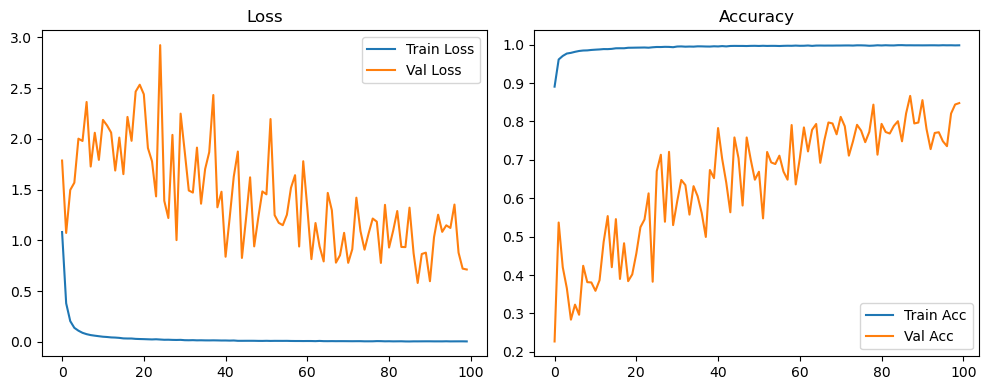

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.3973, Acc: 0.6760 | Val Loss: 2.9722, Acc: 0.1133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.7399, Acc: 0.8437 | Val Loss: 3.3139, Acc: 0.1133


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.4774, Acc: 0.8899 | Val Loss: 3.3921, Acc: 0.1440


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3496, Acc: 0.9162 | Val Loss: 3.5025, Acc: 0.2076


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2839, Acc: 0.9291 | Val Loss: 3.8313, Acc: 0.2057


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2408, Acc: 0.9378 | Val Loss: 3.7793, Acc: 0.2074


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2124, Acc: 0.9445 | Val Loss: 3.4872, Acc: 0.2126


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1873, Acc: 0.9500 | Val Loss: 3.4758, Acc: 0.2154


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1717, Acc: 0.9533 | Val Loss: 3.4453, Acc: 0.2242


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1566, Acc: 0.9562 | Val Loss: 3.7470, Acc: 0.2127


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1500, Acc: 0.9572 | Val Loss: 3.5721, Acc: 0.2208


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1410, Acc: 0.9600 | Val Loss: 3.2961, Acc: 0.2362


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1310, Acc: 0.9633 | Val Loss: 3.4837, Acc: 0.2377


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1275, Acc: 0.9626 | Val Loss: 3.6314, Acc: 0.2245


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1203, Acc: 0.9655 | Val Loss: 3.7016, Acc: 0.2298


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1127, Acc: 0.9671 | Val Loss: 3.7913, Acc: 0.2223


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1102, Acc: 0.9685 | Val Loss: 3.9221, Acc: 0.2247


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1053, Acc: 0.9689 | Val Loss: 3.7331, Acc: 0.2441


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1030, Acc: 0.9695 | Val Loss: 4.2059, Acc: 0.2147


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1007, Acc: 0.9703 | Val Loss: 3.7043, Acc: 0.2298


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0962, Acc: 0.9718 | Val Loss: 3.5412, Acc: 0.2719


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0919, Acc: 0.9724 | Val Loss: 3.7427, Acc: 0.2417


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0878, Acc: 0.9739 | Val Loss: 3.6619, Acc: 0.2322


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0876, Acc: 0.9737 | Val Loss: 3.7317, Acc: 0.2353


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0849, Acc: 0.9742 | Val Loss: 3.7507, Acc: 0.2197


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0865, Acc: 0.9732 | Val Loss: 3.5723, Acc: 0.2340


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0828, Acc: 0.9753 | Val Loss: 3.7126, Acc: 0.2387


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0799, Acc: 0.9765 | Val Loss: 3.6662, Acc: 0.2555


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0765, Acc: 0.9771 | Val Loss: 3.3404, Acc: 0.2594


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0795, Acc: 0.9764 | Val Loss: 3.6260, Acc: 0.2632


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0732, Acc: 0.9777 | Val Loss: 3.6986, Acc: 0.2473


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9785 | Val Loss: 3.5965, Acc: 0.2438


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9788 | Val Loss: 4.0096, Acc: 0.2303


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0718, Acc: 0.9780 | Val Loss: 3.3776, Acc: 0.2969


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0669, Acc: 0.9801 | Val Loss: 3.5309, Acc: 0.2317


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0663, Acc: 0.9799 | Val Loss: 3.6518, Acc: 0.2596


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9792 | Val Loss: 3.1125, Acc: 0.3037


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9799 | Val Loss: 3.5489, Acc: 0.2604


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0660, Acc: 0.9793 | Val Loss: 3.5748, Acc: 0.2668


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0634, Acc: 0.9806 | Val Loss: 3.5424, Acc: 0.2890


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9805 | Val Loss: 3.5183, Acc: 0.2894


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 3.8845, Acc: 0.2461


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0626, Acc: 0.9806 | Val Loss: 3.4063, Acc: 0.3008


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9815 | Val Loss: 3.5186, Acc: 0.2868


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9814 | Val Loss: 2.9526, Acc: 0.3043


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9818 | Val Loss: 3.1268, Acc: 0.3055


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9820 | Val Loss: 3.4861, Acc: 0.2972


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9814 | Val Loss: 3.1057, Acc: 0.3045


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 3.3006, Acc: 0.3328


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0560, Acc: 0.9822 | Val Loss: 2.9838, Acc: 0.3251


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9820 | Val Loss: 3.0147, Acc: 0.3432


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0581, Acc: 0.9814 | Val Loss: 2.8216, Acc: 0.3850


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9831 | Val Loss: 3.0854, Acc: 0.3540


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0558, Acc: 0.9823 | Val Loss: 2.8472, Acc: 0.3656


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0559, Acc: 0.9829 | Val Loss: 2.9953, Acc: 0.3509


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9832 | Val Loss: 3.1490, Acc: 0.3123


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9836 | Val Loss: 2.7713, Acc: 0.3531


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0542, Acc: 0.9831 | Val Loss: 2.8913, Acc: 0.3226


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9836 | Val Loss: 3.3114, Acc: 0.2889


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9838 | Val Loss: 2.9877, Acc: 0.3317


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9840 | Val Loss: 2.8227, Acc: 0.3407


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9837 | Val Loss: 2.3625, Acc: 0.4312


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9839 | Val Loss: 2.9311, Acc: 0.3269


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9841 | Val Loss: 2.4132, Acc: 0.4167


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9840 | Val Loss: 2.5655, Acc: 0.3975


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 2.5175, Acc: 0.4133


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9851 | Val Loss: 2.3862, Acc: 0.4062


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9842 | Val Loss: 2.1920, Acc: 0.4612


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9846 | Val Loss: 2.5540, Acc: 0.4010


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9844 | Val Loss: 2.5691, Acc: 0.4172


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9845 | Val Loss: 2.3966, Acc: 0.4412


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9841 | Val Loss: 2.7691, Acc: 0.3928


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9848 | Val Loss: 2.8041, Acc: 0.3892


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 2.6315, Acc: 0.4036


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9853 | Val Loss: 2.6376, Acc: 0.3848


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9848 | Val Loss: 2.0314, Acc: 0.4903


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9856 | Val Loss: 2.7602, Acc: 0.3802


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 2.4064, Acc: 0.4187


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9852 | Val Loss: 2.0304, Acc: 0.4709


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 2.3017, Acc: 0.4308


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9855 | Val Loss: 2.2483, Acc: 0.4358


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9861 | Val Loss: 2.1184, Acc: 0.4752


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 2.1793, Acc: 0.4783


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9854 | Val Loss: 2.0031, Acc: 0.5116


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9857 | Val Loss: 1.7611, Acc: 0.5372


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9863 | Val Loss: 1.7081, Acc: 0.5475


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 2.2638, Acc: 0.4522


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9866 | Val Loss: 1.9704, Acc: 0.5076


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 1.9681, Acc: 0.4914


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9862 | Val Loss: 1.9461, Acc: 0.5024


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9868 | Val Loss: 2.0110, Acc: 0.5068


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 1.6866, Acc: 0.5731


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 1.7679, Acc: 0.5463


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 1.8989, Acc: 0.5138


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 2.2790, Acc: 0.4682


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 2.1260, Acc: 0.4876


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 2.4518, Acc: 0.4090


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 2.1012, Acc: 0.4838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9869 | Val Loss: 1.9797, Acc: 0.5148


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 1.9616, Acc: 0.5339


Final Test Loss: 1.9364 Accuracy: 0.5339


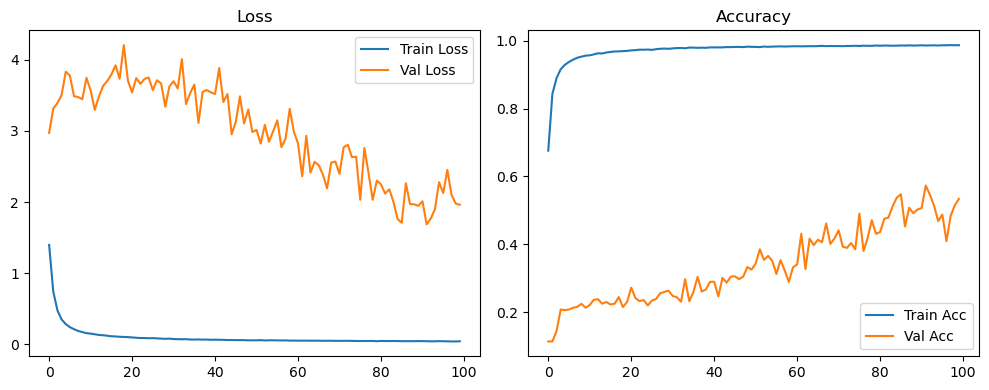

🏆 Best Config: batch64_lr0.01_0.005_0.002_dp0.0 Accuracy: 0.9918


In [8]:
root_path = "TCV_4bit_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)